In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

# 정상 기업

In [3]:
df = pd.read_excel("/content/drive/Shareddrives/F4/df11.xlsx")
df

,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,...,영업이익대비EBITDA비율,자본잠식률,자본금,이자비용,법인세비용차감전순이익,영업손익,매출총이익,자산,부채,단기매매금융자산,유동부채,자본,비유동자산,비유동부채,매출액,현금및현금성자산,이익잉여금,자본잉여금,매출채권,매입채무,유동자산,순운전자본,유형자산,무형자산,단기차입금,판관비,부가가치,재고자산,매출원가,계속영업이익,감가상각비,금융비용,EBITDA,영업활동으로인한현금흐름,장기차입금,유동성장기부채,당기순이익,합계_기말인원,상장일(명),상장폐지일
0,(주)CMG제약,58820,2010/12,245.10,192.80,28.91,74.62,28.83,0.312617,45.48,13.38,0.640152,1.621536,0.091402,-2.374708,2.100326,5.122158,0.969190,-49.93,-28.00,-54.19,-30.38,-28.72,-31.17,-61.19,8.87,-66.40,0.870632,72.40,1.29,4.36,0.82,0.46,0.47,0.85,2.29,7.41,1.11,7.02,7.74,...,1196.966559,0.106035,20588188.0,0.0,-6945220.0,-7537071.0,3132792.0,26775627.0,8370511.0,0.0,5320707.0,18405116.0,13734412.0,3049804.0,11350419.0,2447346.0,-43706768.0,38656743.0,7625064.0,1488643.0,13041215.0,7720508,10316860.0,2592590.0,1537477.0,9882038.0,796.71,0.0,8217627.0,-6945220.0,54294.0,0.0,-6296.81,-5983864.0,2000000.0,46200.0,-6945220.0,129.0,2001/08/31,NaN
1,(주)CMG제약,58820,2011/12,200.32,164.32,41.66,67.16,27.75,0.336048,50.61,16.74,0.616396,1.030375,0.041835,-2.458666,2.155043,7.458900,0.955427,-6.89,-4.66,3.90,2.63,-4.86,2.75,-7.12,0.81,4.03,0.378973,58.17,1.56,6.42,0.97,0.65,0.68,1.36,2.45,11.95,1.78,20.67,38.11,...,347.890614,0.162757,21846600.0,0.0,-1264488.0,714950.0,7425905.0,27548539.0,9257624.0,0.0,7620349.0,18290915.0,12283654.0,1637275.0,17751704.0,1152489.0,-44971257.0,39417707.0,11050219.0,1481481.0,15264885.0,7644536,9652599.0,1403125.0,2134049.0,6727421.0,3669.25,0.0,10325799.0,-1264488.0,67214.0,0.0,2055.10,-2488268.0,0.0,2000000.0,-1264488.0,135.0,2001/08/31,NaN
2,(주)CMG제약,58820,2012/12,706.26,661.93,21.09,31.37,70.91,0.445459,80.33,34.21,0.197029,1.944127,0.082001,-1.657107,1.612483,4.254231,0.991294,-27.63,-16.31,-16.22,-9.57,-16.69,-9.79,-42.40,2.46,-24.88,0.532244,71.66,0.57,5.71,0.65,0.38,0.39,1.46,1.85,7.83,1.72,-0.54,-0.95,...,1524.960228,0.042718,33012770.0,0.0,-6892739.0,-4045140.0,4606698.0,56988604.0,25386064.0,0.0,6665126.0,31602540.0,9915161.0,18720938.0,16255389.0,4673134.0,-52368787.0,50958557.0,11362566.0,2670886.0,47073443.0,40408317,9264142.0,154902.0,2132612.0,8651838.0,-88.04,0.0,11648690.0,-6892739.0,88714.0,0.0,-2652.62,-1453276.0,0.0,0.0,-6892739.0,134.0,2001/08/31,NaN
3,(주)CMG제약,58820,2013/12,695.84,611.84,11.21,36.09,58.54,0.123538,14.10,2.53,0.350804,2.413536,0.387854,-1.063269,1.176024,3.578719,0.990325,0.83,0.59,2.04,1.46,0.61,1.49,1.65,1.61,4.05,0.344096,61.54,0.52,5.37,0.50,0.36,0.37,1.47,2.06,6.17,2.03,34.21,77.44,...,426.227699,-0.132402,43313433.0,0.0,350267.0,822547.0,7815323.0,55961620.0,6913407.0,0.0,5498201.0,49048213.0,17702754.0,1415206.0,20322140.0,21704962.0,-52151440.0,57681858.0,13999415.0,3911851.0,38258866.0,32760665,10805092.0,6356218.0,0.0,6992776.0,6952.08,0.0,12506817.0,350267.0,107402.0,0.0,1929.83,-3891420.0,0.0,0.0,335258.0,136.0,2001/08/31,NaN
4,(주)CMG제약,58820,2014/12,325.47,269.08,17.76,60.67,33.80,0.155866,18.46,2.65,0.602412,2.156548,0.151856,-1.066504,1.175572,3.556957,0.989039,0.35,0.30,0.91,0.78,0.31,0.80,0.75,-0.69,1.96,0.351104,62.93,0.80,4.77,0.46,0.40,0.41,0.96,1.86,5.27,1.54,31.05,37.82,...,233.412181,-0.132837,43313433.0,0.0,171502.0,446018.0,8434535.0,58127098.0,9060059.0,0.0,8713579.0,49067039.0,29767275.0,346480.0,22752584.0,8826926.0,-52330174.0,57681858.0,16787073.0,4719504.0,28359823.0,19646244,18833775.0,10296361.0,0.0,7988518.0,7065.04,0.0,14318048.0,171502.0,179173.0,0.0,1910.86,730447.0,0.0,1538046.0,171502.0,164.0,2001/08/31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [4]:
df.isnull().sum()

회사명            0
거래소코드          0
회계년도           0
유동비율        1863
당좌비율        1863
           ...  
유동성장기부채     1625
당기순이익       1625
합계_기말인원     2839
상장일(명)        39
상장폐지일      21731
Length: 94, dtype: int64

In [5]:
# 회사명만 추출, 2234개 회사
company_list = df["회사명"].drop_duplicates()
len(company_list)

2234

In [6]:
# 회계년도 연 데이터만 남기고, datetime으로 데이터 타입 변경
df["회계년도"] = df.회계년도.apply(lambda x: pd.to_datetime(x[0:4]).year)
df

,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,...,영업이익대비EBITDA비율,자본잠식률,자본금,이자비용,법인세비용차감전순이익,영업손익,매출총이익,자산,부채,단기매매금융자산,유동부채,자본,비유동자산,비유동부채,매출액,현금및현금성자산,이익잉여금,자본잉여금,매출채권,매입채무,유동자산,순운전자본,유형자산,무형자산,단기차입금,판관비,부가가치,재고자산,매출원가,계속영업이익,감가상각비,금융비용,EBITDA,영업활동으로인한현금흐름,장기차입금,유동성장기부채,당기순이익,합계_기말인원,상장일(명),상장폐지일
0,(주)CMG제약,58820,2010,245.10,192.80,28.91,74.62,28.83,0.312617,45.48,13.38,0.640152,1.621536,0.091402,-2.374708,2.100326,5.122158,0.969190,-49.93,-28.00,-54.19,-30.38,-28.72,-31.17,-61.19,8.87,-66.40,0.870632,72.40,1.29,4.36,0.82,0.46,0.47,0.85,2.29,7.41,1.11,7.02,7.74,...,1196.966559,0.106035,20588188.0,0.0,-6945220.0,-7537071.0,3132792.0,26775627.0,8370511.0,0.0,5320707.0,18405116.0,13734412.0,3049804.0,11350419.0,2447346.0,-43706768.0,38656743.0,7625064.0,1488643.0,13041215.0,7720508,10316860.0,2592590.0,1537477.0,9882038.0,796.71,0.0,8217627.0,-6945220.0,54294.0,0.0,-6296.81,-5983864.0,2000000.0,46200.0,-6945220.0,129.0,2001/08/31,NaN
1,(주)CMG제약,58820,2011,200.32,164.32,41.66,67.16,27.75,0.336048,50.61,16.74,0.616396,1.030375,0.041835,-2.458666,2.155043,7.458900,0.955427,-6.89,-4.66,3.90,2.63,-4.86,2.75,-7.12,0.81,4.03,0.378973,58.17,1.56,6.42,0.97,0.65,0.68,1.36,2.45,11.95,1.78,20.67,38.11,...,347.890614,0.162757,21846600.0,0.0,-1264488.0,714950.0,7425905.0,27548539.0,9257624.0,0.0,7620349.0,18290915.0,12283654.0,1637275.0,17751704.0,1152489.0,-44971257.0,39417707.0,11050219.0,1481481.0,15264885.0,7644536,9652599.0,1403125.0,2134049.0,6727421.0,3669.25,0.0,10325799.0,-1264488.0,67214.0,0.0,2055.10,-2488268.0,0.0,2000000.0,-1264488.0,135.0,2001/08/31,NaN
2,(주)CMG제약,58820,2012,706.26,661.93,21.09,31.37,70.91,0.445459,80.33,34.21,0.197029,1.944127,0.082001,-1.657107,1.612483,4.254231,0.991294,-27.63,-16.31,-16.22,-9.57,-16.69,-9.79,-42.40,2.46,-24.88,0.532244,71.66,0.57,5.71,0.65,0.38,0.39,1.46,1.85,7.83,1.72,-0.54,-0.95,...,1524.960228,0.042718,33012770.0,0.0,-6892739.0,-4045140.0,4606698.0,56988604.0,25386064.0,0.0,6665126.0,31602540.0,9915161.0,18720938.0,16255389.0,4673134.0,-52368787.0,50958557.0,11362566.0,2670886.0,47073443.0,40408317,9264142.0,154902.0,2132612.0,8651838.0,-88.04,0.0,11648690.0,-6892739.0,88714.0,0.0,-2652.62,-1453276.0,0.0,0.0,-6892739.0,134.0,2001/08/31,NaN
3,(주)CMG제약,58820,2013,695.84,611.84,11.21,36.09,58.54,0.123538,14.10,2.53,0.350804,2.413536,0.387854,-1.063269,1.176024,3.578719,0.990325,0.83,0.59,2.04,1.46,0.61,1.49,1.65,1.61,4.05,0.344096,61.54,0.52,5.37,0.50,0.36,0.37,1.47,2.06,6.17,2.03,34.21,77.44,...,426.227699,-0.132402,43313433.0,0.0,350267.0,822547.0,7815323.0,55961620.0,6913407.0,0.0,5498201.0,49048213.0,17702754.0,1415206.0,20322140.0,21704962.0,-52151440.0,57681858.0,13999415.0,3911851.0,38258866.0,32760665,10805092.0,6356218.0,0.0,6992776.0,6952.08,0.0,12506817.0,350267.0,107402.0,0.0,1929.83,-3891420.0,0.0,0.0,335258.0,136.0,2001/08/31,NaN
4,(주)CMG제약,58820,2014,325.47,269.08,17.76,60.67,33.80,0.155866,18.46,2.65,0.602412,2.156548,0.151856,-1.066504,1.175572,3.556957,0.989039,0.35,0.30,0.91,0.78,0.31,0.80,0.75,-0.69,1.96,0.351104,62.93,0.80,4.77,0.46,0.40,0.41,0.96,1.86,5.27,1.54,31.05,37.82,...,233.412181,-0.132837,43313433.0,0.0,171502.0,446018.0,8434535.0,58127098.0,9060059.0,0.0,8713579.0,49067039.0,29767275.0,346480.0,22752584.0,8826926.0,-52330174.0,57681858.0,16787073.0,4719504.0,28359823.0,19646244,18833775.0,10296361.0,0.0,7988518.0,7065.04,0.0,14318048.0,171502.0,179173.0,0.0,1910.86,730447.0,0.0,1538046.0,171502.0,164.0,2001/08/31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [7]:
# 11년간 데이터가 온전히 있는 회사만 남기기
good = pd.DataFrame()

for i in company_list:
  comp = df[df["회사명"] == i]
  k = list(comp["회계년도"])
  if k == list(range(2010, 2021)):
    good = pd.concat([good, comp])

In [8]:
# 1706개로 줄어든 회사수
company_list = good["회사명"].drop_duplicates()
len(company_list)

1706

In [9]:
# 필요 변수만 남기기
good2 = good.iloc[:, :56]
good2["부채"] = good.iloc[:, 62]
good2["부가가치"] = good.iloc[:, 80]
good2["고용인"] = good.iloc[:, -3]
good2

,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,부채,부가가치,고용인
0,(주)CMG제약,58820,2010,245.10,192.80,28.91,74.62,28.83,0.312617,45.48,13.38,0.640152,1.621536,0.091402,-2.374708,2.100326,5.122158,0.969190,-49.93,-28.00,-54.19,-30.38,-28.72,-31.17,-61.19,8.87,-66.40,0.870632,72.40,1.29,4.36,0.82,0.46,0.47,0.85,2.29,7.41,1.11,7.02,7.74,2.98,17.25,95.55,11.86,0.00,0.00,1.54,32.70,0.671787,0.181152,-1.124637,-0.714874,-0.223482,-3.079692,1196.966559,0.106035,8370511.0,796.71,129.0
1,(주)CMG제약,58820,2011,200.32,164.32,41.66,67.16,27.75,0.336048,50.61,16.74,0.616396,1.030375,0.041835,-2.458666,2.155043,7.458900,0.955427,-6.89,-4.66,3.90,2.63,-4.86,2.75,-7.12,0.81,4.03,0.378973,58.17,1.56,6.42,0.97,0.65,0.68,1.36,2.45,11.95,1.78,20.67,38.11,13.32,2.89,-0.62,56.40,0.00,0.00,-6.44,17.05,0.622488,0.143474,-0.326529,-0.268780,-0.090323,0.620353,347.890614,0.162757,9257624.0,3669.25,135.0
2,(주)CMG제약,58820,2012,706.26,661.93,21.09,31.37,70.91,0.445459,80.33,34.21,0.197029,1.944127,0.082001,-1.657107,1.612483,4.254231,0.991294,-27.63,-16.31,-16.22,-9.57,-16.69,-9.79,-42.40,2.46,-24.88,0.532244,71.66,0.57,5.71,0.65,0.38,0.39,1.46,1.85,7.83,1.72,-0.54,-0.95,-0.15,106.87,72.78,-8.43,0.00,0.00,-4.02,208.38,0.699003,0.229286,-0.218042,-0.057247,-0.025501,-0.865616,1524.960228,0.042718,25386064.0,-88.04,134.0
3,(주)CMG제약,58820,2013,695.84,611.84,11.21,36.09,58.54,0.123538,14.10,2.53,0.350804,2.413536,0.387854,-1.063269,1.176024,3.578719,0.990325,0.83,0.59,2.04,1.46,0.61,1.49,1.65,1.61,4.05,0.344096,61.54,0.52,5.37,0.50,0.36,0.37,1.47,2.06,6.17,2.03,34.21,77.44,12.42,-1.80,55.20,25.02,0.00,0.00,16.63,-18.73,0.688875,0.312778,-0.707762,-0.562880,-0.069537,0.037897,426.227699,-0.132402,6913407.0,6952.08,136.0
4,(주)CMG제약,58820,2014,325.47,269.08,17.76,60.67,33.80,0.155866,18.46,2.65,0.602412,2.156548,0.151856,-1.066504,1.175572,3.556957,0.989039,0.35,0.30,0.91,0.78,0.31,0.80,0.75,-0.69,1.96,0.351104,62.93,0.80,4.77,0.46,0.40,0.41,0.96,1.86,5.27,1.54,31.05,37.82,12.15,3.87,0.04,11.96,-45.78,-48.84,74.30,-25.87,0.737810,0.329619,0.083829,0.080623,0.012566,0.050529,233.412181,-0.132837,9060059.0,7065.04,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21726,흥아해운(주),3280,2016,35.70,28.65,138.61,463.26,-17.38,0.804974,412.75,27.21,1.238215,0.235681,0.002530,0.566795,0.259861,0.658459,0.806260,-9.34,-1.88,0.67,0.13,-2.34,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,52.96,4.51,0.91,1.13,1.04,26.90,15.88,1.36,10.44,12.29,8.64,22.22,13.60,-2.69,-92.90,0.00,39.20,-26.92,0.039572,0.061924,-0.018546,-0.006228,-0.005014,0.483945,44.451197,-1.878778,758757483.0,81449.56,942.0
21727,흥아해운(주),3280,2017,32.87,26.66,299.19,676.75,-25.91,0.870982,675.08,32.11,1.422070,0.137815,0.012445,0.337305,0.443898,0.642189,0.796467,-46.61,-7.65,-12.80,-2.10,-9.41,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,41.16,5.36,0.88,1.08,0.99,23.95,14.90,1.27,5.28,7.51,4.94,-11.51,-41.46,0.11,0.00,0.00,-16.52,16.32,0.047676,0.074507,-0.016612,-0.007362,-0.006412,-1.796537,-2182.769296,-0.685257,726492437.0,41240.98,921.0
21728,흥아해운(주),3280,2018,32.76,26.79,555.14,1197.93,-27.05,0.927526,1279.81,32.23,1.452614,0.080469,0.012213,-0.709282,0.902716,0.587348,0.759045,-117.99,-11.99,-49.41,-5.02,-15.00,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,36.37,8.58,0.87,1.09,1.00,19.17,11.16,1.35,0.27,0.39,0.25,-6.15,-47.28,-9.71,0.00,0.00,-12.08,-2.49,0.056971,0.094384,-0.096731,-0.041959

In [10]:
# 결측치를 하나라도 포함한 회사의 데이터는 제거
# 1136개로 줄어든 회사수
good_company = pd.DataFrame()

for i in company_list:
  comp = good2[good2["회사명"] == i]
  a = good2[good2["회사명"] == i].isnull().sum()
  b = dict(a)
  c = b.values()
  if sum(c) == 0:
    good_company = pd.concat([good_company, comp])

good_company.reset_index(drop = True, inplace = True)

company_list = good_company["회사명"].drop_duplicates()
len(company_list)

1136

In [12]:
good_company.to_csv("/content/drive/Shareddrives/F4/data/good_company.csv")

In [13]:
# 총부채증가율, 부가가치증가율, 고용인증가율 변수 생성
a = []
b = []
c = []
for i in tqdm(company_list):
  comp = good_company[good_company["회사명"] == i]
  fiscal_year = comp["회계년도"][1:]
  for j in fiscal_year:

    current_period = comp[comp["회계년도"] == j]
    k = j - 1
    previous_period = comp[comp["회계년도"] == k]

    x1 = current_period['부채'].values[0]
    x2 = previous_period['부채'].values[0]
    aa = (x1 - x2) / x2
    a.append(aa)

    x3 = current_period['부가가치'].values[0]
    x4 = previous_period['부가가치'].values[0]
    bb = (x3 - x4) / x4
    b.append(bb)

    x5 = current_period['고용인'].values[0]
    x6 = previous_period['고용인'].values[0]
    cc = (x5 - x6) / x6
    c.append(cc)

values1 = pd.DataFrame([a, b, c])
values1 = values1.transpose()
values1 = values1.rename(columns={0:'총부채증가율', 1:'부가가치증가율', 2:'고용인증가율'})
values1

100%|██████████| 1136/1136 [00:21<00:00, 52.22it/s]


,총부채증가율,부가가치증가율,고용인증가율
0,0.105981,3.605503,0.046512
1,1.742179,-1.023994,-0.007407
2,-0.727669,-79.965016,0.014925
3,0.310506,0.016248,0.205882
4,0.072760,-0.388991,-0.048780
...,...,...,...
11355,0.245115,-0.078367,0.158672
11356,-0.042524,-0.493662,-0.022293
11357,-0.000601,-0.953428,-0.135722
11358,-0.491886,0.751126,-0.574121


In [14]:
# 첫 해 데이터는 제거
condition = good_company[good_company['회계년도'] == 2010].index
good_company2 = good_company.drop(condition)
values2 = good_company2.iloc[:, 3:56]
values2

,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
1,200.32,164.32,41.66,67.16,27.75,0.336048,50.61,16.74,0.616396,1.030375,0.041835,-2.458666,2.155043,7.458900,0.955427,-6.89,-4.66,3.90,2.63,-4.86,2.75,-7.12,0.81,4.03,0.378973,58.17,1.56,6.42,0.97,0.65,0.68,1.36,2.45,11.95,1.78,20.67,38.11,13.32,2.89,-0.62,56.40,0.00,0.00,-6.44,17.05,0.622488,0.143474,-0.326529,-0.268780,-0.090323,0.620353,347.890614,0.162757
2,706.26,661.93,21.09,31.37,70.91,0.445459,80.33,34.21,0.197029,1.944127,0.082001,-1.657107,1.612483,4.254231,0.991294,-27.63,-16.31,-16.22,-9.57,-16.69,-9.79,-42.40,2.46,-24.88,0.532244,71.66,0.57,5.71,0.65,0.38,0.39,1.46,1.85,7.83,1.72,-0.54,-0.95,-0.15,106.87,72.78,-8.43,0.00,0.00,-4.02,208.38,0.699003,0.229286,-0.218042,-0.057247,-0.025501,-0.865616,1524.960228,0.042718
3,695.84,611.84,11.21,36.09,58.54,0.123538,14.10,2.53,0.350804,2.413536,0.387854,-1.063269,1.176024,3.578719,0.990325,0.83,0.59,2.04,1.46,0.61,1.49,1.65,1.61,4.05,0.344096,61.54,0.52,5.37,0.50,0.36,0.37,1.47,2.06,6.17,2.03,34.21,77.44,12.42,-1.80,55.20,25.02,0.00,0.00,16.63,-18.73,0.688875,0.312778,-0.707762,-0.562880,-0.069537,0.037897,426.227699,-0.132402
4,325.47,269.08,17.76,60.67,33.80,0.155866,18.46,2.65,0.602412,2.156548,0.151856,-1.066504,1.175572,3.556957,0.989039,0.35,0.30,0.91,0.78,0.31,0.80,0.75,-0.69,1.96,0.351104,62.93,0.80,4.77,0.46,0.40,0.41,0.96,1.86,5.27,1.54,31.05,37.82,12.15,3.87,0.04,11.96,-45.78,-48.84,74.30,-25.87,0.737810,0.329619,0.083829,0.080623,0.012566,0.050529,233.412181,-0.132837
5,297.75,236.06,18.87,64.56,30.90,0.171743,20.74,0.00,0.633761,1.733337,0.045345,-1.202158,1.247296,3.269559,0.988115,-7.61,-6.36,-5.36,-4.48,-6.39,-4.50,-13.49,-0.11,-9.51,0.457622,63.74,1.22,5.22,0.56,0.47,0.47,0.90,2.10,5.66,1.48,15.96,24.22,7.63,-2.64,-4.47,18.85,0.00,0.00,-5.37,-7.15,0.585686,0.281016,0.272664,0.248090,0.042608,-1.001837,3776.093885,-0.061703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,35.70,28.65,138.61,463.26,-17.38,0.804974,412.75,27.21,1.238215,0.235681,0.002530,0.566795,0.259861,0.658459,0.806260,-9.34,-1.88,0.67,0.13,-2.34,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,52.96,4.51,0.91,1.13,1.04,26.90,15.88,1.36,10.44,12.29,8.64,22.22,13.60,-2.69,-92.90,0.00,39.20,-26.92,0.039572,0.061924,-0.018546,-0.006228,-0.005014,0.483945,44.451197,-1.878778
12492,32.87,26.66,299.19,676.75,-25.91,0.870982,675.08,32.11,1.422070,0.137815,0.012445,0.337305,0.443898,0.642189,0.796467,-46.61,-7.65,-12.80,-2.10,-9.41,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,41.16,5.36,0.88,1.08,0.99,23.95,14.90,1.27,5.28,7.51,4.94,-11.51,-41.46,0.11,0.00,0.00,-16.52,16.32,0.047676,0.074507,-0.016612,-0.007362,-0.006412,-1.796537,-2182.769296,-0.685257
12493,32.76,26.79,555.14,1197.93,-27.05,0.927526,1279.81,32.23,1.452614,0.080469,0.012213,-0.709282,0.902716,0.587348,0.759045,-117.99,-11.99,-49.41,-5.02,-15.00,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,36.37,8.58,0.87,1.09,1.00,19.17,11.16,1.35,0.27,0.39,0.25,-6.15,-47.28,-9.71,0.00,0.00,-12.08,-2.49,0.056971,0.094384,-0.096731,-0.041959,-0.038918,-4.246435,2446.099777,0.354015
12494,34.36,30.12,1009.90,1845.30,-30.24,0.954386,2092.30,80.58,1.560647,0.181072,0.019556,-2.638760,2.992434,0.149747,0.774129,-141.33,-8.99,-39.69,-2.52,-11.57,-3.25,-53.97,26.08,-15.15,0.137409,101.41,1.41,7.39,2.62,0.17,0.21,0.19,4.93,2.26,0.27,3.45,1.41,0.87,-50.62,-68.92,-86.19,0.00,0.00,-51.49,-40.70,0.027454,0.180785,-0.095154,-0.04

In [15]:
# values1, values2 병합
values1.reset_index(drop = True, inplace = True)
values2.reset_index(drop = True, inplace = True)
nondelisted_company = pd.concat([values1, values2], axis = 1)
nondelisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
0,0.105981,3.605503,0.046512,200.32,164.32,41.66,67.16,27.75,0.336048,50.61,16.74,0.616396,1.030375,0.041835,-2.458666,2.155043,7.458900,0.955427,-6.89,-4.66,3.90,2.63,-4.86,2.75,-7.12,0.81,4.03,0.378973,58.17,1.56,6.42,0.97,0.65,0.68,1.36,2.45,11.95,1.78,20.67,38.11,13.32,2.89,-0.62,56.40,0.00,0.00,-6.44,17.05,0.622488,0.143474,-0.326529,-0.268780,-0.090323,0.620353,347.890614,0.162757
1,1.742179,-1.023994,-0.007407,706.26,661.93,21.09,31.37,70.91,0.445459,80.33,34.21,0.197029,1.944127,0.082001,-1.657107,1.612483,4.254231,0.991294,-27.63,-16.31,-16.22,-9.57,-16.69,-9.79,-42.40,2.46,-24.88,0.532244,71.66,0.57,5.71,0.65,0.38,0.39,1.46,1.85,7.83,1.72,-0.54,-0.95,-0.15,106.87,72.78,-8.43,0.00,0.00,-4.02,208.38,0.699003,0.229286,-0.218042,-0.057247,-0.025501,-0.865616,1524.960228,0.042718
2,-0.727669,-79.965016,0.014925,695.84,611.84,11.21,36.09,58.54,0.123538,14.10,2.53,0.350804,2.413536,0.387854,-1.063269,1.176024,3.578719,0.990325,0.83,0.59,2.04,1.46,0.61,1.49,1.65,1.61,4.05,0.344096,61.54,0.52,5.37,0.50,0.36,0.37,1.47,2.06,6.17,2.03,34.21,77.44,12.42,-1.80,55.20,25.02,0.00,0.00,16.63,-18.73,0.688875,0.312778,-0.707762,-0.562880,-0.069537,0.037897,426.227699,-0.132402
3,0.310506,0.016248,0.205882,325.47,269.08,17.76,60.67,33.80,0.155866,18.46,2.65,0.602412,2.156548,0.151856,-1.066504,1.175572,3.556957,0.989039,0.35,0.30,0.91,0.78,0.31,0.80,0.75,-0.69,1.96,0.351104,62.93,0.80,4.77,0.46,0.40,0.41,0.96,1.86,5.27,1.54,31.05,37.82,12.15,3.87,0.04,11.96,-45.78,-48.84,74.30,-25.87,0.737810,0.329619,0.083829,0.080623,0.012566,0.050529,233.412181,-0.132837
4,0.072760,-0.388991,-0.048780,297.75,236.06,18.87,64.56,30.90,0.171743,20.74,0.00,0.633761,1.733337,0.045345,-1.202158,1.247296,3.269559,0.988115,-7.61,-6.36,-5.36,-4.48,-6.39,-4.50,-13.49,-0.11,-9.51,0.457622,63.74,1.22,5.22,0.56,0.47,0.47,0.90,2.10,5.66,1.48,15.96,24.22,7.63,-2.64,-4.47,18.85,0.00,0.00,-5.37,-7.15,0.585686,0.281016,0.272664,0.248090,0.042608,-1.001837,3776.093885,-0.061703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11355,0.245115,-0.078367,0.158672,35.70,28.65,138.61,463.26,-17.38,0.804974,412.75,27.21,1.238215,0.235681,0.002530,0.566795,0.259861,0.658459,0.806260,-9.34,-1.88,0.67,0.13,-2.34,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,52.96,4.51,0.91,1.13,1.04,26.90,15.88,1.36,10.44,12.29,8.64,22.22,13.60,-2.69,-92.90,0.00,39.20,-26.92,0.039572,0.061924,-0.018546,-0.006228,-0.005014,0.483945,44.451197,-1.878778
11356,-0.042524,-0.493662,-0.022293,32.87,26.66,299.19,676.75,-25.91,0.870982,675.08,32.11,1.422070,0.137815,0.012445,0.337305,0.443898,0.642189,0.796467,-46.61,-7.65,-12.80,-2.10,-9.41,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,41.16,5.36,0.88,1.08,0.99,23.95,14.90,1.27,5.28,7.51,4.94,-11.51,-41.46,0.11,0.00,0.00,-16.52,16.32,0.047676,0.074507,-0.016612,-0.007362,-0.006412,-1.796537,-2182.769296,-0.685257
11357,-0.000601,-0.953428,-0.135722,32.76,26.79,555.14,1197.93,-27.05,0.927526,1279.81,32.23,1.452614,0.080469,0.012213,-0.709282,0.902716,0.587348,0.759045,-117.99,-11.99,-49.41,-5.02,-15.00,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,36.37,8.58,0.87,1.09,1.00,19.17,11.16,1.35,0.27,0.39,0.25,-6.15,-47.28,-9.71,0.00,0.00,-12.08,-2.49,0.056971,0.094384,-0.096731,-0.041959,-0.038918,-4.246435,2446.099777,0.354015
11358,-0.491886,0.751126,-0.574121,34.36,30.12,1009.90,1845.30,-30.24,0.954386

In [16]:
# 정상기업 0으로 라벨링
nondelisted_company["y"] = 0
nondelisted_company.head()

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.105981,3.605503,0.046512,200.32,164.32,41.66,67.16,27.75,0.336048,50.61,16.74,0.616396,1.030375,0.041835,-2.458666,2.155043,7.458900,0.955427,-6.89,-4.66,3.90,2.63,-4.86,2.75,-7.12,0.81,4.03,0.378973,58.17,1.56,6.42,0.97,0.65,0.68,1.36,2.45,11.95,1.78,20.67,38.11,13.32,2.89,-0.62,56.40,0.00,0.00,-6.44,17.05,0.622488,0.143474,-0.326529,-0.268780,-0.090323,0.620353,347.890614,0.162757,0
1,1.742179,-1.023994,-0.007407,706.26,661.93,21.09,31.37,70.91,0.445459,80.33,34.21,0.197029,1.944127,0.082001,-1.657107,1.612483,4.254231,0.991294,-27.63,-16.31,-16.22,-9.57,-16.69,-9.79,-42.40,2.46,-24.88,0.532244,71.66,0.57,5.71,0.65,0.38,0.39,1.46,1.85,7.83,1.72,-0.54,-0.95,-0.15,106.87,72.78,-8.43,0.00,0.00,-4.02,208.38,0.699003,0.229286,-0.218042,-0.057247,-0.025501,-0.865616,1524.960228,0.042718,0
2,-0.727669,-79.965016,0.014925,695.84,611.84,11.21,36.09,58.54,0.123538,14.10,2.53,0.350804,2.413536,0.387854,-1.063269,1.176024,3.578719,0.990325,0.83,0.59,2.04,1.46,0.61,1.49,1.65,1.61,4.05,0.344096,61.54,0.52,5.37,0.50,0.36,0.37,1.47,2.06,6.17,2.03,34.21,77.44,12.42,-1.80,55.20,25.02,0.00,0.00,16.63,-18.73,0.688875,0.312778,-0.707762,-0.562880,-0.069537,0.037897,426.227699,-0.132402,0
3,0.310506,0.016248,0.205882,325.47,269.08,17.76,60.67,33.80,0.155866,18.46,2.65,0.602412,2.156548,0.151856,-1.066504,1.175572,3.556957,0.989039,0.35,0.30,0.91,0.78,0.31,0.80,0.75,-0.69,1.96,0.351104,62.93,0.80,4.77,0.46,0.40,0.41,0.96,1.86,5.27,1.54,31.05,37.82,12.15,3.87,0.04,11.96,-45.78,-48.84,74.30,-25.87,0.737810,0.329619,0.083829,0.080623,0.012566,0.050529,233.412181,-0.132837,0
4,0.072760,-0.388991,-0.048780,297.75,236.06,18.87,64.56,30.90,0.171743,20.74,0.00,0.633761,1.733337,0.045345,-1.202158,1.247296,3.269559,0.988115,-7.61,-6.36,-5.36,-4.48,-6.39,-4.50,-13.49,-0.11,-9.51,0.457622,63.74,1.22,5.22,0.56,0.47,0.47,0.90,2.10,5.66,1.48,15.96,24.22,7.63,-2.64,-4.47,18.85,0.00,0.00,-5.37,-7.15,0.585686,0.281016,0.272664,0.248090,0.042608,-1.001837,3776.093885,-0.061703,0


In [17]:
nondelisted_company.to_csv("/content/drive/Shareddrives/F4/data/nondelisted_company.csv")

# 정상 기업의 순도 높이기 작업

1. 자본잠식률 양수값 제거
2. 2년간의 평균 데이터를 한 개의 데이터로 만들기

ex) 12-13년도 평균, 13-14년도 평균 ...

In [20]:
good_company = pd.read_csv("/content/drive/Shareddrives/F4/data/good_company.csv")
good_company.drop("Unnamed: 0", axis = 1, inplace = True)
good_company

,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,부채,부가가치,고용인
0,(주)CMG제약,58820,2010,245.10,192.80,28.91,74.62,28.83,0.312617,45.48,13.38,0.640152,1.621536,0.091402,-2.374708,2.100326,5.122158,0.969190,-49.93,-28.00,-54.19,-30.38,-28.72,-31.17,-61.19,8.87,-66.40,0.870632,72.40,1.29,4.36,0.82,0.46,0.47,0.85,2.29,7.41,1.11,7.02,7.74,2.98,17.25,95.55,11.86,0.00,0.00,1.54,32.70,0.671787,0.181152,-1.124637,-0.714874,-0.223482,-3.079692,1196.966559,0.106035,8370511.0,796.71,129.0
1,(주)CMG제약,58820,2011,200.32,164.32,41.66,67.16,27.75,0.336048,50.61,16.74,0.616396,1.030375,0.041835,-2.458666,2.155043,7.458900,0.955427,-6.89,-4.66,3.90,2.63,-4.86,2.75,-7.12,0.81,4.03,0.378973,58.17,1.56,6.42,0.97,0.65,0.68,1.36,2.45,11.95,1.78,20.67,38.11,13.32,2.89,-0.62,56.40,0.00,0.00,-6.44,17.05,0.622488,0.143474,-0.326529,-0.268780,-0.090323,0.620353,347.890614,0.162757,9257624.0,3669.25,135.0
2,(주)CMG제약,58820,2012,706.26,661.93,21.09,31.37,70.91,0.445459,80.33,34.21,0.197029,1.944127,0.082001,-1.657107,1.612483,4.254231,0.991294,-27.63,-16.31,-16.22,-9.57,-16.69,-9.79,-42.40,2.46,-24.88,0.532244,71.66,0.57,5.71,0.65,0.38,0.39,1.46,1.85,7.83,1.72,-0.54,-0.95,-0.15,106.87,72.78,-8.43,0.00,0.00,-4.02,208.38,0.699003,0.229286,-0.218042,-0.057247,-0.025501,-0.865616,1524.960228,0.042718,25386064.0,-88.04,134.0
3,(주)CMG제약,58820,2013,695.84,611.84,11.21,36.09,58.54,0.123538,14.10,2.53,0.350804,2.413536,0.387854,-1.063269,1.176024,3.578719,0.990325,0.83,0.59,2.04,1.46,0.61,1.49,1.65,1.61,4.05,0.344096,61.54,0.52,5.37,0.50,0.36,0.37,1.47,2.06,6.17,2.03,34.21,77.44,12.42,-1.80,55.20,25.02,0.00,0.00,16.63,-18.73,0.688875,0.312778,-0.707762,-0.562880,-0.069537,0.037897,426.227699,-0.132402,6913407.0,6952.08,136.0
4,(주)CMG제약,58820,2014,325.47,269.08,17.76,60.67,33.80,0.155866,18.46,2.65,0.602412,2.156548,0.151856,-1.066504,1.175572,3.556957,0.989039,0.35,0.30,0.91,0.78,0.31,0.80,0.75,-0.69,1.96,0.351104,62.93,0.80,4.77,0.46,0.40,0.41,0.96,1.86,5.27,1.54,31.05,37.82,12.15,3.87,0.04,11.96,-45.78,-48.84,74.30,-25.87,0.737810,0.329619,0.083829,0.080623,0.012566,0.050529,233.412181,-0.132837,9060059.0,7065.04,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,흥아해운(주),3280,2016,35.70,28.65,138.61,463.26,-17.38,0.804974,412.75,27.21,1.238215,0.235681,0.002530,0.566795,0.259861,0.658459,0.806260,-9.34,-1.88,0.67,0.13,-2.34,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,52.96,4.51,0.91,1.13,1.04,26.90,15.88,1.36,10.44,12.29,8.64,22.22,13.60,-2.69,-92.90,0.00,39.20,-26.92,0.039572,0.061924,-0.018546,-0.006228,-0.005014,0.483945,44.451197,-1.878778,758757483.0,81449.56,942.0
12492,흥아해운(주),3280,2017,32.87,26.66,299.19,676.75,-25.91,0.870982,675.08,32.11,1.422070,0.137815,0.012445,0.337305,0.443898,0.642189,0.796467,-46.61,-7.65,-12.80,-2.10,-9.41,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,41.16,5.36,0.88,1.08,0.99,23.95,14.90,1.27,5.28,7.51,4.94,-11.51,-41.46,0.11,0.00,0.00,-16.52,16.32,0.047676,0.074507,-0.016612,-0.007362,-0.006412,-1.796537,-2182.769296,-0.685257,726492437.0,41240.98,921.0
12493,흥아해운(주),3280,2018,32.76,26.79,555.14,1197.93,-27.05,0.927526,1279.81,32.23,1.452614,0.080469,0.012213,-0.709282,0.902716,0.587348,0.759045,-117.99,-11.99,-49.41,-5.02,-15.00,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,36.37,8.58,0.87,1.09,1.00,19.17,11.16,1.35,0.27,0.39,0.25,-6.15,-47.28,-9.71,0.00,0.00,-12.08,-2.49,0.056971,0.094384,-0.096731,-0.041959

In [22]:
# test set을 미리 split하기 위해 200개 기업만 랜덤으로 추출
company_list = good_company["회사명"].drop_duplicates()
company_list = list(company_list)
test_company_list = random.sample(company_list, 200)
for i in test_company_list:
    company_list.remove(i)

In [23]:
# test set의 기업수
len(test_company_list)

200

In [24]:
# train set의 기업수
len(company_list)

936

In [25]:
# 2년간의 데이터를 평균하여 새로운 데이터 프레임 작성(train data에만 적용)
mean_good_company = pd.DataFrame()
for i in company_list:
  comp = good_company[good_company["회사명"] == i]
  fiscal_year = comp["회계년도"][1:]

  for j in fiscal_year:
    current_period = comp[comp["회계년도"] == j]
    k = j - 1
    previous_period = comp[comp["회계년도"] == k]

    a = pd.concat([previous_period, current_period])
    a.drop(a.columns[0:3], axis = 1, inplace = True)

    a = pd.DataFrame(a.mean()).transpose()

    a["회사명"] = i
    a["회계년도"] = j

    mean_good_company = pd.concat([mean_good_company, a])

mean_good_company

,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,부채,부가가치,고용인,회사명,회계년도
0,122.160,89.180,155.365,298.610,-16.655,0.738610,283.835,58.650,1.621225,0.590541,0.047425,-1.484422,2.086346,3.089303,0.892349,-34.245,-9.030,-41.980,-11.090,-10.155,-12.280,-25.965,13.025,-34.310,0.243006,102.745,2.545,5.095,1.390,0.365,0.415,0.470,5.705,13.275,0.570,50.110,37.080,22.130,-28.740,-31.430,-29.245,0.000,0.000,-30.440,-27.515,0.146317,0.047036,0.251865,0.065146,0.048177,-2.604161,-3465.932407,-0.567286,939509320.5,285347.235,2501.5,(주)DB하이텍,2011
0,43.610,31.735,239.170,311.370,-33.730,0.757340,312.195,59.535,1.907520,0.508076,0.031362,-1.932037,2.432653,3.141581,0.926058,-19.595,-5.030,-8.530,-2.190,-5.785,-2.515,-11.460,8.805,-4.975,0.213903,83.170,2.725,7.140,1.830,0.460,0.525,0.600,7.340,22.515,0.745,41.005,33.065,19.680,-8.065,-14.245,-0.340,0.000,0.000,-8.785,1.525,0.130716,0.050063,0.099077,0.073449,0.055642,-0.766022,-317.194056,-0.296425,883381978.0,229357.195,2435.5,(주)DB하이텍,2012
0,50.240,35.610,223.410,363.665,-23.435,0.786541,375.240,61.290,1.444066,0.434886,0.033302,-1.207524,1.583993,2.613382,0.907571,-21.200,-4.705,-4.540,-1.045,-5.290,-1.170,-10.165,9.695,-2.185,0.195266,82.660,2.735,6.990,2.075,0.475,0.535,0.625,7.765,21.890,0.780,40.810,34.755,19.980,-5.810,-17.010,-3.080,0.000,0.000,-8.420,-6.335,0.124811,0.060487,0.090318,0.055644,0.043202,-0.322527,-135.049489,-0.060050,863361600.0,220164.595,2223.0,(주)DB하이텍,2013
0,56.060,39.270,259.000,487.240,-18.600,0.838089,534.065,64.485,1.325807,0.319653,0.036132,-0.675732,0.795201,2.173668,0.893203,-33.020,-6.175,11.600,1.785,-7.045,2.075,-12.550,11.540,3.040,0.180561,78.905,3.055,7.265,2.750,0.500,0.575,0.655,7.740,18.015,0.840,38.395,35.365,19.825,-6.600,-29.575,-0.230,0.000,0.000,-7.060,-7.955,0.133829,0.078081,0.092880,0.044088,0.037227,0.441175,117.948520,0.250994,859031465.0,203100.630,2070.5,(주)DB하이텍,2014
0,101.725,75.295,181.785,398.545,-1.910,0.794033,449.180,58.990,1.043538,0.328139,0.071707,-0.512529,0.701229,2.241294,0.897160,13.310,3.505,43.650,8.405,4.055,9.720,4.425,9.450,13.320,0.159657,70.715,3.295,8.375,3.315,0.605,0.705,0.825,7.885,17.195,1.060,46.990,57.930,29.390,-2.080,36.500,16.200,87.245,0.000,-8.415,23.205,0.142221,0.090240,0.373788,0.130721,0.098466,1.170022,478.296584,0.070420,796933328.5,295141.410,2001.5,(주)DB하이텍,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,42.105,36.340,148.585,431.455,-17.255,0.797571,394.660,30.335,1.247471,0.218784,0.007689,0.660872,0.207514,0.617361,0.795594,-1.875,-0.310,5.485,1.225,-0.360,1.575,-0.485,2.335,1.090,0.027518,96.160,7.470,58.955,4.795,1.030,1.300,1.230,26.925,15.810,1.680,10.735,15.365,10.050,22.530,9.360,-0.565,-45.185,-23.295,44.565,-20.575,0.038258,0.064609,0.057063,0.024818,0.019564,1.062407,255.193069,-2.349647,684072497.5,84912.430,877.5,흥아해운(주),2016
0,34.285,27.655,218.900,570.005,-21.645,0.837978,543.915,29.660,1.330142,0.186748,0.007488,0.452050,0.351879,0.650324,0.801364,-27.975,-4.765,-6.065,-0.985,-5.875,-1.205,-5.385,3.180,-1.120,0.027742,98.345,9.110,47.060,4.935,0.895,1.105,1.015,25.425,15.390,1.315,7.860,9.900,6.790,5.355,-13.930,-1.290,-46.450,0.000,11.340,-5.300,0.043624,0.068216,-0.017579,-0.006795,-0.005713,-0.656296,-1069.159049,-1.282017,742624960.0,61345.270,931.5,흥아해운(주),2017
0,32.815,26.725,427.165,937.340,-26.480,0.899254,977.445,32.170,1.437342,0.109142,0.012329,-0.185988,0.6733

In [26]:
# 총부채증가율, 부가가치증가율, 고용인증가율 변수 생성
a = []
b = []
c = []
for i in tqdm(company_list):
  comp = mean_good_company[mean_good_company["회사명"] == i]
  fiscal_year = comp["회계년도"][1:]
  for j in fiscal_year:

    current_period = comp[comp["회계년도"] == j]
    k = j - 1
    previous_period = comp[comp["회계년도"] == k]

    x1 = current_period['부채'].values[0]
    x2 = previous_period['부채'].values[0]
    aa = (x1 - x2) / x2
    a.append(aa)

    x3 = current_period['부가가치'].values[0]
    x4 = previous_period['부가가치'].values[0]
    bb = (x3 - x4) / x4
    b.append(bb)

    x5 = current_period['고용인'].values[0]
    x6 = previous_period['고용인'].values[0]
    cc = (x5 - x6) / x6
    c.append(cc)

values1 = pd.DataFrame([a, b, c])
values1 = values1.transpose()
values1 = values1.rename(columns={0:'총부채증가율', 1:'부가가치증가율', 2:'고용인증가율'})
values1

100%|██████████| 936/936 [00:18<00:00, 51.41it/s]


,총부채증가율,부가가치증가율,고용인증가율
0,-0.059741,-0.196217,-0.026384
1,-0.022663,-0.040080,-0.087251
2,-0.005015,-0.077505,-0.068601
3,-0.072289,0.453178,-0.033325
4,-0.140498,0.218180,0.011991
...,...,...,...
8419,0.262992,0.023368,0.119260
8420,0.085594,-0.277547,0.061538
8421,-0.022018,-0.648207,-0.078368
8422,-0.246170,-0.877575,-0.338963


In [28]:
# 첫 해 데이터는 제거
good_company2 = mean_good_company.query("회계년도 > 2011")
values2 = good_company2.iloc[:, :-5]
values2

,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
0,43.610,31.735,239.170,311.370,-33.730,0.757340,312.195,59.535,1.907520,0.508076,0.031362,-1.932037,2.432653,3.141581,0.926058,-19.595,-5.030,-8.530,-2.190,-5.785,-2.515,-11.460,8.805,-4.975,0.213903,83.170,2.725,7.140,1.830,0.460,0.525,0.600,7.340,22.515,0.745,41.005,33.065,19.680,-8.065,-14.245,-0.340,0.000,0.000,-8.785,1.525,0.130716,0.050063,0.099077,0.073449,0.055642,-0.766022,-317.194056,-0.296425
0,50.240,35.610,223.410,363.665,-23.435,0.786541,375.240,61.290,1.444066,0.434886,0.033302,-1.207524,1.583993,2.613382,0.907571,-21.200,-4.705,-4.540,-1.045,-5.290,-1.170,-10.165,9.695,-2.185,0.195266,82.660,2.735,6.990,2.075,0.475,0.535,0.625,7.765,21.890,0.780,40.810,34.755,19.980,-5.810,-17.010,-3.080,0.000,0.000,-8.420,-6.335,0.124811,0.060487,0.090318,0.055644,0.043202,-0.322527,-135.049489,-0.060050
0,56.060,39.270,259.000,487.240,-18.600,0.838089,534.065,64.485,1.325807,0.319653,0.036132,-0.675732,0.795201,2.173668,0.893203,-33.020,-6.175,11.600,1.785,-7.045,2.075,-12.550,11.540,3.040,0.180561,78.905,3.055,7.265,2.750,0.500,0.575,0.655,7.740,18.015,0.840,38.395,35.365,19.825,-6.600,-29.575,-0.230,0.000,0.000,-7.060,-7.955,0.133829,0.078081,0.092880,0.044088,0.037227,0.441175,117.948520,0.250994
0,101.725,75.295,181.785,398.545,-1.910,0.794033,449.180,58.990,1.043538,0.328139,0.071707,-0.512529,0.701229,2.241294,0.897160,13.310,3.505,43.650,8.405,4.055,9.720,4.425,9.450,13.320,0.159657,70.715,3.295,8.375,3.315,0.605,0.705,0.825,7.885,17.195,1.060,46.990,57.930,29.390,-2.080,36.500,16.200,87.245,0.000,-8.415,23.205,0.142221,0.090240,0.373788,0.130721,0.098466,1.170022,478.296584,0.070420
0,135.935,104.660,80.910,209.055,9.150,0.680880,219.160,47.115,0.877041,0.443965,0.107140,0.084408,0.406395,2.406424,0.913908,44.510,10.725,56.815,14.735,12.340,16.915,15.250,5.885,20.440,0.155445,64.015,2.995,9.205,2.815,0.715,0.825,1.055,7.680,17.700,1.310,50.460,72.410,35.740,0.220,67.635,16.700,106.305,-15.480,-3.580,22.315,0.140326,0.091708,0.765000,0.295777,0.197558,1.368776,642.299825,-0.442589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,42.105,36.340,148.585,431.455,-17.255,0.797571,394.660,30.335,1.247471,0.218784,0.007689,0.660872,0.207514,0.617361,0.795594,-1.875,-0.310,5.485,1.225,-0.360,1.575,-0.485,2.335,1.090,0.027518,96.160,7.470,58.955,4.795,1.030,1.300,1.230,26.925,15.810,1.680,10.735,15.365,10.050,22.530,9.360,-0.565,-45.185,-23.295,44.565,-20.575,0.038258,0.064609,0.057063,0.024818,0.019564,1.062407,255.193069,-2.349647
0,34.285,27.655,218.900,570.005,-21.645,0.837978,543.915,29.660,1.330142,0.186748,0.007488,0.452050,0.351879,0.650324,0.801364,-27.975,-4.765,-6.065,-0.985,-5.875,-1.205,-5.385,3.180,-1.120,0.027742,98.345,9.110,47.060,4.935,0.895,1.105,1.015,25.425,15.390,1.315,7.860,9.900,6.790,5.355,-13.930,-1.290,-46.450,0.000,11.340,-5.300,0.043624,0.068216,-0.017579,-0.006795,-0.005713,-0.656296,-1069.159049,-1.282017
0,32.815,26.725,427.165,937.340,-26.480,0.899254,977.445,32.170,1.437342,0.109142,0.012329,-0.185988,0.673307,0.614768,0.777756,-82.300,-9.820,-31.105,-3.560,-12.205,-4.430,-11.225,3.745,-4.075,0.028683,101.205,9.055,38.765,6.970,0.875,1.085,0.995,21.560,13.030,1.310,2.775,3.950,2.595,-8.830,-44.370,-4.800,0.000,0.000,-14.300,6.915,0.052324,0.084446,-0.056672,-0.024660,-0.022665,-3.021486,131.665241,-0.165621
0,33.560,28.455,782.520,1521.615,-28.645,0.940956,1686

In [29]:
# values1, values2 병합
values1.reset_index(drop = True, inplace = True)
values2.reset_index(drop = True, inplace = True)
nondelisted_company = pd.concat([values1, values2], axis = 1)
nondelisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
0,-0.059741,-0.196217,-0.026384,43.610,31.735,239.170,311.370,-33.730,0.757340,312.195,59.535,1.907520,0.508076,0.031362,-1.932037,2.432653,3.141581,0.926058,-19.595,-5.030,-8.530,-2.190,-5.785,-2.515,-11.460,8.805,-4.975,0.213903,83.170,2.725,7.140,1.830,0.460,0.525,0.600,7.340,22.515,0.745,41.005,33.065,19.680,-8.065,-14.245,-0.340,0.000,0.000,-8.785,1.525,0.130716,0.050063,0.099077,0.073449,0.055642,-0.766022,-317.194056,-0.296425
1,-0.022663,-0.040080,-0.087251,50.240,35.610,223.410,363.665,-23.435,0.786541,375.240,61.290,1.444066,0.434886,0.033302,-1.207524,1.583993,2.613382,0.907571,-21.200,-4.705,-4.540,-1.045,-5.290,-1.170,-10.165,9.695,-2.185,0.195266,82.660,2.735,6.990,2.075,0.475,0.535,0.625,7.765,21.890,0.780,40.810,34.755,19.980,-5.810,-17.010,-3.080,0.000,0.000,-8.420,-6.335,0.124811,0.060487,0.090318,0.055644,0.043202,-0.322527,-135.049489,-0.060050
2,-0.005015,-0.077505,-0.068601,56.060,39.270,259.000,487.240,-18.600,0.838089,534.065,64.485,1.325807,0.319653,0.036132,-0.675732,0.795201,2.173668,0.893203,-33.020,-6.175,11.600,1.785,-7.045,2.075,-12.550,11.540,3.040,0.180561,78.905,3.055,7.265,2.750,0.500,0.575,0.655,7.740,18.015,0.840,38.395,35.365,19.825,-6.600,-29.575,-0.230,0.000,0.000,-7.060,-7.955,0.133829,0.078081,0.092880,0.044088,0.037227,0.441175,117.948520,0.250994
3,-0.072289,0.453178,-0.033325,101.725,75.295,181.785,398.545,-1.910,0.794033,449.180,58.990,1.043538,0.328139,0.071707,-0.512529,0.701229,2.241294,0.897160,13.310,3.505,43.650,8.405,4.055,9.720,4.425,9.450,13.320,0.159657,70.715,3.295,8.375,3.315,0.605,0.705,0.825,7.885,17.195,1.060,46.990,57.930,29.390,-2.080,36.500,16.200,87.245,0.000,-8.415,23.205,0.142221,0.090240,0.373788,0.130721,0.098466,1.170022,478.296584,0.070420
4,-0.140498,0.218180,0.011991,135.935,104.660,80.910,209.055,9.150,0.680880,219.160,47.115,0.877041,0.443965,0.107140,0.084408,0.406395,2.406424,0.913908,44.510,10.725,56.815,14.735,12.340,16.915,15.250,5.885,20.440,0.155445,64.015,2.995,9.205,2.815,0.715,0.825,1.055,7.680,17.700,1.310,50.460,72.410,35.740,0.220,67.635,16.700,106.305,-15.480,-3.580,22.315,0.140326,0.091708,0.765000,0.295777,0.197558,1.368776,642.299825,-0.442589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8419,0.262992,0.023368,0.119260,42.105,36.340,148.585,431.455,-17.255,0.797571,394.660,30.335,1.247471,0.218784,0.007689,0.660872,0.207514,0.617361,0.795594,-1.875,-0.310,5.485,1.225,-0.360,1.575,-0.485,2.335,1.090,0.027518,96.160,7.470,58.955,4.795,1.030,1.300,1.230,26.925,15.810,1.680,10.735,15.365,10.050,22.530,9.360,-0.565,-45.185,-23.295,44.565,-20.575,0.038258,0.064609,0.057063,0.024818,0.019564,1.062407,255.193069,-2.349647
8420,0.085594,-0.277547,0.061538,34.285,27.655,218.900,570.005,-21.645,0.837978,543.915,29.660,1.330142,0.186748,0.007488,0.452050,0.351879,0.650324,0.801364,-27.975,-4.765,-6.065,-0.985,-5.875,-1.205,-5.385,3.180,-1.120,0.027742,98.345,9.110,47.060,4.935,0.895,1.105,1.015,25.425,15.390,1.315,7.860,9.900,6.790,5.355,-13.930,-1.290,-46.450,0.000,11.340,-5.300,0.043624,0.068216,-0.017579,-0.006795,-0.005713,-0.656296,-1069.159049,-1.282017
8421,-0.022018,-0.648207,-0.078368,32.815,26.725,427.165,937.340,-26.480,0.899254,977.445,32.170,1.437342,0.109142,0.012329,-0.185988,0.673307,0.614768,0.777756,-82.300,-9.820,-31.105,-3.560,-12.205,-4.430,-11.225,3.745,-4.07

In [30]:
# 자본잠식률 양수인 데이터 제거
nondelisted_company.query("자본잠식률 <= 0", inplace = True)
nondelisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
0,-0.059741,-0.196217,-0.026384,43.610,31.735,239.170,311.370,-33.730,0.757340,312.195,59.535,1.907520,0.508076,0.031362,-1.932037,2.432653,3.141581,0.926058,-19.595,-5.030,-8.530,-2.190,-5.785,-2.515,-11.460,8.805,-4.975,0.213903,83.170,2.725,7.140,1.830,0.460,0.525,0.600,7.340,22.515,0.745,41.005,33.065,19.680,-8.065,-14.245,-0.340,0.000,0.000,-8.785,1.525,0.130716,0.050063,0.099077,0.073449,0.055642,-0.766022,-317.194056,-0.296425
1,-0.022663,-0.040080,-0.087251,50.240,35.610,223.410,363.665,-23.435,0.786541,375.240,61.290,1.444066,0.434886,0.033302,-1.207524,1.583993,2.613382,0.907571,-21.200,-4.705,-4.540,-1.045,-5.290,-1.170,-10.165,9.695,-2.185,0.195266,82.660,2.735,6.990,2.075,0.475,0.535,0.625,7.765,21.890,0.780,40.810,34.755,19.980,-5.810,-17.010,-3.080,0.000,0.000,-8.420,-6.335,0.124811,0.060487,0.090318,0.055644,0.043202,-0.322527,-135.049489,-0.060050
4,-0.140498,0.218180,0.011991,135.935,104.660,80.910,209.055,9.150,0.680880,219.160,47.115,0.877041,0.443965,0.107140,0.084408,0.406395,2.406424,0.913908,44.510,10.725,56.815,14.735,12.340,16.915,15.250,5.885,20.440,0.155445,64.015,2.995,9.205,2.815,0.715,0.825,1.055,7.680,17.700,1.310,50.460,72.410,35.740,0.220,67.635,16.700,106.305,-15.480,-3.580,22.315,0.140326,0.091708,0.765000,0.295777,0.197558,1.368776,642.299825,-0.442589
5,-0.140140,-0.124985,-0.015799,188.720,148.470,53.515,159.345,15.085,0.593091,148.765,39.165,0.814167,0.560487,0.107255,0.277160,0.320783,2.676396,0.941384,22.935,8.125,44.415,15.715,9.125,17.655,11.165,3.825,21.580,0.158262,62.595,2.645,9.330,2.050,0.730,0.820,1.125,7.300,18.455,1.330,43.295,61.415,31.690,-1.395,26.205,1.950,10.495,-23.205,2.085,2.360,0.134389,0.080302,1.090938,0.362401,0.215940,1.472551,676.794184,-0.810775
6,-0.113571,-0.031654,-0.023075,242.980,203.090,30.655,133.035,21.130,0.515973,107.530,32.700,0.752020,0.730122,0.108732,0.421684,0.263094,2.714158,0.954267,18.890,8.440,29.130,12.740,9.330,14.080,12.580,2.560,18.905,0.158345,65.265,2.305,10.165,1.525,0.675,0.745,1.050,7.095,19.110,1.195,45.185,59.395,30.040,2.310,22.015,-6.810,-18.915,6.175,4.500,2.385,0.136901,0.077162,1.219638,0.349847,0.180193,1.172454,647.836493,-1.210915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8417,0.089788,0.051200,0.029265,66.105,60.265,160.855,290.925,-13.620,0.748330,297.610,42.075,1.229912,0.192389,0.026054,0.722091,0.170604,0.642305,0.726404,12.030,2.950,11.970,2.930,4.030,4.015,2.145,1.500,2.135,0.025723,95.295,5.680,55.920,5.600,1.370,1.875,1.870,28.775,17.705,3.095,9.695,28.530,12.685,10.535,16.860,5.875,-25.765,9.530,19.355,16.790,0.038858,0.063476,0.044453,0.026627,0.019747,1.311907,555.201989,-2.481516
8418,0.232284,0.116683,0.087379,55.630,50.535,154.405,356.605,-15.425,0.772486,342.205,35.575,1.237008,0.198464,0.013359,0.748311,0.159142,0.609152,0.763708,8.400,2.040,10.525,2.510,2.695,3.300,1.595,1.535,2.020,0.025662,95.415,6.040,61.060,5.215,1.245,1.635,1.625,27.305,16.370,2.465,10.430,21.345,11.910,18.890,7.150,3.885,-1.445,-22.710,47.995,-13.900,0.038999,0.067103,0.065372,0.027461,0.021716,1.730974,518.427630,-2.727395
8419,0.262992,0.023368,0.119260,42.105,36.340,148.585,431.455,-17.255,0.797571,394.660,30.335,1.247471,0.218784,0.007689,0.660872,0.207514,0.617361,0.795594,-1.875,-0.310,5.485,1.225,-0.360,1.575,-0.485,2.335,1.090,0.027518,96.160,7.470,58.955

In [31]:
# 정상기업 0으로 라벨링
nondelisted_company["y"] = 0
nondelisted_company.head()

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,-0.059741,-0.196217,-0.026384,43.610,31.735,239.170,311.370,-33.730,0.757340,312.195,59.535,1.907520,0.508076,0.031362,-1.932037,2.432653,3.141581,0.926058,-19.595,-5.030,-8.530,-2.190,-5.785,-2.515,-11.460,8.805,-4.975,0.213903,83.170,2.725,7.140,1.830,0.460,0.525,0.600,7.340,22.515,0.745,41.005,33.065,19.68,-8.065,-14.245,-0.34,0.000,0.000,-8.785,1.525,0.130716,0.050063,0.099077,0.073449,0.055642,-0.766022,-317.194056,-0.296425,0
1,-0.022663,-0.040080,-0.087251,50.240,35.610,223.410,363.665,-23.435,0.786541,375.240,61.290,1.444066,0.434886,0.033302,-1.207524,1.583993,2.613382,0.907571,-21.200,-4.705,-4.540,-1.045,-5.290,-1.170,-10.165,9.695,-2.185,0.195266,82.660,2.735,6.990,2.075,0.475,0.535,0.625,7.765,21.890,0.780,40.810,34.755,19.98,-5.810,-17.010,-3.08,0.000,0.000,-8.420,-6.335,0.124811,0.060487,0.090318,0.055644,0.043202,-0.322527,-135.049489,-0.060050,0
4,-0.140498,0.218180,0.011991,135.935,104.660,80.910,209.055,9.150,0.680880,219.160,47.115,0.877041,0.443965,0.107140,0.084408,0.406395,2.406424,0.913908,44.510,10.725,56.815,14.735,12.340,16.915,15.250,5.885,20.440,0.155445,64.015,2.995,9.205,2.815,0.715,0.825,1.055,7.680,17.700,1.310,50.460,72.410,35.74,0.220,67.635,16.70,106.305,-15.480,-3.580,22.315,0.140326,0.091708,0.765000,0.295777,0.197558,1.368776,642.299825,-0.442589,0
5,-0.140140,-0.124985,-0.015799,188.720,148.470,53.515,159.345,15.085,0.593091,148.765,39.165,0.814167,0.560487,0.107255,0.277160,0.320783,2.676396,0.941384,22.935,8.125,44.415,15.715,9.125,17.655,11.165,3.825,21.580,0.158262,62.595,2.645,9.330,2.050,0.730,0.820,1.125,7.300,18.455,1.330,43.295,61.415,31.69,-1.395,26.205,1.95,10.495,-23.205,2.085,2.360,0.134389,0.080302,1.090938,0.362401,0.215940,1.472551,676.794184,-0.810775,0
6,-0.113571,-0.031654,-0.023075,242.980,203.090,30.655,133.035,21.130,0.515973,107.530,32.700,0.752020,0.730122,0.108732,0.421684,0.263094,2.714158,0.954267,18.890,8.440,29.130,12.740,9.330,14.080,12.580,2.560,18.905,0.158345,65.265,2.305,10.165,1.525,0.675,0.745,1.050,7.095,19.110,1.195,45.185,59.395,30.04,2.310,22.015,-6.81,-18.915,6.175,4.500,2.385,0.136901,0.077162,1.219638,0.349847,0.180193,1.172454,647.836493,-1.210915,0


In [32]:
nondelisted_company.to_csv("/content/drive/Shareddrives/F4/data/train_corrected_nondelisted_company.csv")

In [33]:
test_mean_good_company = pd.DataFrame()
for i in test_company_list:
  comp = good_company[good_company["회사명"] == i]
  fiscal_year = comp["회계년도"][1:]

  for j in fiscal_year:
    current_period = comp[comp["회계년도"] == j]
    k = j - 1
    previous_period = comp[comp["회계년도"] == k]

    a = pd.concat([previous_period, current_period])
    a.drop(a.columns[0:3], axis = 1, inplace = True)

    a = pd.DataFrame(a.mean()).transpose()

    a["회사명"] = i
    a["회계년도"] = j

    test_mean_good_company = pd.concat([test_mean_good_company, a])

test_mean_good_company

,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,부채,부가가치,고용인,회사명,회계년도
0,251.235,160.05,34.335,57.150,36.205,0.302347,43.415,7.245,0.523978,0.770079,0.069933,0.437874,0.480164,1.052832,0.866832,16.125,11.490,14.825,10.575,13.385,12.325,11.825,-0.460,10.920,0.054233,85.110,2.450,5.615,1.380,0.980,1.140,2.360,7.395,9.610,3.595,19.470,72.765,17.915,16.955,12.475,17.000,18.420,36.835,7.065,25.895,0.156803,0.175440,0.494203,0.399847,0.118219,1.461214,844.363338,-6.990781,10999468.5,6648.945,107.5,(주)라이트론,2011
0,230.720,131.79,42.295,55.160,35.605,0.338414,51.285,7.440,0.505687,0.718765,0.061932,0.507187,0.420957,1.052961,0.871830,15.140,10.240,11.380,7.720,11.870,8.955,10.190,-0.435,7.670,0.057232,87.160,2.695,4.120,1.480,1.005,1.165,2.650,6.180,6.410,4.105,24.525,101.875,22.590,20.640,14.355,22.270,-8.945,10.430,7.175,27.470,0.203951,0.221936,0.152996,0.114743,0.036439,1.242180,822.264547,-8.152325,14931250.0,9844.390,114.5,(주)라이트론,2012
0,226.260,130.95,46.255,52.265,37.010,0.360680,56.415,10.145,0.474864,0.741871,0.061420,0.558957,0.376735,1.256037,0.874545,10.870,7.115,7.255,4.750,8.205,5.480,7.435,-0.250,4.955,0.064788,88.565,2.465,3.355,1.420,0.925,1.065,2.655,4.600,5.215,4.250,22.465,94.815,19.430,15.620,11.580,8.385,-28.335,-13.860,2.035,22.165,0.257494,0.231168,-0.024114,-0.018685,-0.006770,0.657242,674.836001,-9.164414,18115248.0,9725.605,127.5,(주)라이트론,2013
0,250.520,142.71,41.045,50.035,40.385,0.344568,52.690,11.430,0.447879,0.740910,0.094270,0.589271,0.350842,0.966965,0.879401,7.020,4.560,5.300,3.445,5.190,3.925,4.970,-0.205,3.735,0.063010,89.965,2.360,3.180,1.400,0.910,1.035,2.745,5.055,5.590,4.450,22.510,98.715,20.040,4.865,7.485,7.975,31.605,7.440,4.020,5.900,0.182879,0.192336,0.196583,0.159377,0.051373,0.395089,604.184744,-9.930787,18120801.0,10573.250,141.5,(주)라이트론,2014
0,295.810,162.58,32.810,50.020,42.820,0.308947,44.795,11.360,0.446415,0.925225,0.109910,0.584659,0.354781,0.750211,0.872869,-1.805,-1.390,-3.480,-2.525,-1.620,-2.905,-4.430,-0.210,-6.045,0.130746,92.970,2.040,2.630,1.145,0.765,0.875,2.295,6.605,5.605,3.690,20.385,78.710,16.530,-5.700,-0.530,-13.290,64.725,39.715,-0.380,-7.815,0.116027,0.162190,0.121141,0.112860,0.038906,-0.535443,1012.736845,-9.821252,15377527.5,8437.935,141.0,(주)라이트론,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,170.455,147.39,31.585,87.405,15.745,0.291878,41.300,19.000,0.797215,1.519477,0.086167,0.357771,0.605352,3.330597,0.744862,-4.950,-3.680,3.075,2.235,-5.275,3.125,-8.075,0.505,4.750,0.134865,81.765,1.570,9.455,0.645,0.470,0.655,0.725,3.775,10.895,1.310,25.570,35.835,12.055,0.400,-5.830,3.640,-10.445,0.000,-5.235,22.135,0.305225,0.117222,0.178525,0.143648,0.039945,0.263368,370.848175,-9.714702,23660198.0,9777.450,214.0,(주)네오티스,2016
0,146.110,127.31,45.650,95.195,11.130,0.361082,57.555,20.385,0.851027,1.229209,0.082305,0.243442,0.706085,3.698367,0.753778,-8.470,-5.515,4.115,2.755,-7.270,3.655,-10.305,0.305,5.290,0.131766,81.535,1.535,10.185,0.775,0.520,0.690,0.850,3.435,11.070,1.505,21.935,33.585,11.280,-1.405,-11.070,10.320,23.045,0.000,-3.075,2.850,0.339708,0.115153,0.156536,0.128926,0.051781,0.336517,416.868155,-8.283576,28781815.0,9056.410,219.5,(주)네오티스,2017
0,116.685,101.07,63.265,104.045,5.955,0.437173,78.000,23.690,0.907439,1.032443,0.104944,0.426478,0.561184,3.599257,0.759772,-3.830,-2.705,6.180,3.660,-3.570,4.795,-5.040,0.595,6.640,0.117622,81.595,1.555,10.35

In [34]:
# 총부채증가율, 부가가치증가율, 고용인증가율 변수 생성
a = []
b = []
c = []
for i in tqdm(test_company_list):
  comp = test_mean_good_company[test_mean_good_company["회사명"] == i]
  fiscal_year = comp["회계년도"][1:]
  for j in fiscal_year:

    current_period = comp[comp["회계년도"] == j]
    k = j - 1
    previous_period = comp[comp["회계년도"] == k]

    x1 = current_period['부채'].values[0]
    x2 = previous_period['부채'].values[0]
    aa = (x1 - x2) / x2
    a.append(aa)

    x3 = current_period['부가가치'].values[0]
    x4 = previous_period['부가가치'].values[0]
    bb = (x3 - x4) / x4
    b.append(bb)

    x5 = current_period['고용인'].values[0]
    x6 = previous_period['고용인'].values[0]
    cc = (x5 - x6) / x6
    c.append(cc)

values1 = pd.DataFrame([a, b, c])
values1 = values1.transpose()
values1 = values1.rename(columns={0:'총부채증가율', 1:'부가가치증가율', 2:'고용인증가율'})
values1

100%|██████████| 200/200 [00:03<00:00, 56.47it/s]


,총부채증가율,부가가치증가율,고용인증가율
0,0.357452,0.480594,0.065116
1,0.213244,-0.012066,0.113537
2,0.000307,0.087156,0.109804
3,-0.151388,-0.201954,-0.003534
4,0.205782,-0.075453,0.070922
...,...,...,...
1795,0.198150,-0.140568,0.002342
1796,0.216466,-0.073745,0.025701
1797,0.238873,0.309552,-0.004556
1798,0.108572,0.422464,-0.022883


In [35]:
# 첫 해 데이터는 제거
good_company2 = test_mean_good_company.query("회계년도 > 2011")
values2 = good_company2.iloc[:, :-5]
values2

,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
0,230.720,131.790,42.295,55.160,35.605,0.338414,51.285,7.440,0.505687,0.718765,0.061932,0.507187,0.420957,1.052961,0.871830,15.140,10.240,11.380,7.720,11.870,8.955,10.190,-0.435,7.670,0.057232,87.160,2.695,4.120,1.480,1.005,1.165,2.650,6.180,6.410,4.105,24.525,101.875,22.590,20.640,14.355,22.270,-8.945,10.430,7.175,27.470,0.203951,0.221936,0.152996,0.114743,0.036439,1.242180,822.264547,-8.152325
0,226.260,130.950,46.255,52.265,37.010,0.360680,56.415,10.145,0.474864,0.741871,0.061420,0.558957,0.376735,1.256037,0.874545,10.870,7.115,7.255,4.750,8.205,5.480,7.435,-0.250,4.955,0.064788,88.565,2.465,3.355,1.420,0.925,1.065,2.655,4.600,5.215,4.250,22.465,94.815,19.430,15.620,11.580,8.385,-28.335,-13.860,2.035,22.165,0.257494,0.231168,-0.024114,-0.018685,-0.006770,0.657242,674.836001,-9.164414
0,250.520,142.710,41.045,50.035,40.385,0.344568,52.690,11.430,0.447879,0.740910,0.094270,0.589271,0.350842,0.966965,0.879401,7.020,4.560,5.300,3.445,5.190,3.925,4.970,-0.205,3.735,0.063010,89.965,2.360,3.180,1.400,0.910,1.035,2.745,5.055,5.590,4.450,22.510,98.715,20.040,4.865,7.485,7.975,31.605,7.440,4.020,5.900,0.182879,0.192336,0.196583,0.159377,0.051373,0.395089,604.184744,-9.930787
0,295.810,162.580,32.810,50.020,42.820,0.308947,44.795,11.360,0.446415,0.925225,0.109910,0.584659,0.354781,0.750211,0.872869,-1.805,-1.390,-3.480,-2.525,-1.620,-2.905,-4.430,-0.210,-6.045,0.130746,92.970,2.040,2.630,1.145,0.765,0.875,2.295,6.605,5.605,3.690,20.385,78.710,16.530,-5.700,-0.530,-13.290,64.725,39.715,-0.380,-7.815,0.116027,0.162190,0.121141,0.112860,0.038906,-0.535443,1012.736845,-9.821252
0,255.435,144.505,40.195,58.650,35.035,0.334326,50.840,14.675,0.532742,1.065118,0.068269,0.529421,0.406959,1.387434,0.810363,-4.055,-2.860,-5.085,-3.570,-3.135,-3.945,-5.500,-0.035,-6.700,0.166869,90.010,1.810,2.410,0.965,0.650,0.785,1.765,5.655,5.650,3.275,22.090,77.705,13.805,11.855,5.690,-2.345,0.000,0.000,-4.525,5.090,0.254274,0.200879,-0.097079,-0.063016,-0.018470,-0.508474,946.724712,-9.594184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,170.455,147.390,31.585,87.405,15.745,0.291878,41.300,19.000,0.797215,1.519477,0.086167,0.357771,0.605352,3.330597,0.744862,-4.950,-3.680,3.075,2.235,-5.275,3.125,-8.075,0.505,4.750,0.134865,81.765,1.570,9.455,0.645,0.470,0.655,0.725,3.775,10.895,1.310,25.570,35.835,12.055,0.400,-5.830,3.640,-10.445,0.000,-5.235,22.135,0.305225,0.117222,0.178525,0.143648,0.039945,0.263368,370.848175,-9.714702
0,146.110,127.310,45.650,95.195,11.130,0.361082,57.555,20.385,0.851027,1.229209,0.082305,0.243442,0.706085,3.698367,0.753778,-8.470,-5.515,4.115,2.755,-7.270,3.655,-10.305,0.305,5.290,0.131766,81.535,1.535,10.185,0.775,0.520,0.690,0.850,3.435,11.070,1.505,21.935,33.585,11.280,-1.405,-11.070,10.320,23.045,0.000,-3.075,2.850,0.339708,0.115153,0.156536,0.128926,0.051781,0.336517,416.868155,-8.283576
0,116.685,101.070,63.265,104.045,5.955,0.437173,78.000,23.690,0.907439,1.032443,0.104944,0.426478,0.561184,3.599257,0.759772,-3.830,-2.705,6.180,3.660,-3.570,4.795,-5.040,0.595,6.640,0.117622,81.595,1.555,10.350,0.920,0.550,0.725,0.925,3.280,11.015,1.635,26.525,45.875,14.355,1.970,-9.710,6.100,32.185,0.000,-2.085,7.110,0.326595,0.113569,0.193450,0.159354,0.067977,0.345831,494.378754,-7.307574
0,115.075,99.340,71.325,106.255,5.640,0.468419,88.155,29.365,0.909739,1.022784,0.128593,0.686172,0.351149,4.126462,0.77

In [36]:
# values1, values2 병합
values1.reset_index(drop = True, inplace = True)
values2.reset_index(drop = True, inplace = True)
test_nondelisted_company = pd.concat([values1, values2], axis = 1)
test_nondelisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
0,0.357452,0.480594,0.065116,230.720,131.790,42.295,55.160,35.605,0.338414,51.285,7.440,0.505687,0.718765,0.061932,0.507187,0.420957,1.052961,0.871830,15.140,10.240,11.380,7.720,11.870,8.955,10.190,-0.435,7.670,0.057232,87.160,2.695,4.120,1.480,1.005,1.165,2.650,6.180,6.410,4.105,24.525,101.875,22.590,20.640,14.355,22.270,-8.945,10.430,7.175,27.470,0.203951,0.221936,0.152996,0.114743,0.036439,1.242180,822.264547,-8.152325
1,0.213244,-0.012066,0.113537,226.260,130.950,46.255,52.265,37.010,0.360680,56.415,10.145,0.474864,0.741871,0.061420,0.558957,0.376735,1.256037,0.874545,10.870,7.115,7.255,4.750,8.205,5.480,7.435,-0.250,4.955,0.064788,88.565,2.465,3.355,1.420,0.925,1.065,2.655,4.600,5.215,4.250,22.465,94.815,19.430,15.620,11.580,8.385,-28.335,-13.860,2.035,22.165,0.257494,0.231168,-0.024114,-0.018685,-0.006770,0.657242,674.836001,-9.164414
2,0.000307,0.087156,0.109804,250.520,142.710,41.045,50.035,40.385,0.344568,52.690,11.430,0.447879,0.740910,0.094270,0.589271,0.350842,0.966965,0.879401,7.020,4.560,5.300,3.445,5.190,3.925,4.970,-0.205,3.735,0.063010,89.965,2.360,3.180,1.400,0.910,1.035,2.745,5.055,5.590,4.450,22.510,98.715,20.040,4.865,7.485,7.975,31.605,7.440,4.020,5.900,0.182879,0.192336,0.196583,0.159377,0.051373,0.395089,604.184744,-9.930787
3,-0.151388,-0.201954,-0.003534,295.810,162.580,32.810,50.020,42.820,0.308947,44.795,11.360,0.446415,0.925225,0.109910,0.584659,0.354781,0.750211,0.872869,-1.805,-1.390,-3.480,-2.525,-1.620,-2.905,-4.430,-0.210,-6.045,0.130746,92.970,2.040,2.630,1.145,0.765,0.875,2.295,6.605,5.605,3.690,20.385,78.710,16.530,-5.700,-0.530,-13.290,64.725,39.715,-0.380,-7.815,0.116027,0.162190,0.121141,0.112860,0.038906,-0.535443,1012.736845,-9.821252
4,0.205782,-0.075453,0.070922,255.435,144.505,40.195,58.650,35.035,0.334326,50.840,14.675,0.532742,1.065118,0.068269,0.529421,0.406959,1.387434,0.810363,-4.055,-2.860,-5.085,-3.570,-3.135,-3.945,-5.500,-0.035,-6.700,0.166869,90.010,1.810,2.410,0.965,0.650,0.785,1.765,5.655,5.650,3.275,22.090,77.705,13.805,11.855,5.690,-2.345,0.000,0.000,-4.525,5.090,0.254274,0.200879,-0.097079,-0.063016,-0.018470,-0.508474,946.724712,-9.594184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.198150,-0.140568,0.002342,170.455,147.390,31.585,87.405,15.745,0.291878,41.300,19.000,0.797215,1.519477,0.086167,0.357771,0.605352,3.330597,0.744862,-4.950,-3.680,3.075,2.235,-5.275,3.125,-8.075,0.505,4.750,0.134865,81.765,1.570,9.455,0.645,0.470,0.655,0.725,3.775,10.895,1.310,25.570,35.835,12.055,0.400,-5.830,3.640,-10.445,0.000,-5.235,22.135,0.305225,0.117222,0.178525,0.143648,0.039945,0.263368,370.848175,-9.714702
1796,0.216466,-0.073745,0.025701,146.110,127.310,45.650,95.195,11.130,0.361082,57.555,20.385,0.851027,1.229209,0.082305,0.243442,0.706085,3.698367,0.753778,-8.470,-5.515,4.115,2.755,-7.270,3.655,-10.305,0.305,5.290,0.131766,81.535,1.535,10.185,0.775,0.520,0.690,0.850,3.435,11.070,1.505,21.935,33.585,11.280,-1.405,-11.070,10.320,23.045,0.000,-3.075,2.850,0.339708,0.115153,0.156536,0.128926,0.051781,0.336517,416.868155,-8.283576
1797,0.238873,0.309552,-0.004556,116.685,101.070,63.265,104.045,5.955,0.437173,78.000,23.690,0.907439,1.032443,0.104944,0.426478,0.561184,3.599257,0.759772,-3.830,-2.705,6.180,3.660,-3.570,4.795,-5.040,0.595,6.640,0.117622,81.595,1.555,10.350,0.920,0.550,0.725,0.925,3.280,11.015

In [37]:
# 정상기업 0으로 라벨링
test_nondelisted_company["y"] = 0
test_nondelisted_company.head()

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.357452,0.480594,0.065116,230.720,131.790,42.295,55.160,35.605,0.338414,51.285,7.440,0.505687,0.718765,0.061932,0.507187,0.420957,1.052961,0.871830,15.140,10.240,11.380,7.720,11.870,8.955,10.190,-0.435,7.670,0.057232,87.160,2.695,4.120,1.480,1.005,1.165,2.650,6.180,6.410,4.105,24.525,101.875,22.590,20.640,14.355,22.270,-8.945,10.430,7.175,27.470,0.203951,0.221936,0.152996,0.114743,0.036439,1.242180,822.264547,-8.152325,0
1,0.213244,-0.012066,0.113537,226.260,130.950,46.255,52.265,37.010,0.360680,56.415,10.145,0.474864,0.741871,0.061420,0.558957,0.376735,1.256037,0.874545,10.870,7.115,7.255,4.750,8.205,5.480,7.435,-0.250,4.955,0.064788,88.565,2.465,3.355,1.420,0.925,1.065,2.655,4.600,5.215,4.250,22.465,94.815,19.430,15.620,11.580,8.385,-28.335,-13.860,2.035,22.165,0.257494,0.231168,-0.024114,-0.018685,-0.006770,0.657242,674.836001,-9.164414,0
2,0.000307,0.087156,0.109804,250.520,142.710,41.045,50.035,40.385,0.344568,52.690,11.430,0.447879,0.740910,0.094270,0.589271,0.350842,0.966965,0.879401,7.020,4.560,5.300,3.445,5.190,3.925,4.970,-0.205,3.735,0.063010,89.965,2.360,3.180,1.400,0.910,1.035,2.745,5.055,5.590,4.450,22.510,98.715,20.040,4.865,7.485,7.975,31.605,7.440,4.020,5.900,0.182879,0.192336,0.196583,0.159377,0.051373,0.395089,604.184744,-9.930787,0
3,-0.151388,-0.201954,-0.003534,295.810,162.580,32.810,50.020,42.820,0.308947,44.795,11.360,0.446415,0.925225,0.109910,0.584659,0.354781,0.750211,0.872869,-1.805,-1.390,-3.480,-2.525,-1.620,-2.905,-4.430,-0.210,-6.045,0.130746,92.970,2.040,2.630,1.145,0.765,0.875,2.295,6.605,5.605,3.690,20.385,78.710,16.530,-5.700,-0.530,-13.290,64.725,39.715,-0.380,-7.815,0.116027,0.162190,0.121141,0.112860,0.038906,-0.535443,1012.736845,-9.821252,0
4,0.205782,-0.075453,0.070922,255.435,144.505,40.195,58.650,35.035,0.334326,50.840,14.675,0.532742,1.065118,0.068269,0.529421,0.406959,1.387434,0.810363,-4.055,-2.860,-5.085,-3.570,-3.135,-3.945,-5.500,-0.035,-6.700,0.166869,90.010,1.810,2.410,0.965,0.650,0.785,1.765,5.655,5.650,3.275,22.090,77.705,13.805,11.855,5.690,-2.345,0.000,0.000,-4.525,5.090,0.254274,0.200879,-0.097079,-0.063016,-0.018470,-0.508474,946.724712,-9.594184,0


In [38]:
test_nondelisted_company.to_csv("/content/drive/Shareddrives/F4/data/test_corrected_nondelisted_company.csv")

# 부실 기업

In [39]:
df2 = pd.read_excel("/content/drive/Shareddrives/F4/df12.xlsx")
df2

,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,...,영업이익대비EBITDA비율,자본잠식률,자본금,이자비용,법인세비용차감전순이익,영업손익,매출총이익,자산,부채,단기매매금융자산,유동부채,자본,비유동자산,비유동부채,매출액,현금및현금성자산,이익잉여금,자본잉여금,매출채권,매입채무,유동자산,순운전자본,유형자산,무형자산,단기차입금,판관비,부가가치,재고자산,매출원가,계속영업이익,감가상각비,금융비용,EBITDA,영업활동으로인한현금흐름,장기차입금,유동성장기부채,당기순이익,합계_기말인원,상장일(명),상장폐지일
0,(주)경윤하이드로에너지,19120,2010/12,125.49,125.49,54.90,133.36,6.92,0.505566,102.25,30.22,0.905026,1.002195,0.040425,-5.595604,3.230259,1.674445,0.830060,-202.27,-118.85,-18.20,-10.69,-215.03,-19.35,-380.34,6.96,-34.22,0.551200,79.10,0.89,0.00,0.53,0.31,0.57,0.48,2.58,3.91,3.29,-373.38,-1739.14,...,1716.490527,0.824839,44259944.0,0.0,-29421901.0,-2647412.0,1616464.0,1.567974e+07,7.927139e+06,0.0,4.255813e+06,7.752602e+06,1.033895e+07,3671326.0,7.735620e+06,633847.0,-4.338049e+07,25042911.0,3105161.0,1.854442e+06,5.340788e+06,1084975,3.060791e+06,4613547.0,277000.0,4263876.0,-28883.56,0.0,6.119157e+06,-29421901.0,81958.0,0.0,-1542.34,-2259871.0,119700.0,809696.0,-2.942190e+07,22.0,1992/12/18,2011/04/06
1,(주)극동자동화,272420,2014/12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488770.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017/06/28,2018/11/15
2,(주)극동자동화,272420,2015/12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488770.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017/06/28,2018/11/15
3,(주)극동자동화,272420,2016/12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488770.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017/06/28,2018/11/15
4,(주)극동자동화,272420,2017/12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488770.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,2017/06/28,2018/11/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,현대하이스코(주),10520,2010/12,123.94,83.70,102.05,128.67,9.58,0.608071,155.15,28.19,0.840421,0.221334,0.125957,0.487790,0.310760,0.820323,0.938625,11.94,4.70,19.21,7.56,5.16,8.29,2.51,0.81,4.03,0.037270,91.93,5.95,13.61,4.76,1.88,2.06,3.43,9.46,8.59,3.97,9.29,41.84,...,550.090353,-2.227025,401000000.0,0.0,189012077.0,235669995.0,471567311.0,3.301716e+09,2.007679e+09,0.0,1.320566e+09,1.294037e+09,1.665001e+09,687112844.0,5.846521e+09,415873570.0,6.312184e+08,402134712.0,673117674.0,8.205523e+08,1.636715e+09,316149029,1.425498e+09,36860857.0,65141309.0,217898443.0,543119.60,0.0,5.374954e+09,146521765.0,0.0,0.0,428420.52,604487023.0,29878014.0,221746755.0,1.465218e+08,1214.0,1989/09/29,2015/07/15
1572,현대하이스코(주),10520,2011/12,100.06,65.22,119.68,126.03,0.03,0.593140,145.78,21.77,0.999436,0.220570,0.107572,0.566630,0.175588,0.717710,0.932348,18.09,7.23,24.49,9.79,8.39,11.35,3.68,0.30,4.99,0.035340,91.52,6.03,11.86,4.91,1.96,2.28,3.86,9.74,7.38,4.53,9.94,55.31,...,602.758732,

In [40]:
# 부실 기업 기준에 따른 필터링
df11 = df2
df22 = pd.read_excel("/content/drive/Shareddrives/F4/섭/df2_final.xlsx")
ls2 = df22["회사명"].drop_duplicates()
condition = "회사명 in @ls2.values"
df3 = df11.query(condition)

df4 = pd.DataFrame()

for i in ls2:
  comp = df3[df3["회사명"] == i]
  comp2 = df22[df22["회사명"] == i]
  years = comp2["회계년도"]
  condition = "회계년도 in @years.values"
  comp.query(condition, inplace = True)
  df4 = pd.concat([df4, comp])

df2 = df4
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,...,영업이익대비EBITDA비율,자본잠식률,자본금,이자비용,법인세비용차감전순이익,영업손익,매출총이익,자산,부채,단기매매금융자산,유동부채,자본,비유동자산,비유동부채,매출액,현금및현금성자산,이익잉여금,자본잉여금,매출채권,매입채무,유동자산,순운전자본,유형자산,무형자산,단기차입금,판관비,부가가치,재고자산,매출원가,계속영업이익,감가상각비,금융비용,EBITDA,영업활동으로인한현금흐름,장기차입금,유동성장기부채,당기순이익,합계_기말인원,상장일(명),상장폐지일
12,(주)나노트로닉스,10670,2010/12,470.96,389.09,15.70,100.67,33.35,0.427244,74.59,37.70,0.633553,1.425193,0.061984,0.286034,0.540099,6.675114,0.461635,-12.57,-8.32,2.16,1.43,-19.93,3.43,-19.27,7.51,3.31,0.311871,65.50,1.43,7.27,0.65,0.43,1.03,0.68,2.12,12.52,160.84,0.45,63.80,...,839.994576,-3.026323,6289088.0,0.0,-2587992.0,588475.0,6129600.0,44210591.0,18888693.0,0.0,3974650.0,25321897.0,25491612.0,14914043.0,17767345.0,2740367.0,7242933.0,13676337.0,8866293.0,1328261.0,18718979.0,14744329,125651.0,1564513.0,2000000.0,5541125.0,80.16,0.0,11637746.0,-3424108.0,39243.0,0.0,700.57,-5925777.0,0.0,0.0,-3424108.0,37.0,1996/05/14,2014/04/11
13,(주)나노트로닉스,10670,2011/12,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,...,813.812280,-2.892368,6289088.0,0.0,-926377.0,825344.0,5625052.0,49592390.0,25112948.0,0.0,24807891.0,24479442.0,23594994.0,305057.0,16968670.0,542977.0,6400478.0,13676337.0,19594348.0,5053938.0,25997396.0,1189505,139918.0,1679187.0,3520778.0,4799708.0,1987.54,0.0,11343618.0,-926377.0,67742.0,0.0,1014.17,-4294578.0,0.0,15609658.0,-926377.0,39.0,1996/05/14,2014/04/11
14,(주)나노트로닉스,10670,2012/12,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,...,935.578150,-2.698311,6970113.0,0.0,-4935076.0,4217184.0,8814862.0,52490396.0,26712746.0,0.0,26323023.0,25777649.0,24039800.0,389723.0,19147210.0,3164004.0,1437343.0,20369386.0,16169549.0,1759035.0,28450596.0,2127573,76826.0,1654251.0,7658958.0,4597678.0,-1413.78,0.0,10332348.0,-4935076.0,39294.0,0.0,4507.57,-3028947.0,0.0,14074429.0,-4935076.0,31.0,1996/05/14,2014/04/11
19,(주)네오퍼플,28090,2010/12,63.06,51.54,216.32,182.11,-25.08,0.686057,218.53,57.82,1.781767,0.389637,0.134141,-0.108940,1.881759,2.596745,0.722620,-17.91,-3.78,14.62,3.08,-5.37,4.38,-5.78,7.22,4.72,0.102230,84.84,2.34,8.15,3.10,0.65,0.93,1.02,5.15,7.08,2.49,12.57,37.44,...,447.953097,0.386248,23418193.0,0.0,-1333393.0,1739375.0,5590578.0,45782078.0,31409106.0,0.0,31092042.0,14372972.0,26174218.0,317064.0,36888153.0,6141238.0,-1565792.0,27046469.0,4932319.0,1899424.0,19607859.0,-11484183,12751542.0,723645.0,22596239.0,3771087.0,4636.99,0.0,31297575.0,-1402053.0,50477.0,0.0,3882.94,11049821.0,0.0,3872774.0,-2130685.0,73.0,1996/11/29,2013/05/03
20,(주)네오퍼플,28090,2011/12,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,...,1329.404279,0.399197,26865446.0,0.0,-5529268.0,-3583263.0,4502937.0,43008710.0,26867879.0,0.0,25550196.0,16140831.0,21314690.0,1317684.0,32534707.0,12378.0,-6837874.0,27268575.0,5361362.0,2784837.0,21694020.0,-3856176,12502157.0,554693.0,19982537.0,4314166.0,-264.33,0.0,28031770.0,-5193437.0,121389.0,0.0,-2695.39,-1968984.0,1300000.0,0.0,-5193437.0,46.0,1996/11/29,2013/05/03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [41]:
# 회사명만 추출, 209개 회사
company_list = df2["회사명"].drop_duplicates()
len(company_list)

209

In [42]:
# 회계년도, 상장폐지일 연 데이터만 남기고, datetime으로 데이터 타입 변경
df2["회계년도"] = df2.회계년도.apply(lambda x: pd.to_datetime(x[0:4]).year)
df2["상장폐지일"] = df2.상장폐지일.apply(lambda x: pd.to_datetime(x[0:4]).year)
df2.head()

,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,...,영업이익대비EBITDA비율,자본잠식률,자본금,이자비용,법인세비용차감전순이익,영업손익,매출총이익,자산,부채,단기매매금융자산,유동부채,자본,비유동자산,비유동부채,매출액,현금및현금성자산,이익잉여금,자본잉여금,매출채권,매입채무,유동자산,순운전자본,유형자산,무형자산,단기차입금,판관비,부가가치,재고자산,매출원가,계속영업이익,감가상각비,금융비용,EBITDA,영업활동으로인한현금흐름,장기차입금,유동성장기부채,당기순이익,합계_기말인원,상장일(명),상장폐지일
12,(주)나노트로닉스,10670,2010,470.96,389.09,15.70,100.67,33.35,0.427244,74.59,37.70,0.633553,1.425193,0.061984,0.286034,0.540099,6.675114,0.461635,-12.57,-8.32,2.16,1.43,-19.93,3.43,-19.27,7.51,3.31,0.311871,65.50,1.43,7.27,0.65,0.43,1.03,0.68,2.12,12.52,160.84,0.45,63.80,...,839.994576,-3.026323,6289088.0,0.0,-2587992.0,588475.0,6129600.0,44210591.0,18888693.0,0.0,3974650.0,25321897.0,25491612.0,14914043.0,17767345.0,2740367.0,7242933.0,13676337.0,8866293.0,1328261.0,18718979.0,14744329,125651.0,1564513.0,2000000.0,5541125.0,80.16,0.0,11637746.0,-3424108.0,39243.0,0.0,700.57,-5925777.0,0.0,0.0,-3424108.0,37.0,1996/05/14,2014
13,(주)나노트로닉스,10670,2011,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,...,813.812280,-2.892368,6289088.0,0.0,-926377.0,825344.0,5625052.0,49592390.0,25112948.0,0.0,24807891.0,24479442.0,23594994.0,305057.0,16968670.0,542977.0,6400478.0,13676337.0,19594348.0,5053938.0,25997396.0,1189505,139918.0,1679187.0,3520778.0,4799708.0,1987.54,0.0,11343618.0,-926377.0,67742.0,0.0,1014.17,-4294578.0,0.0,15609658.0,-926377.0,39.0,1996/05/14,2014
14,(주)나노트로닉스,10670,2012,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,...,935.578150,-2.698311,6970113.0,0.0,-4935076.0,4217184.0,8814862.0,52490396.0,26712746.0,0.0,26323023.0,25777649.0,24039800.0,389723.0,19147210.0,3164004.0,1437343.0,20369386.0,16169549.0,1759035.0,28450596.0,2127573,76826.0,1654251.0,7658958.0,4597678.0,-1413.78,0.0,10332348.0,-4935076.0,39294.0,0.0,4507.57,-3028947.0,0.0,14074429.0,-4935076.0,31.0,1996/05/14,2014
19,(주)네오퍼플,28090,2010,63.06,51.54,216.32,182.11,-25.08,0.686057,218.53,57.82,1.781767,0.389637,0.134141,-0.108940,1.881759,2.596745,0.722620,-17.91,-3.78,14.62,3.08,-5.37,4.38,-5.78,7.22,4.72,0.102230,84.84,2.34,8.15,3.10,0.65,0.93,1.02,5.15,7.08,2.49,12.57,37.44,...,447.953097,0.386248,23418193.0,0.0,-1333393.0,1739375.0,5590578.0,45782078.0,31409106.0,0.0,31092042.0,14372972.0,26174218.0,317064.0,36888153.0,6141238.0,-1565792.0,27046469.0,4932319.0,1899424.0,19607859.0,-11484183,12751542.0,723645.0,22596239.0,3771087.0,4636.99,0.0,31297575.0,-1402053.0,50477.0,0.0,3882.94,11049821.0,0.0,3872774.0,-2130685.0,73.0,1996/11/29,2013
20,(주)네오퍼플,28090,2011,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,...,1329.404279,0.399197,26865446.0,0.0,-5529268.0,-3583263.0,4502937.0,43008710.0,26867879.0,0.0,25550196.0,16140831.0,21314690.0,1317684.0,32534707.0,12378.0,-6837874.0,27268575.0,5361362.0,2784837.0,21694020.0,-3856176,12502157.0,554693.0,19982537.0,4314166.0,-264.33,0.0,28031770.0,-5193437.0,121389.0,0.0,-2695.39,-1968984.0,1300000.0,0.0,-5193437.0,46.0,1996/11/29,2013


In [43]:
# 연속 2, 3, 4, 5년간 데이터가 있는 기업
# 상장 폐지 년도에 재무 데이터가 있는 경우
# 상장 폐지 년도 전 해까지만 재무 데이터가 있는 경우
# 상장 폐지 년도 2년 전까지만 재무 데이터가 있는 경우
# 상장 폐지 년도 3년 전까지만 재무 데이터가 있는 경우
# 158개로 줄어든 회사수
bad = pd.DataFrame()

for i in company_list:
  comp = df2[df2["회사명"] == i]
  delisted_year = list(comp["상장폐지일"])[0]
  nondelisted_year = list(comp["회계년도"])[-1]

  five_years = list(range(nondelisted_year - 4, nondelisted_year + 1))
  four_years = list(range(nondelisted_year - 3, nondelisted_year + 1))
  three_years = list(range(nondelisted_year - 2, nondelisted_year + 1))
  two_years = list(range(nondelisted_year - 1, nondelisted_year + 1))

  if (((delisted_year - 3) == nondelisted_year) | ((delisted_year - 2) == nondelisted_year) | ((delisted_year - 1) == nondelisted_year) | (delisted_year == nondelisted_year)) & (list(comp["회계년도"])[-5:] == five_years):
    comp.query("회계년도 in @five_years", inplace = True)
    bad = pd.concat([bad, comp])

  elif (((delisted_year - 3) == nondelisted_year) | ((delisted_year - 2) == nondelisted_year) | ((delisted_year - 1) == nondelisted_year) | (delisted_year == nondelisted_year)) & (list(comp["회계년도"])[-4:] == four_years):
    comp.query("회계년도 in @four_years", inplace = True)
    bad = pd.concat([bad, comp])

  elif (((delisted_year - 3) == nondelisted_year) | ((delisted_year - 2) == nondelisted_year) | ((delisted_year - 1) == nondelisted_year) | (delisted_year == nondelisted_year)) & (list(comp["회계년도"])[-3:] == three_years):
    comp.query("회계년도 in @three_years", inplace = True)
    bad = pd.concat([bad, comp])

  elif (((delisted_year - 3) == nondelisted_year) | ((delisted_year - 2) == nondelisted_year) | ((delisted_year - 1) == nondelisted_year) | (delisted_year == nondelisted_year)) & (list(comp["회계년도"])[-2:] == two_years):
    comp.query("회계년도 in @two_years", inplace = True)
    bad = pd.concat([bad, comp])

company_list = bad["회사명"].drop_duplicates()
len(company_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to b

158

In [44]:
# 필요 변수만 남기기
bad2 = bad.iloc[:, :56]
bad2["부채"] = bad.iloc[:, 62]
bad2["부가가치"] = bad.iloc[:, 80]
bad2["고용인"] = bad.iloc[:, -3]
bad2

,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,부채,부가가치,고용인
12,(주)나노트로닉스,10670,2010,470.96,389.09,15.70,100.67,33.35,0.427244,74.59,37.70,0.633553,1.425193,0.061984,0.286034,0.540099,6.675114,0.461635,-12.57,-8.32,2.16,1.43,-19.93,3.43,-19.27,7.51,3.31,0.311871,65.50,1.43,7.27,0.65,0.43,1.03,0.68,2.12,12.52,160.84,0.45,63.80,0.18,15.92,-13.22,84.93,-25.56,0.0,31.88,70.01,0.499022,0.114134,-1.490893,-0.313721,-0.134035,0.214743,839.994576,-3.026323,18888693.0,80.16,37.0
13,(주)나노트로닉스,10670,2011,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,25112948.0,1987.54,39.0
14,(주)나노트로닉스,10670,2012,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,26712746.0,-1413.78,31.0
19,(주)네오퍼플,28090,2010,63.06,51.54,216.32,182.11,-25.08,0.686057,218.53,57.82,1.781767,0.389637,0.134141,-0.108940,1.881759,2.596745,0.722620,-17.91,-3.78,14.62,3.08,-5.37,4.38,-5.78,7.22,4.72,0.102230,84.84,2.34,8.15,3.10,0.65,0.93,1.02,5.15,7.08,2.49,12.57,37.44,10.13,-31.70,52.63,-36.83,111.97,0.0,-24.28,-6.49,0.133710,0.060689,0.355391,0.351803,0.241357,0.283229,447.953097,0.386248,31409106.0,4636.99,73.0
20,(주)네오퍼플,28090,2011,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197,26867879.0,-264.33,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,현대페인트(주),11720,2011,53.11,38.72,340.15,346.95,-30.23,0.810462,427.60,49.76,1.850962,0.305418,0.006473,-0.838780,0.527980,4.114943,0.994547,-77.05,-20.76,-46.12,-12.43,-20.80,-12.45,-36.14,6.65,-21.64,0.337885,87.32,1.97,5.81,2.13,0.57,0.58,0.94,2.68,9.86,0.96,-15.81,-15.14,-9.81,-13.88,-51.73,-7.89,0.00,0.0,-0.30,-31.63,0.352000,0.097960,-0.009046,-0.007196,-0.005832,-20.744365,1048.643709,0.207329,55269416.0,-6693.02,138.0
1567,현대페인트(주),11720,2012,95.06,84.41,964.96,245.80,-4.10,0.914024,1063.12,32.31,1.240443,0.153376,0.005176,-4.425621,1.482025,3.047910,0.987022,-104.99,-15.12,-67.58,-9.73,-20.37,-13.11,-30.65,7.43,-19.73,0.306351,89.09,1.10,5.43,3.43,0.49,0.66,1.07,2.69,9.05,1.10,-16.07,-56.61,-9.01,-21.46,-64.37,-29.06,0.00,0.0,-76.43,80.91,0.305686,0.112571,0.323590,0.293713,0.268461,-21.367980,1065.399178,0.733924,48954371.0,-4823.80,136.0
1568,현대페인트(주),11720,2013,53.47,48.69,0.00,0.00,-69.27,1.575059,0.00,34.24,-0.417751,-1.413900,0.031684,1.847440,-0.230689,3.756901,0.996208,0.00,-14.88,0.00,-8.02,-36.50,-19.68,-37.34,5.86,-20.13,0.322195,87.91,0.56,4.98,0.00,0.40,0.98,1.92,2.83,7.81,2.02,-8.81,-21.93,-3.58,-3.95,0.00,-30.31,0.00,0.0,-1.12,-3

In [45]:
# 기말인원이 결측치인 경우 선형 보간법으로 대체
# 보간법이란 결측치의 전 후 데이터를 바탕으로 결측치를 채워주는 것
# 선형으로 보간하면, 전 후 데이터의 선형성으로 고려하여 결측치를 채움
bad3 = pd.DataFrame()
for i in company_list:
  comp = bad2[bad2['회사명'] == i]
  comp['고용인'].interpolate(inplace = True)
  bad3 = pd.concat([bad3, comp])

bad3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,회사명,거래소코드,회계년도,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,부채,부가가치,고용인
12,(주)나노트로닉스,10670,2010,470.96,389.09,15.70,100.67,33.35,0.427244,74.59,37.70,0.633553,1.425193,0.061984,0.286034,0.540099,6.675114,0.461635,-12.57,-8.32,2.16,1.43,-19.93,3.43,-19.27,7.51,3.31,0.311871,65.50,1.43,7.27,0.65,0.43,1.03,0.68,2.12,12.52,160.84,0.45,63.80,0.18,15.92,-13.22,84.93,-25.56,0.0,31.88,70.01,0.499022,0.114134,-1.490893,-0.313721,-0.134035,0.214743,839.994576,-3.026323,18888693.0,80.16,37.0
13,(주)나노트로닉스,10670,2011,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,25112948.0,1987.54,39.0
14,(주)나노트로닉스,10670,2012,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,26712746.0,-1413.78,31.0
19,(주)네오퍼플,28090,2010,63.06,51.54,216.32,182.11,-25.08,0.686057,218.53,57.82,1.781767,0.389637,0.134141,-0.108940,1.881759,2.596745,0.722620,-17.91,-3.78,14.62,3.08,-5.37,4.38,-5.78,7.22,4.72,0.102230,84.84,2.34,8.15,3.10,0.65,0.93,1.02,5.15,7.08,2.49,12.57,37.44,10.13,-31.70,52.63,-36.83,111.97,0.0,-24.28,-6.49,0.133710,0.060689,0.355391,0.351803,0.241357,0.283229,447.953097,0.386248,31409106.0,4636.99,73.0
20,(주)네오퍼플,28090,2011,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197,26867879.0,-264.33,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,현대페인트(주),11720,2011,53.11,38.72,340.15,346.95,-30.23,0.810462,427.60,49.76,1.850962,0.305418,0.006473,-0.838780,0.527980,4.114943,0.994547,-77.05,-20.76,-46.12,-12.43,-20.80,-12.45,-36.14,6.65,-21.64,0.337885,87.32,1.97,5.81,2.13,0.57,0.58,0.94,2.68,9.86,0.96,-15.81,-15.14,-9.81,-13.88,-51.73,-7.89,0.00,0.0,-0.30,-31.63,0.352000,0.097960,-0.009046,-0.007196,-0.005832,-20.744365,1048.643709,0.207329,55269416.0,-6693.02,138.0
1567,현대페인트(주),11720,2012,95.06,84.41,964.96,245.80,-4.10,0.914024,1063.12,32.31,1.240443,0.153376,0.005176,-4.425621,1.482025,3.047910,0.987022,-104.99,-15.12,-67.58,-9.73,-20.37,-13.11,-30.65,7.43,-19.73,0.306351,89.09,1.10,5.43,3.43,0.49,0.66,1.07,2.69,9.05,1.10,-16.07,-56.61,-9.01,-21.46,-64.37,-29.06,0.00,0.0,-76.43,80.91,0.305686,0.112571,0.323590,0.293713,0.268461,-21.367980,1065.399178,0.733924,48954371.0,-4823.80,136.0
1568,현대페인트(주),11720,2013,53.47,48.69,0.00,0.00,-69.27,1.575059,0.00,34.24,-0.417751,-1.413900,0.031684,1.847440,-0.230689,3.756901,0.996208,0.00,-14.88,0.00,-8.02,-36.50,-19.68,-37.34,5.86,-20.13,0.322195,87.91,0.56,4.98,0.00,0.40,0.98,1.92,2.83,7.81,2.02,-8.81,-21.93,-3.58,-3.95,0.00,-30.31,0.00,0.0,-1.12,-3

In [46]:
# 결측치를 하나라도 포함한 회사의 데이터는 제거
# 140개로 줄어든 회사수
bad_company = pd.DataFrame()

for i in company_list:
  comp = bad3[bad3["회사명"] == i]
  a = bad3[bad3["회사명"] == i].isnull().sum()
  b = dict(a)
  c = b.values()
  if sum(c) == 0:
    bad_company = pd.concat([bad_company, comp])

bad_company.reset_index(drop = True, inplace = True)

company_list = bad_company["회사명"].drop_duplicates()
len(company_list)

140

In [47]:
# 총부채증가율, 부가가치증가율, 고용인증가율 변수 생성
a = []
b = []
c = []
for i in tqdm(company_list):
  comp = bad_company[bad_company["회사명"] == i]
  fiscal_year = comp["회계년도"][1:]
  for j in fiscal_year:

    current_period = comp[comp["회계년도"] == j]
    k = j - 1
    previous_period = comp[comp["회계년도"] == k]

    x1 = current_period['부채'].values[0]
    x2 = previous_period['부채'].values[0]
    aa = (x1 - x2) / x2
    a.append(aa)

    x3 = current_period['부가가치'].values[0]
    x4 = previous_period['부가가치'].values[0]
    bb = (x3 - x4) / x4
    b.append(bb)

    x5 = current_period['고용인'].values[0]
    x6 = previous_period['고용인'].values[0]
    cc = (x5 - x6) / x6
    c.append(cc)
    
values1 = pd.DataFrame([a, b, c])
values1 = values1.transpose()
values1 = values1.rename(columns={0:'총부채증가율', 1:'부가가치증가율', 2:'고용인증가율'})
values1

100%|██████████| 140/140 [00:01<00:00, 134.77it/s]


,총부채증가율,부가가치증가율,고용인증가율
0,0.329523,23.794661,0.054054
1,0.063704,-1.711322,-0.205128
2,-0.144583,-1.057005,-0.369863
3,0.002476,25.738206,-0.173913
4,-0.009444,-6.474835,-0.071776
...,...,...,...
321,-0.010031,-0.355326,0.000000
322,-0.114259,-0.279279,-0.014493
323,0.655136,-0.617982,-0.125000
324,-0.561223,-13.504113,0.084034


In [48]:
# 첫 해 데이터는 제거
bad_company2 = pd.DataFrame()

for i in tqdm(company_list):
  comp = bad_company[bad_company["회사명"] == i]
  condition = comp[comp["회계년도"] == list(comp.회계년도)[0]].index
  comp = comp.drop(condition)
  bad_company2 = pd.concat([bad_company2, comp])

values2 = bad_company2.iloc[:, 3:56]
values2

100%|██████████| 140/140 [00:00<00:00, 295.53it/s]


,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
1,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368
2,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311
4,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197
5,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814
7,24.09,17.61,3157.23,3166.58,-61.03,0.974537,3827.19,68.64,4.112652,0.068043,0.046446,-3.698270,1.996361,0.348518,0.919282,-140.71,-9.00,-69.29,-4.43,-9.87,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,5.65,5.59,0.36,0.39,0.44,8.30,3.37,0.50,21.07,11.40,7.88,-8.44,-76.51,-11.96,0.00,0.0,-6.54,-5.15,0.106794,0.283911,0.041147,0.033944,0.033079,-0.998431,-3572.170145,0.629891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,34.83,26.57,279.62,308.94,-44.84,0.753904,306.34,47.29,2.437908,0.162183,0.036743,-1.946507,1.846343,0.768273,0.998638,-110.22,-28.68,-103.31,-26.88,-28.81,-27.00,-19.35,1.24,-18.14,0.054499,112.69,7.72,24.88,5.69,1.48,1.49,1.98,10.99,8.25,1.99,-9.06,-18.30,-13.75,-4.61,-14.19,53.88,0.00,0.0,-1.68,-12.89,0.085367,0.098602,-0.368423,-0.336284,-0.253525,-7.491570,1313.977317,0.091045
462,95.06,84.41,964.96,245.80,-4.10,0.914024,1063.12,32.31,1.240443,0.153376,0.005176,-4.425621,1.482025,3.047910,0.987022,-104.99,-15.12,-67.58,-9.73,-20.37,-13.11,-30.65,7.43,-19.73,0.306351,89.09,1.10,5.43,3.43,0.49,0.66,1.07,2.69,9.05,1.10,-16.07,-56.61,-9.01,-21.46,-64.37,-29.06,0.00,0.0,-76.43,80.91,0.305686,0.112571,0.323590,0.293713,0.268461,-21.367980,1065.399178,0.733924
463,53.47,48.69,0.00,0.00,-69.27,1.575059,0.00,34.24,-0.417751,-1.413900,0.031684,1.847440,-0.230689,3.756901,0.996208,0.00,-14.88,0.00,-8.02,-36.50,-19.68,-37.34,5.86,-20.13,0.322195,87.91,0.56,4.98,0.00,0.40,0.98,1.92,2.83,7.81,2.02,-8.81,-21.93,-3.58,-3.95,0.00,-30.31,0.00,0.0,-1.12,-3.07,0.420981,0.127467,0.014825,0.014011,0.022068,-2.583820,1042.290540,2.709368
464,70.11,58.42,409.17,283.02,-21.46,0.824528,469.89,20.64,1.760880,0.316475,0.173383,-4.851963,3.999525,2.871663,0.814650,0.00,38.61,0.00,-5.79,66.18,-9.93,76.37,0.57,-11.45,0.240002,87.45,0.86,6.57,0.00,0.51,0.87,1.50,3.12,7.74,2.02,96.38,176.97,53.44,-16.18,0.00,14.26,0.00,0.0,30.

In [49]:
# values1, values2 병합
values1.reset_index(drop = True, inplace = True)
values2.reset_index(drop = True, inplace = True)
delisted_company = pd.concat([values1, values2], axis = 1)
delisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률
0,0.329523,23.794661,0.054054,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368
1,0.063704,-1.711322,-0.205128,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311
2,-0.144583,-1.057005,-0.369863,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197
3,0.002476,25.738206,-0.173913,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814
4,-0.009444,-6.474835,-0.071776,24.09,17.61,3157.23,3166.58,-61.03,0.974537,3827.19,68.64,4.112652,0.068043,0.046446,-3.698270,1.996361,0.348518,0.919282,-140.71,-9.00,-69.29,-4.43,-9.87,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,5.65,5.59,0.36,0.39,0.44,8.30,3.37,0.50,21.07,11.40,7.88,-8.44,-76.51,-11.96,0.00,0.0,-6.54,-5.15,0.106794,0.283911,0.041147,0.033944,0.033079,-0.998431,-3572.170145,0.629891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,-0.010031,-0.355326,0.000000,34.83,26.57,279.62,308.94,-44.84,0.753904,306.34,47.29,2.437908,0.162183,0.036743,-1.946507,1.846343,0.768273,0.998638,-110.22,-28.68,-103.31,-26.88,-28.81,-27.00,-19.35,1.24,-18.14,0.054499,112.69,7.72,24.88,5.69,1.48,1.49,1.98,10.99,8.25,1.99,-9.06,-18.30,-13.75,-4.61,-14.19,53.88,0.00,0.0,-1.68,-12.89,0.085367,0.098602,-0.368423,-0.336284,-0.253525,-7.491570,1313.977317,0.091045
322,-0.114259,-0.279279,-0.014493,95.06,84.41,964.96,245.80,-4.10,0.914024,1063.12,32.31,1.240443,0.153376,0.005176,-4.425621,1.482025,3.047910,0.987022,-104.99,-15.12,-67.58,-9.73,-20.37,-13.11,-30.65,7.43,-19.73,0.306351,89.09,1.10,5.43,3.43,0.49,0.66,1.07,2.69,9.05,1.10,-16.07,-56.61,-9.01,-21.46,-64.37,-29.06,0.00,0.0,-76.43,80.91,0.305686,0.112571,0.323590,0.293713,0.268461,-21.367980,1065.399178,0.733924
323,0.655136,-0.617982,-0.125000,53.47,48.69,0.00,0.00,-69.27,1.575059,0.00,34.24,-0.417751,-1.413900,0.031684,1.847440,-0.230689,3.756901,0.996208,0.00,-14.88,0.00,-8.02,-36.50,-19.68,-37.34,5.86,-20.13,0.322195,87.91,0.56,4.98,0.00,0.40,0.98,1.92,2.83,7.81,2.02,-8.81,-21.93,-3.58,-3.95,0.00,-30.31,0.00,0.0,-1.12,-3.07,0.420981,0.127467,0.014825,0.014011,0.022068,-2.583820,1042.290540,2.709368
324,-0.561223,-1

In [50]:
# 상폐기업 1로 라벨링
delisted_company["y"] = 1
delisted_company.head()

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.329523,23.794661,0.054054,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,1
1,0.063704,-1.711322,-0.205128,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,1
2,-0.144583,-1.057005,-0.369863,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197,1
3,0.002476,25.738206,-0.173913,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814,1
4,-0.009444,-6.474835,-0.071776,24.09,17.61,3157.23,3166.58,-61.03,0.974537,3827.19,68.64,4.112652,0.068043,0.046446,-3.698270,1.996361,0.348518,0.919282,-140.71,-9.00,-69.29,-4.43,-9.87,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,5.65,5.59,0.36,0.39,0.44,8.30,3.37,0.50,21.07,11.40,7.88,-8.44,-76.51,-11.96,0.00,0.0,-6.54,-5.15,0.106794,0.283911,0.041147,0.033944,0.033079,-0.998431,-3572.170145,0.629891,1


In [51]:
delisted_company.to_csv("/content/drive/Shareddrives/F4/data/delisted_company.csv")

# raw data

In [54]:
delisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/delisted_company.csv")
nondelisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/nondelisted_company.csv")

In [55]:
# 정상기업, 상폐기업 병합
company = pd.concat([delisted_company, nondelisted_company])
company.drop("Unnamed: 0", axis = 1, inplace = True)
company.reset_index(drop = True, inplace = True)
company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.329523,23.794661,0.054054,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,1
1,0.063704,-1.711322,-0.205128,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,1
2,-0.144583,-1.057005,-0.369863,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197,1
3,0.002476,25.738206,-0.173913,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814,1
4,-0.009444,-6.474835,-0.071776,24.09,17.61,3157.23,3166.58,-61.03,0.974537,3827.19,68.64,4.112652,0.068043,0.046446,-3.698270,1.996361,0.348518,0.919282,-140.71,-9.00,-69.29,-4.43,-9.87,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,5.65,5.59,0.36,0.39,0.44,8.30,3.37,0.50,21.07,11.40,7.88,-8.44,-76.51,-11.96,0.00,0.0,-6.54,-5.15,0.106794,0.283911,0.041147,0.033944,0.033079,-0.998431,-3572.170145,0.629891,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,0.245115,-0.078367,0.158672,35.70,28.65,138.61,463.26,-17.38,0.804974,412.75,27.21,1.238215,0.235681,0.002530,0.566795,0.259861,0.658459,0.806260,-9.34,-1.88,0.67,0.13,-2.34,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,52.96,4.51,0.91,1.13,1.04,26.90,15.88,1.36,10.44,12.29,8.64,22.22,13.60,-2.69,-92.90,0.0,39.20,-26.92,0.039572,0.061924,-0.018546,-0.006228,-0.005014,0.483945,44.451197,-1.878778,0
11682,-0.042524,-0.493662,-0.022293,32.87,26.66,299.19,676.75,-25.91,0.870982,675.08,32.11,1.422070,0.137815,0.012445,0.337305,0.443898,0.642189,0.796467,-46.61,-7.65,-12.80,-2.10,-9.41,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,41.16,5.36,0.88,1.08,0.99,23.95,14.90,1.27,5.28,7.51,4.94,-11.51,-41.46,0.11,0.00,0.0,-16.52,16.32,0.047676,0.074507,-0.016612,-0.007362,-0.006412,-1.796537,-2182.769296,-0.685257,0
11683,-0.000601,-0.953428,-0.135722,32.76,26.79,555.14,1197.93,-27.05,0.927526,1279.81,32.23,1.452614,0.080469,0.012213,-0.709282,0.902716,0.587348,0.759045,-117.99,-11.99,-49.41,-5.02,-15.00,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,36.37,8.58,0.87,1.09,1.00,19.17,11.16,1.35,0.27,0.39,0.25,-6.15,-47.28,-9.71,0.00,0.0,-12.08,-2.49,0.056971,0.094384,-0.096731,-0.041959,-0.038918,-4.246435,2446.099777,0.354015,0


In [56]:
company.isnull().sum()

총부채증가율              0
부가가치증가율             0
고용인증가율              0
유동비율                0
당좌비율                0
유동부채비율              0
비유동비율               0
순운전자본비율             0
부채구성비율              0
부채비율                0
차입금의존도              0
비유동장기적합률            0
청산가치율               0
현금성자산비율             0
이익잉여금비율             0
자본잉여금비율             0
매출채권대비매입채무비율        0
경영자산비율              0
자기자본순이익률            0
총자본순이익률             0
자기자본정상영업이익률         0
총자본정상영업이익률          0
경영자본순이익률            0
경영자본정상영업이익률         0
매출액순이익률             0
금융비용부담률             0
매출액정상영업이익률          0
매출액판관비율             0
매출원가율               0
당좌자산회전률             0
재고자산회전률             0
자기자본회전률             0
총자산회전률              0
경영자본회전률             0
비유동자산회전률            0
매출채권회전률             0
매입채무회전률             0
유형자산회전율             0
부가가치율               0
설비투자효율              0
총자본투자효율             0
총자산증가율              0
자기자본증가율             0
매출액증가율              0
정상영업이익증가율           0
순이익증가율    

In [57]:
company.to_csv("/content/drive/Shareddrives/F4/data/raw_data.csv")

# corrected data

In [345]:
delisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/delisted_company.csv")
train_nondelisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/train_corrected_nondelisted_company.csv")
test_nondelisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/test_corrected_nondelisted_company.csv")

In [346]:
delisted_company.drop("Unnamed: 0", axis = 1, inplace = True)
train_nondelisted_company.drop("Unnamed: 0", axis = 1, inplace = True)
test_nondelisted_company.drop("Unnamed: 0", axis = 1, inplace = True)

In [347]:
delisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.329523,23.794661,0.054054,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,1
1,0.063704,-1.711322,-0.205128,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,1
2,-0.144583,-1.057005,-0.369863,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197,1
3,0.002476,25.738206,-0.173913,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814,1
4,-0.009444,-6.474835,-0.071776,24.09,17.61,3157.23,3166.58,-61.03,0.974537,3827.19,68.64,4.112652,0.068043,0.046446,-3.698270,1.996361,0.348518,0.919282,-140.71,-9.00,-69.29,-4.43,-9.87,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,5.65,5.59,0.36,0.39,0.44,8.30,3.37,0.50,21.07,11.40,7.88,-8.44,-76.51,-11.96,0.00,0.0,-6.54,-5.15,0.106794,0.283911,0.041147,0.033944,0.033079,-0.998431,-3572.170145,0.629891,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,-0.010031,-0.355326,0.000000,34.83,26.57,279.62,308.94,-44.84,0.753904,306.34,47.29,2.437908,0.162183,0.036743,-1.946507,1.846343,0.768273,0.998638,-110.22,-28.68,-103.31,-26.88,-28.81,-27.00,-19.35,1.24,-18.14,0.054499,112.69,7.72,24.88,5.69,1.48,1.49,1.98,10.99,8.25,1.99,-9.06,-18.30,-13.75,-4.61,-14.19,53.88,0.00,0.0,-1.68,-12.89,0.085367,0.098602,-0.368423,-0.336284,-0.253525,-7.491570,1313.977317,0.091045,1
322,-0.114259,-0.279279,-0.014493,95.06,84.41,964.96,245.80,-4.10,0.914024,1063.12,32.31,1.240443,0.153376,0.005176,-4.425621,1.482025,3.047910,0.987022,-104.99,-15.12,-67.58,-9.73,-20.37,-13.11,-30.65,7.43,-19.73,0.306351,89.09,1.10,5.43,3.43,0.49,0.66,1.07,2.69,9.05,1.10,-16.07,-56.61,-9.01,-21.46,-64.37,-29.06,0.00,0.0,-76.43,80.91,0.305686,0.112571,0.323590,0.293713,0.268461,-21.367980,1065.399178,0.733924,1
323,0.655136,-0.617982,-0.125000,53.47,48.69,0.00,0.00,-69.27,1.575059,0.00,34.24,-0.417751,-1.413900,0.031684,1.847440,-0.230689,3.756901,0.996208,0.00,-14.88,0.00,-8.02,-36.50,-19.68,-37.34,5.86,-20.13,0.322195,87.91,0.56,4.98,0.00,0.40,0.98,1.92,2.83,7.81,2.02,-8.81,-21.93,-3.58,-3.95,0.00,-30.31,0.00,0.0,-1.12,-3.07,0.420981,0.127467,0.014825,0.014011,0.022068,-2.583820,1042.290540,2.709

In [348]:
# 부실 기업 데이터 중 70개를 랜덤으로 뽑아 test set
test_delisted_company = delisted_company.sample(70)
test_delisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
219,-0.245206,-0.148480,0.973684,673.60,671.61,11.31,37.44,57.10,0.120083,13.65,0.00,0.365881,3.791150,0.029474,-0.016779,0.730204,6.033768,0.927146,-39.47,-34.32,-15.45,-13.43,-41.85,-16.38,-158.20,0.50,-61.92,0.699921,91.93,0.32,187.91,0.25,0.22,0.26,0.66,4.46,10.94,1.32,-120.05,-122.15,-27.86,-12.27,-10.29,-2.53,0.0,0.00,83.14,-12.36,0.757556,0.136574,-1.911361,-1.584484,-0.190269,-4.876145,1120.750763,-1.559650,1
138,-0.265887,-0.550516,-0.200000,208.40,207.90,31.73,66.69,25.89,0.247054,32.81,0.00,0.659782,1.419777,0.153203,-0.239597,1.142479,0.589973,0.525286,-1.76,-1.27,-2.58,-1.86,-2.26,-3.32,-2.51,-1.98,-3.68,0.093201,94.36,1.16,9.84,0.70,0.51,0.90,0.98,4.45,2.56,17.03,11.21,216.53,5.95,-8.93,-1.13,-7.51,0.0,0.00,-21.16,-4.39,0.254312,0.456810,0.283580,0.274193,0.067741,-0.127473,1716.996337,-5.164664,1
137,-0.243424,-3.975571,-0.076923,101.32,77.95,0.00,0.00,0.90,1.188177,0.00,75.04,0.971967,-0.231574,0.001919,2.786298,-1.105914,1.190222,0.910972,0.00,-56.39,0.00,-20.84,-95.87,-35.43,-114.65,13.53,-42.37,0.398047,102.56,1.25,4.26,0.00,0.49,0.84,1.00,3.52,3.08,1.70,-72.25,-274.40,-58.71,-56.60,0.00,-17.07,0.0,0.00,-70.77,-30.83,0.433508,0.355121,-0.111749,-0.063933,-0.075964,-179.432865,1094.969536,2.469757,1
58,-0.119990,-0.674578,0.000000,49.25,36.24,129.90,180.62,-26.95,0.591166,144.60,32.78,1.574826,0.669903,0.007002,-1.093154,0.868464,2.293703,0.735081,-48.41,-19.43,0.20,0.08,-27.23,0.11,-33.58,8.22,0.14,0.068571,93.00,4.22,9.65,1.44,0.58,0.81,0.72,8.03,9.67,1.33,-10.49,-14.23,-6.40,-9.88,-6.64,156.82,0.0,0.00,-2.74,69.99,0.200187,0.093844,-0.133723,-0.120134,-0.071019,0.123035,46.309088,0.109932,1
109,2.160502,0.165025,-0.165217,331.08,277.24,23.62,51.51,42.08,0.228976,29.70,16.54,0.485560,1.594089,0.196077,0.524022,0.373333,6.360991,0.811521,2.70,2.22,0.40,0.33,2.64,0.39,3.91,-0.01,0.57,0.116105,87.81,1.11,3.85,0.69,0.57,0.67,1.65,1.99,12.12,2.61,16.15,52.20,7.81,41.58,21.64,-7.11,0.0,38.36,23.36,16.70,0.619339,0.110876,0.417177,0.331751,0.075963,0.014176,174.366295,-4.206201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,-0.142350,-2.084155,-0.397638,30.51,13.29,428.35,443.93,-51.80,0.825969,474.61,63.61,3.035086,0.248441,0.031233,-8.840253,5.960104,1.124886,0.930623,-148.38,-38.93,-74.44,-19.53,-40.13,-20.13,-67.39,8.58,-33.81,0.033684,130.44,5.37,3.29,2.20,0.58,0.60,0.81,18.94,4.48,0.89,-34.48,-34.43,-24.16,-29.84,-62.35,-31.77,0.0,0.00,-20.03,-50.56,0.162315,0.110621,0.007865,0.007098,0.005863,-7.582572,1406.762869,0.733288,1
285,0.020889,-1.343387,-0.363248,42.42,35.44,288.79,544.24,-24.94,0.850018,566.75,37.07,1.439950,0.706897,0.059904,-3.371756,3.958505,1.368822,0.316681,-167.21,-35.94,-141.19,-30.34,-74.38,-62.80,-181.51,18.17,-153.26,0.702255,115.81,1.23,2.18,0.92,0.20,0.41,0.26,10.35,21.95,1.40,-22.99,-106.00,-4.88,-12.53,-51.72,-59.94,0.0,0.00,-82.03,-48.12,0.048934,0.030868,-0.064758,-0.032998,-0.028049,-5.428304,1195.240749,-0.298918,1
110,1.063468,-2.493349,0.156250,161.35,117.55,57.03,69.20,21.70,0.379724,61.22,32.02,0.664197,1.724632,0.004604,0.338856,0.553707,4.361540,0.666697,-18.47,-12.70,-4.51,-3.10,-18.07,-4.41,-31.84,-0.37,-7.77,0.191512,88.62,0.88,3.08,0.58,0.40,0.57,0.96,1.93,9.33,2.78,-26.07,-99.68,-9.38,24.43,0.10,-7.48,0.0,0.00,-42.77,17.80,0.476349,0.123237,-0.081070,-0.075518,-0.028676,-6.072996,1576.3012

In [349]:
# 부실 기업 데이터 중 test set을 제외하여 train set
train_delisted_company = delisted_company.query("@delisted_company.index not in @test_delisted_company.index")
train_delisted_company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.329523,23.794661,0.054054,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,1
1,0.063704,-1.711322,-0.205128,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,1
3,0.002476,25.738206,-0.173913,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814,1
5,0.072212,-4.531017,-0.180865,8.14,4.40,0.00,0.00,-129.91,1.680622,0.00,105.54,-2.136724,-1.432724,0.025410,1.200427,-0.021462,0.121905,0.888816,0.00,-57.30,0.00,-10.93,-60.77,-11.59,-157.32,25.50,-30.01,0.050111,125.00,3.28,6.95,0.00,0.36,0.39,0.44,11.87,2.57,0.49,-94.25,-60.58,-44.78,-37.83,0.00,-21.07,0.00,0.0,-33.72,-63.06,0.047558,0.312093,-0.022331,-0.018790,-0.031579,-5.611290,2999.890695,6.587668,1
6,-0.484586,-2.469282,-0.100800,92.67,56.05,388.20,2895.84,-0.87,0.969284,3155.59,0.00,1.009920,0.098101,0.018015,-11.394463,8.326905,3.776370,0.906485,0.00,50.78,0.00,-10.05,52.59,-10.41,171.83,19.20,-34.01,0.074482,126.56,4.59,6.09,0.00,0.30,0.31,0.33,12.98,2.91,0.38,235.11,93.99,73.61,-10.63,0.00,-41.10,0.00,0.0,-7.93,-14.18,0.094089,0.019686,-0.245402,-0.030189,-0.029262,-5.910847,3183.189860,0.811676,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.124467,-17.928183,-0.035032,85.04,77.12,0.00,0.00,-10.70,1.754290,0.00,86.79,1.375924,-1.047941,0.082571,1.637147,0.000000,0.085944,0.636385,0.00,-73.38,0.00,-40.84,-106.46,-59.24,-145.54,7.03,-80.99,0.718803,109.11,0.86,8.42,0.00,0.50,0.73,1.43,32.80,3.36,26.00,-95.14,-3294.88,-68.48,-46.09,0.00,-19.52,0.00,0.0,-39.91,-51.05,0.026658,0.284281,-0.092303,-0.037638,-0.066028,-7.060078,1025.804876,2.434570,1
320,0.320773,2.045773,0.168421,39.94,30.49,240.25,269.58,-39.48,0.726425,265.53,40.02,2.151867,0.290839,0.021728,-0.642511,1.164206,0.735735,0.998758,-76.73,-31.54,-60.53,-24.89,-35.07,-27.66,-36.34,0.74,-28.67,0.054123,123.26,3.98,12.58,2.11,0.87,0.96,1.22,8.55,4.77,1.24,-21.63,-27.81,-20.35,-14.35,-55.70,-20.61,0.00,0.0,-6.54,-27.04,0.148768,0.164046,-0.419071,-0.379174,-0.275441,-12.412925,1346.370009,-1.090717,1
321,-0.010031,-0.355326,0.000000,34.83,26.57,279.62,308.94,-44.84,0.753904,306.34,47.29,2.437908,0.162183,0.036743,-1.946507,1.846343,0.768273,0.998638,-110.22,-28.68,-103.31,-26.88,-28.81,-27.00,-19.35,1.24,-18.14,0.054499,112.69,7.72,24.88,5.69,1.48,1.49,1.98,10.99,8.25,1.99,-9.06,-18.30,-13.75,-4.61,-14.19,53.88,0.00,0.0,-1.68,-12.89,0.085367,0.098602,-0.368423,-0.336284,-0.253525,-7.491570

In [350]:
train_delisted_company.to_csv("/content/drive/Shareddrives/F4/data/train_corrected_delisted_company.csv")

In [351]:
test_delisted_company.to_csv("/content/drive/Shareddrives/F4/data/test_corrected_delisted_company.csv")

# 통계적 검정 후 변수 선택

In [100]:
company = pd.read_csv("/content/drive/Shareddrives/F4/data/raw_data.csv")
company.drop("Unnamed: 0", axis = 1, inplace = True)
company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.329523,23.794661,0.054054,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,1
1,0.063704,-1.711322,-0.205128,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,1
2,-0.144583,-1.057005,-0.369863,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197,1
3,0.002476,25.738206,-0.173913,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814,1
4,-0.009444,-6.474835,-0.071776,24.09,17.61,3157.23,3166.58,-61.03,0.974537,3827.19,68.64,4.112652,0.068043,0.046446,-3.698270,1.996361,0.348518,0.919282,-140.71,-9.00,-69.29,-4.43,-9.87,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,5.65,5.59,0.36,0.39,0.44,8.30,3.37,0.50,21.07,11.40,7.88,-8.44,-76.51,-11.96,0.00,0.0,-6.54,-5.15,0.106794,0.283911,0.041147,0.033944,0.033079,-0.998431,-3572.170145,0.629891,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,0.245115,-0.078367,0.158672,35.70,28.65,138.61,463.26,-17.38,0.804974,412.75,27.21,1.238215,0.235681,0.002530,0.566795,0.259861,0.658459,0.806260,-9.34,-1.88,0.67,0.13,-2.34,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,52.96,4.51,0.91,1.13,1.04,26.90,15.88,1.36,10.44,12.29,8.64,22.22,13.60,-2.69,-92.90,0.0,39.20,-26.92,0.039572,0.061924,-0.018546,-0.006228,-0.005014,0.483945,44.451197,-1.878778,0
11682,-0.042524,-0.493662,-0.022293,32.87,26.66,299.19,676.75,-25.91,0.870982,675.08,32.11,1.422070,0.137815,0.012445,0.337305,0.443898,0.642189,0.796467,-46.61,-7.65,-12.80,-2.10,-9.41,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,41.16,5.36,0.88,1.08,0.99,23.95,14.90,1.27,5.28,7.51,4.94,-11.51,-41.46,0.11,0.00,0.0,-16.52,16.32,0.047676,0.074507,-0.016612,-0.007362,-0.006412,-1.796537,-2182.769296,-0.685257,0
11683,-0.000601,-0.953428,-0.135722,32.76,26.79,555.14,1197.93,-27.05,0.927526,1279.81,32.23,1.452614,0.080469,0.012213,-0.709282,0.902716,0.587348,0.759045,-117.99,-11.99,-49.41,-5.02,-15.00,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,36.37,8.58,0.87,1.09,1.00,19.17,11.16,1.35,0.27,0.39,0.25,-6.15,-47.28,-9.71,0.00,0.0,-12.08,-2.49,0.056971,0.094384,-0.096731,-0.041959,-0.038918,-4.246435,2446.099777,0.354015,0


In [101]:
# 전진선택법(변수 17개(AIC x))
var = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
             'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
             'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
             'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
             'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
             'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'y']

selected_variables = ['X7', 'X9', 'X11', 'X14', 'X18', 'X20', 'X21', 'X22', 'X24', 'X26', 'X29', 'X30', 'X34', 'X48', 'X49', 'X50', 'X52', 'y']

company.columns = var
company = company[selected_variables]
company

,X7,X9,X11,X14,X18,X20,X21,X22,X24,X26,X29,X30,X34,X48,X49,X50,X52,y
0,96.39,0.506387,38.58,0.010949,0.560903,-1.98,3.31,1.76,3.31,8.99,66.85,0.88,0.68,38.88,1.154737,0.445531,-0.171011,1
1,93.26,0.508907,41.40,0.060278,0.574994,-9.67,16.78,8.26,13.47,10.22,53.96,0.81,0.61,9.44,0.844486,0.170245,-0.113390,1
2,132.05,0.624708,49.48,0.000288,0.807996,-11.70,-23.49,-8.07,-10.49,3.44,86.16,1.93,0.95,10.64,0.164789,0.099346,-0.073284,1
3,99.72,0.659069,53.30,0.203341,0.773539,-30.08,-27.65,-9.91,-12.53,5.53,85.71,1.21,0.75,24.34,0.068368,0.046222,-0.189775,1
4,3166.58,0.974537,68.64,0.046446,0.919282,-9.00,-69.29,-4.43,-4.86,13.64,107.93,2.82,0.39,-5.15,0.106794,0.283911,0.033944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,463.26,0.804974,27.21,0.002530,0.806260,-1.88,0.67,0.13,0.17,2.94,97.05,8.39,1.13,-26.92,0.039572,0.061924,-0.006228,0
11682,676.75,0.870982,32.11,0.012445,0.796467,-7.65,-12.80,-2.10,-2.58,3.42,99.64,9.83,1.08,16.32,0.047676,0.074507,-0.007362,0
11683,1197.93,0.927526,32.23,0.012213,0.759045,-11.99,-49.41,-5.02,-6.28,4.07,102.77,8.28,1.09,-2.49,0.056971,0.094384,-0.041959,0
11684,1845.30,0.954386,80.58,0.019556,0.774129,-8.99,-39.69,-2.52,-3.25,26.08,101.41,1.41,0.21,-40.70,0.027454,0.180785,-0.045929,0


In [102]:
company.to_csv("/content/drive/Shareddrives/F4/data/selected_17_raw_data.csv")

In [109]:
company = pd.read_csv("/content/drive/Shareddrives/F4/data/raw_data.csv")
company.drop("Unnamed: 0", axis = 1, inplace = True)
company

,총부채증가율,부가가치증가율,고용인증가율,유동비율,당좌비율,유동부채비율,비유동비율,순운전자본비율,부채구성비율,부채비율,차입금의존도,비유동장기적합률,청산가치율,현금성자산비율,이익잉여금비율,자본잉여금비율,매출채권대비매입채무비율,경영자산비율,자기자본순이익률,총자본순이익률,자기자본정상영업이익률,총자본정상영업이익률,경영자본순이익률,경영자본정상영업이익률,매출액순이익률,금융비용부담률,매출액정상영업이익률,매출액판관비율,매출원가율,당좌자산회전률,재고자산회전률,자기자본회전률,총자산회전률,경영자본회전률,비유동자산회전률,매출채권회전률,매입채무회전률,유형자산회전율,부가가치율,설비투자효율,총자본투자효율,총자산증가율,자기자본증가율,매출액증가율,정상영업이익증가율,순이익증가율,유형자산증가율,유동자산증가율,매출채권회수기간(단위 년),매입채무지급기간(단위 년),영업활동현금흐름대비유동부채비율,영업활동현금흐름대비총부채비율,영업활동현금흐름대비총자산비율,영업이익대비영업현금성자산비율,영업이익대비EBITDA비율,자본잠식률,y
0,0.329523,23.794661,0.054054,104.79,92.38,101.34,96.39,2.40,0.506387,102.59,38.58,0.952006,1.442626,0.010949,0.261463,0.558687,3.877046,0.560903,-3.72,-1.98,3.31,1.76,-3.71,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,5.36,0.68,0.36,0.68,0.69,1.19,5.32,127.79,11.71,1420.50,4.01,12.17,-3.33,-4.50,40.25,0.0,11.35,38.88,1.154737,0.445531,-0.173113,-0.171011,-0.086598,1.520035,813.812280,-2.892368,1
1,0.063704,-1.711322,-0.205128,108.08,93.45,102.12,93.26,4.05,0.508907,103.63,41.40,0.918694,1.346287,0.060278,0.055759,0.790196,9.192284,0.574994,-19.64,-9.67,16.78,8.26,-15.77,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,5.52,0.76,0.38,0.61,0.80,1.07,5.62,176.68,-7.38,-1840.22,-2.69,5.84,5.30,12.84,410.96,0.0,-45.09,9.44,0.844486,0.170245,-0.115068,-0.113390,-0.057705,1.332863,935.578150,-2.698311,1
2,-0.144583,-1.057005,-0.369863,84.91,69.51,158.30,132.05,-8.97,0.624708,166.46,49.48,1.220876,0.496111,0.000288,-0.423638,1.689416,1.925198,0.807996,-34.04,-11.70,-23.49,-8.07,-15.20,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,8.66,2.13,0.73,0.95,1.37,6.33,13.89,2.58,-0.81,-2.11,-0.61,-6.06,12.30,-11.80,0.00,0.0,-1.96,10.64,0.164789,0.099346,-0.077063,-0.073284,-0.045781,-289.486428,1329.404279,0.399197,1
3,0.002476,25.738206,-0.173913,100.27,86.85,193.06,99.72,0.18,0.659069,193.31,53.30,0.994708,0.558241,0.203341,-1.403536,2.190858,1.725689,0.773539,-83.89,-30.08,-27.65,-9.91,-38.01,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,6.62,1.66,0.60,0.75,1.42,7.09,13.23,2.97,-28.32,-164.58,-17.29,-4.98,-13.68,-23.29,0.00,0.0,-65.65,24.34,0.068368,0.046222,-0.190021,-0.189775,-0.125075,-0.500258,1281.602604,0.546814,1
4,-0.009444,-6.474835,-0.071776,24.09,17.61,3157.23,3166.58,-61.03,0.974537,3827.19,68.64,4.112652,0.068043,0.046446,-3.698270,1.996361,0.348518,0.919282,-140.71,-9.00,-69.29,-4.43,-9.87,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,5.65,5.59,0.36,0.39,0.44,8.30,3.37,0.50,21.07,11.40,7.88,-8.44,-76.51,-11.96,0.00,0.0,-6.54,-5.15,0.106794,0.283911,0.041147,0.033944,0.033079,-0.998431,-3572.170145,0.629891,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,0.245115,-0.078367,0.158672,35.70,28.65,138.61,463.26,-17.38,0.804974,412.75,27.21,1.238215,0.235681,0.002530,0.566795,0.259861,0.658459,0.806260,-9.34,-1.88,0.67,0.13,-2.34,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,52.96,4.51,0.91,1.13,1.04,26.90,15.88,1.36,10.44,12.29,8.64,22.22,13.60,-2.69,-92.90,0.0,39.20,-26.92,0.039572,0.061924,-0.018546,-0.006228,-0.005014,0.483945,44.451197,-1.878778,0
11682,-0.042524,-0.493662,-0.022293,32.87,26.66,299.19,676.75,-25.91,0.870982,675.08,32.11,1.422070,0.137815,0.012445,0.337305,0.443898,0.642189,0.796467,-46.61,-7.65,-12.80,-2.10,-9.41,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,41.16,5.36,0.88,1.08,0.99,23.95,14.90,1.27,5.28,7.51,4.94,-11.51,-41.46,0.11,0.00,0.0,-16.52,16.32,0.047676,0.074507,-0.016612,-0.007362,-0.006412,-1.796537,-2182.769296,-0.685257,0
11683,-0.000601,-0.953428,-0.135722,32.76,26.79,555.14,1197.93,-27.05,0.927526,1279.81,32.23,1.452614,0.080469,0.012213,-0.709282,0.902716,0.587348,0.759045,-117.99,-11.99,-49.41,-5.02,-15.00,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,36.37,8.58,0.87,1.09,1.00,19.17,11.16,1.35,0.27,0.39,0.25,-6.15,-47.28,-9.71,0.00,0.0,-12.08,-2.49,0.056971,0.094384,-0.096731,-0.041959,-0.038918,-4.246435,2446.099777,0.354015,0


In [110]:
# 전진선택법(변수 21개(AIC o))
var = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
             'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
             'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
             'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
             'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
             'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'y']

selected_variables = ['X6', 'X9', 'X11', 'X12', 'X14', 'X18', 'X20', 'X21', 'X22', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X41', 'X42', 'X49', 'X52', 'X53', 'y']

company.columns = var
company = company[selected_variables]
company

,X6,X9,X11,X12,X14,X18,X20,X21,X22,X24,X25,X26,X27,X28,X29,X30,X41,X42,X49,X52,X53,y
0,101.34,0.506387,38.58,0.952006,0.010949,0.560903,-1.98,3.31,1.76,3.31,-5.46,8.99,4.86,0.282857,66.85,0.88,4.01,12.17,1.154737,-0.171011,-0.086598,1
1,102.12,0.508907,41.40,0.918694,0.060278,0.574994,-9.67,16.78,8.26,13.47,-25.77,10.22,22.03,0.240123,53.96,0.81,-2.69,5.84,0.844486,-0.113390,-0.057705,1
2,158.30,0.624708,49.48,1.220876,0.000288,0.807996,-11.70,-23.49,-8.07,-10.49,-15.96,3.44,-11.01,0.132602,86.16,1.93,-0.61,-6.06,0.164789,-0.073284,-0.045781,1
3,193.06,0.659069,53.30,0.994708,0.203341,0.773539,-30.08,-27.65,-9.91,-12.53,-50.54,5.53,-16.66,0.309438,85.71,1.21,-17.29,-4.98,0.068368,-0.189775,-0.125075,1
4,3157.23,0.974537,68.64,4.112652,0.046446,0.919282,-9.00,-69.29,-4.43,-4.86,-25.16,13.64,-12.39,0.044626,107.93,2.82,7.88,-8.44,0.106794,0.033944,0.033079,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,138.61,0.804974,27.21,1.238215,0.002530,0.806260,-1.88,0.67,0.13,0.17,-2.07,2.94,0.15,0.028015,97.05,8.39,8.64,22.22,0.039572,-0.006228,-0.005014,0
11682,299.19,0.870982,32.11,1.422070,0.012445,0.796467,-7.65,-12.80,-2.10,-2.58,-8.70,3.42,-2.39,0.027470,99.64,9.83,4.94,-11.51,0.047676,-0.007362,-0.006412,0
11683,555.14,0.927526,32.23,1.452614,0.012213,0.759045,-11.99,-49.41,-5.02,-6.28,-13.75,4.07,-5.76,0.029896,102.77,8.28,0.25,-6.15,0.056971,-0.041959,-0.038918,0
11684,1009.90,0.954386,80.58,1.560647,0.019556,0.774129,-8.99,-39.69,-2.52,-3.25,-53.97,26.08,-15.15,0.137409,101.41,1.41,0.87,-50.62,0.027454,-0.045929,-0.043834,0


In [111]:
company.to_csv("/content/drive/Shareddrives/F4/data/selected_21_raw_data.csv")

In [352]:
# corrected data 불러오기
train_delisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/train_corrected_delisted_company.csv")
train_nondelisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/train_corrected_nondelisted_company.csv")
test_delisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/test_corrected_delisted_company.csv")
test_nondelisted_company = pd.read_csv("/content/drive/Shareddrives/F4/data/test_corrected_nondelisted_company.csv")

In [353]:
train_delisted_company.drop("Unnamed: 0", axis = 1, inplace = True)
train_nondelisted_company.drop("Unnamed: 0", axis = 1, inplace = True)
test_delisted_company.drop("Unnamed: 0", axis = 1, inplace = True)
test_nondelisted_company.drop("Unnamed: 0", axis = 1, inplace = True)

In [354]:
# 전진선택법(변수 17개(AIC x))
var = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
             'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
             'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
             'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
             'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
             'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'y']

selected_variables = ['X7', 'X9', 'X11', 'X14', 'X18', 'X20', 'X21', 'X22', 'X24', 'X26', 'X29', 'X30', 'X34', 'X48', 'X49', 'X50', 'X52', 'y']

train_delisted_company.columns = var
train_nondelisted_company.columns = var
test_delisted_company.columns = var
test_nondelisted_company.columns = var

train_delisted_company = train_delisted_company[selected_variables]
train_nondelisted_company = train_nondelisted_company[selected_variables]
test_delisted_company = test_delisted_company[selected_variables]
test_nondelisted_company = test_nondelisted_company[selected_variables]

train_selected_data = pd.concat([train_delisted_company, train_nondelisted_company])
test_selected_data = pd.concat([test_delisted_company, test_nondelisted_company])

In [355]:
train_selected_data.to_csv("/content/drive/Shareddrives/F4/data/train_selected_data.csv")
test_selected_data.to_csv("/content/drive/Shareddrives/F4/data/test_selected_data.csv")

# 변수 스케일링

In [186]:
company = pd.read_csv("/content/drive/Shareddrives/F4/data/selected_17_raw_data.csv")
company.drop("Unnamed: 0", axis = 1, inplace = True)
company

,X7,X9,X11,X14,X18,X20,X21,X22,X24,X26,X29,X30,X34,X48,X49,X50,X52,y
0,96.39,0.506387,38.58,0.010949,0.560903,-1.98,3.31,1.76,3.31,8.99,66.85,0.88,0.68,38.88,1.154737,0.445531,-0.171011,1
1,93.26,0.508907,41.40,0.060278,0.574994,-9.67,16.78,8.26,13.47,10.22,53.96,0.81,0.61,9.44,0.844486,0.170245,-0.113390,1
2,132.05,0.624708,49.48,0.000288,0.807996,-11.70,-23.49,-8.07,-10.49,3.44,86.16,1.93,0.95,10.64,0.164789,0.099346,-0.073284,1
3,99.72,0.659069,53.30,0.203341,0.773539,-30.08,-27.65,-9.91,-12.53,5.53,85.71,1.21,0.75,24.34,0.068368,0.046222,-0.189775,1
4,3166.58,0.974537,68.64,0.046446,0.919282,-9.00,-69.29,-4.43,-4.86,13.64,107.93,2.82,0.39,-5.15,0.106794,0.283911,0.033944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,463.26,0.804974,27.21,0.002530,0.806260,-1.88,0.67,0.13,0.17,2.94,97.05,8.39,1.13,-26.92,0.039572,0.061924,-0.006228,0
11682,676.75,0.870982,32.11,0.012445,0.796467,-7.65,-12.80,-2.10,-2.58,3.42,99.64,9.83,1.08,16.32,0.047676,0.074507,-0.007362,0
11683,1197.93,0.927526,32.23,0.012213,0.759045,-11.99,-49.41,-5.02,-6.28,4.07,102.77,8.28,1.09,-2.49,0.056971,0.094384,-0.041959,0
11684,1845.30,0.954386,80.58,0.019556,0.774129,-8.99,-39.69,-2.52,-3.25,26.08,101.41,1.41,0.21,-40.70,0.027454,0.180785,-0.045929,0


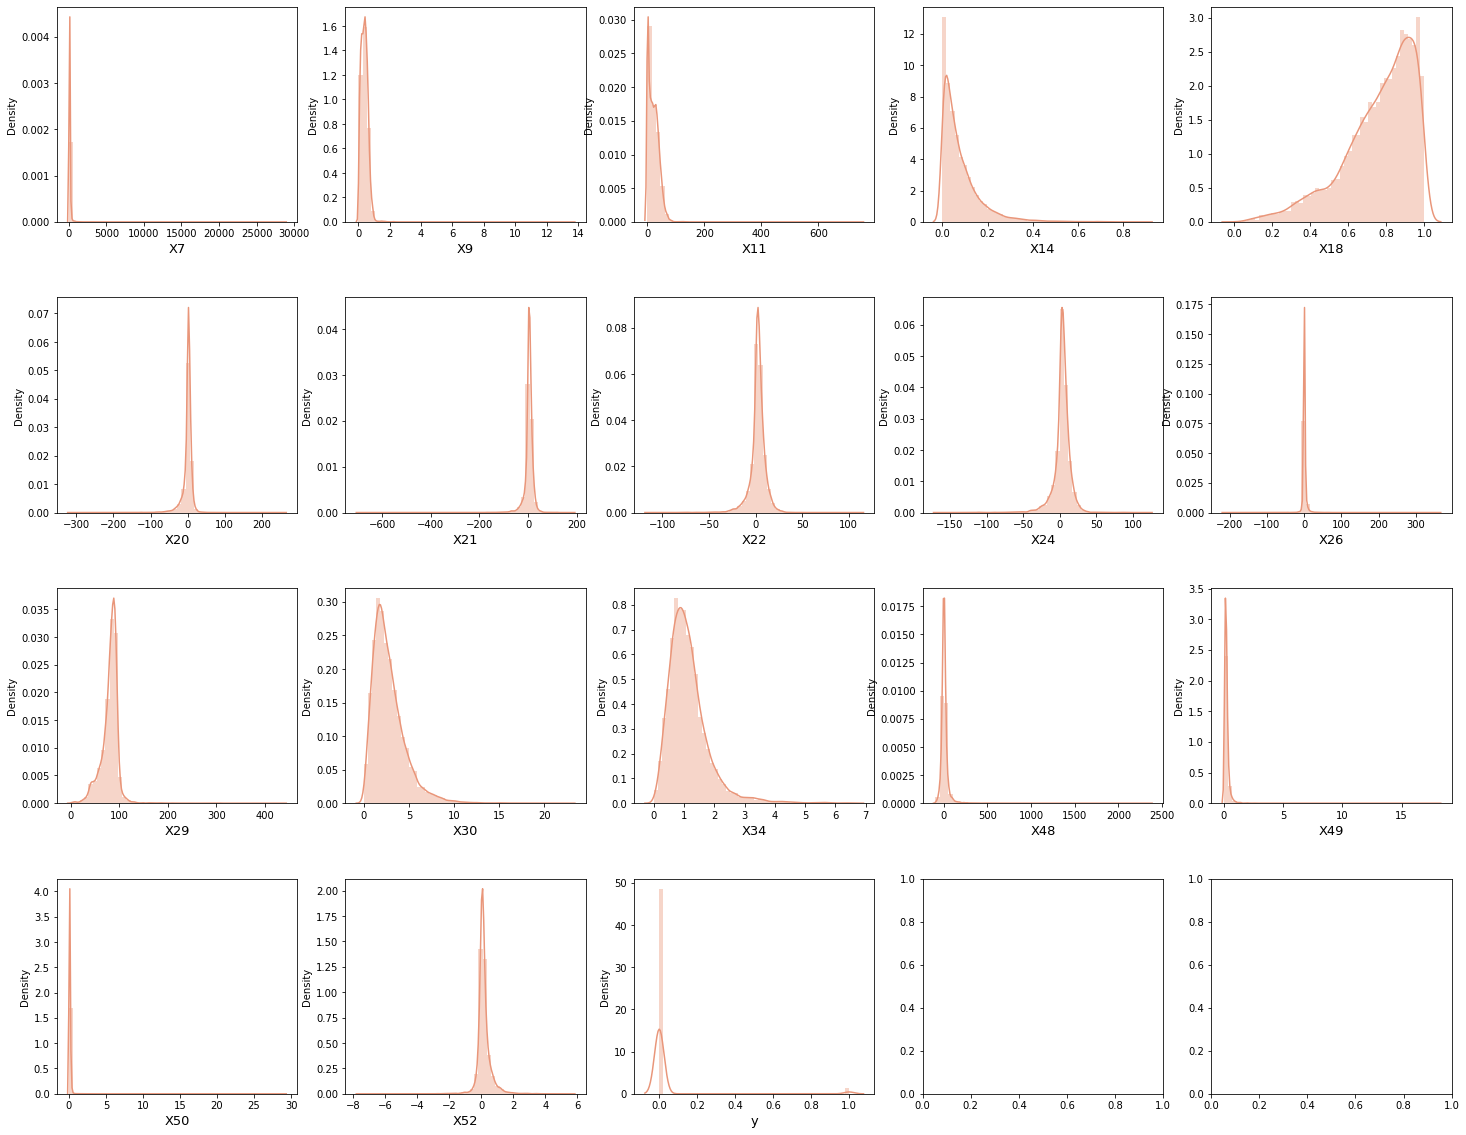

In [180]:
# 스케일링 적용 전 분산도

col_num = company.select_dtypes(include = ["int64","float64"]).columns.tolist()

fig = figsize = (14, 10)

fig, axs = plt.subplots(4, 5, figsize = (25, 20))
for col, ax in zip(col_num, axs.flatten()):
  b = sns.distplot(x = company[col], ax = ax, color = 'darksalmon')
  b.set_xlabel(col, fontsize = 13)
  plt.subplots_adjust(hspace = .35)

In [187]:
# robust scaler 적용(이상치가 크게 나타나는 변수에만 적용)
caler = RobustScaler()

company['scaled_X7'] = scaler.fit_transform(company['X7'].values.reshape(-1, 1))
company['scaled_X11'] = scaler.fit_transform(company['X11'].values.reshape(-1, 1))
company['scaled_X24'] = scaler.fit_transform(company['X24'].values.reshape(-1, 1))
company['scaled_X26'] = scaler.fit_transform(company['X26'].values.reshape(-1, 1))
company['scaled_X29'] = scaler.fit_transform(company['X29'].values.reshape(-1, 1))
company['scaled_X48'] = scaler.fit_transform(company['X48'].values.reshape(-1, 1))

scaled_X7 = company["scaled_X7"]
scaled_X11 = company["scaled_X11"]
scaled_X24 = company["scaled_X24"]
scaled_X26 = company["scaled_X26"]
scaled_X29 = company["scaled_X29"]
scaled_X48 = company["scaled_X48"]

company.drop(["X7", "X11", "X24", "X26", "X29", "X48", "scaled_X7", "scaled_X11", "scaled_X24", "scaled_X26", "scaled_X29", "scaled_X48"], axis = 1, inplace = True)
company.insert(0, "scaled_X7", scaled_X7)
company.insert(2, "scaled_X11", scaled_X11)
company.insert(8, "scaled_X24", scaled_X24)
company.insert(9, "scaled_X26", scaled_X26)
company.insert(10, "scaled_X29", scaled_X29)
company.insert(13, "scaled_X48", scaled_X48)
company

,scaled_X7,X9,scaled_X11,X14,X18,X20,X21,X22,scaled_X24,scaled_X26,scaled_X29,X30,X34,scaled_X48,X49,X50,X52,y
0,0.090706,0.506387,0.713105,0.010949,0.560903,-1.98,3.31,1.76,-0.070991,4.323383,-0.977517,0.88,0.68,1.405141,1.154737,0.445531,-0.171011,1
1,0.044049,0.508907,0.813327,0.060278,0.574994,-9.67,16.78,8.26,1.172583,4.935323,-1.715881,0.81,0.61,0.275657,0.844486,0.170245,-0.113390,1
2,0.622270,0.624708,1.100489,0.000288,0.807996,-11.70,-23.49,-8.07,-1.760098,1.562189,0.128598,1.93,0.95,0.321696,0.164789,0.099346,-0.073284,1
3,0.140344,0.659069,1.236251,0.203341,0.773539,-30.08,-27.65,-9.91,-2.009792,2.601990,0.102821,1.21,0.75,0.847305,0.068368,0.046222,-0.189775,1
4,45.856376,0.974537,1.781430,0.046446,0.919282,-9.00,-69.29,-4.43,-1.070991,6.636816,1.375627,2.82,0.39,-0.284097,0.106794,0.283911,0.033944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,5.559440,0.804974,0.309018,0.002530,0.806260,-1.88,0.67,0.13,-0.455324,1.313433,0.752399,8.39,1.13,-1.119317,0.039572,0.061924,-0.006228,0
11682,8.741820,0.870982,0.483163,0.012445,0.796467,-7.65,-12.80,-2.10,-0.791922,1.552239,0.900759,9.83,1.08,0.539613,0.047676,0.074507,-0.007362,0
11683,16.510770,0.927526,0.487428,0.012213,0.759045,-11.99,-49.41,-5.02,-1.244798,1.875622,1.080052,8.28,1.09,-0.182045,0.056971,0.094384,-0.041959,0
11684,26.160766,0.954386,2.205775,0.019556,0.774129,-8.99,-39.69,-2.52,-0.873929,12.825871,1.002148,1.41,0.21,-1.647995,0.027454,0.180785,-0.045929,0


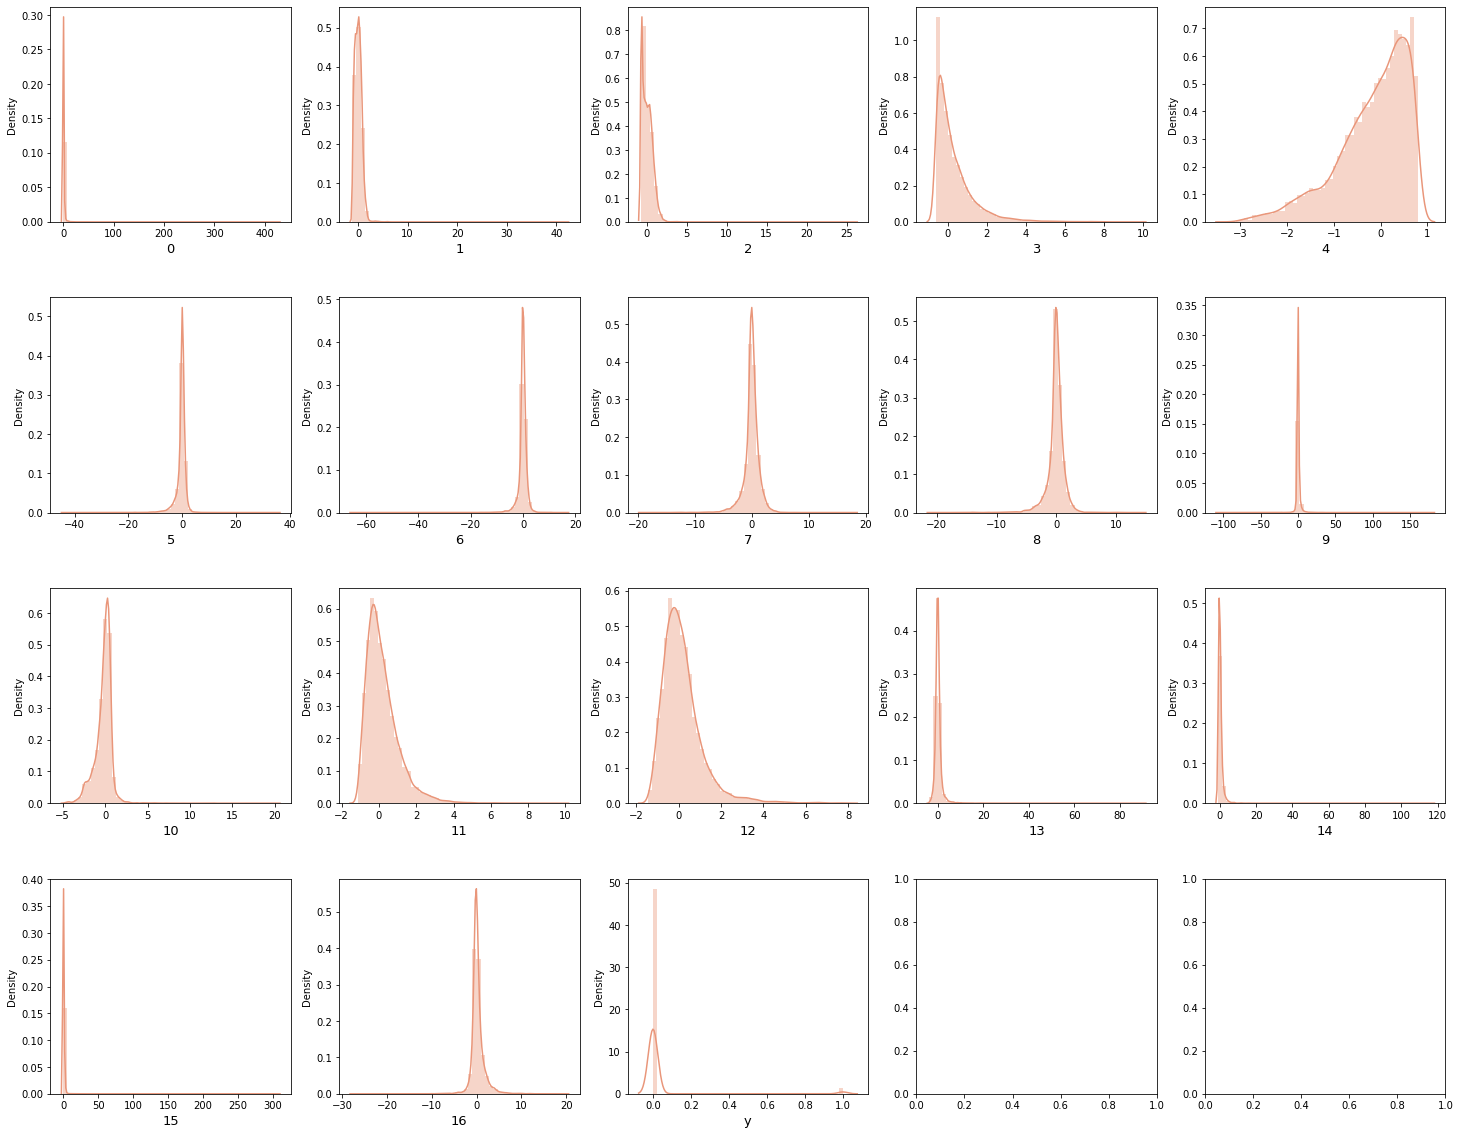

In [183]:
# 스케일링 적용 후 분포도
col_num = scaled_data.select_dtypes(include = ["int64","float64"]).columns.tolist()

fig = figsize = (14, 10)

fig, axs = plt.subplots(4, 5, figsize = (25, 20))
for col, ax in zip(col_num, axs.flatten()):
  b = sns.distplot(x = scaled_data[col], ax = ax, color = 'darksalmon')
  b.set_xlabel(col, fontsize = 13)
  plt.subplots_adjust(hspace = .35)

In [184]:
company.to_csv("/content/drive/Shareddrives/F4/data/scaled_17_raw_data.csv")

In [321]:
train_selected_data = pd.read_csv("/content/drive/Shareddrives/F4/data/train_selected_data.csv")
train_selected_data.drop("Unnamed: 0", axis = 1, inplace = True)

test_selected_data = pd.read_csv("/content/drive/Shareddrives/F4/data/test_selected_data.csv")
test_selected_data.drop("Unnamed: 0", axis = 1, inplace = True)

selected_data = pd.concat([train_selected_data, test_selected_data])

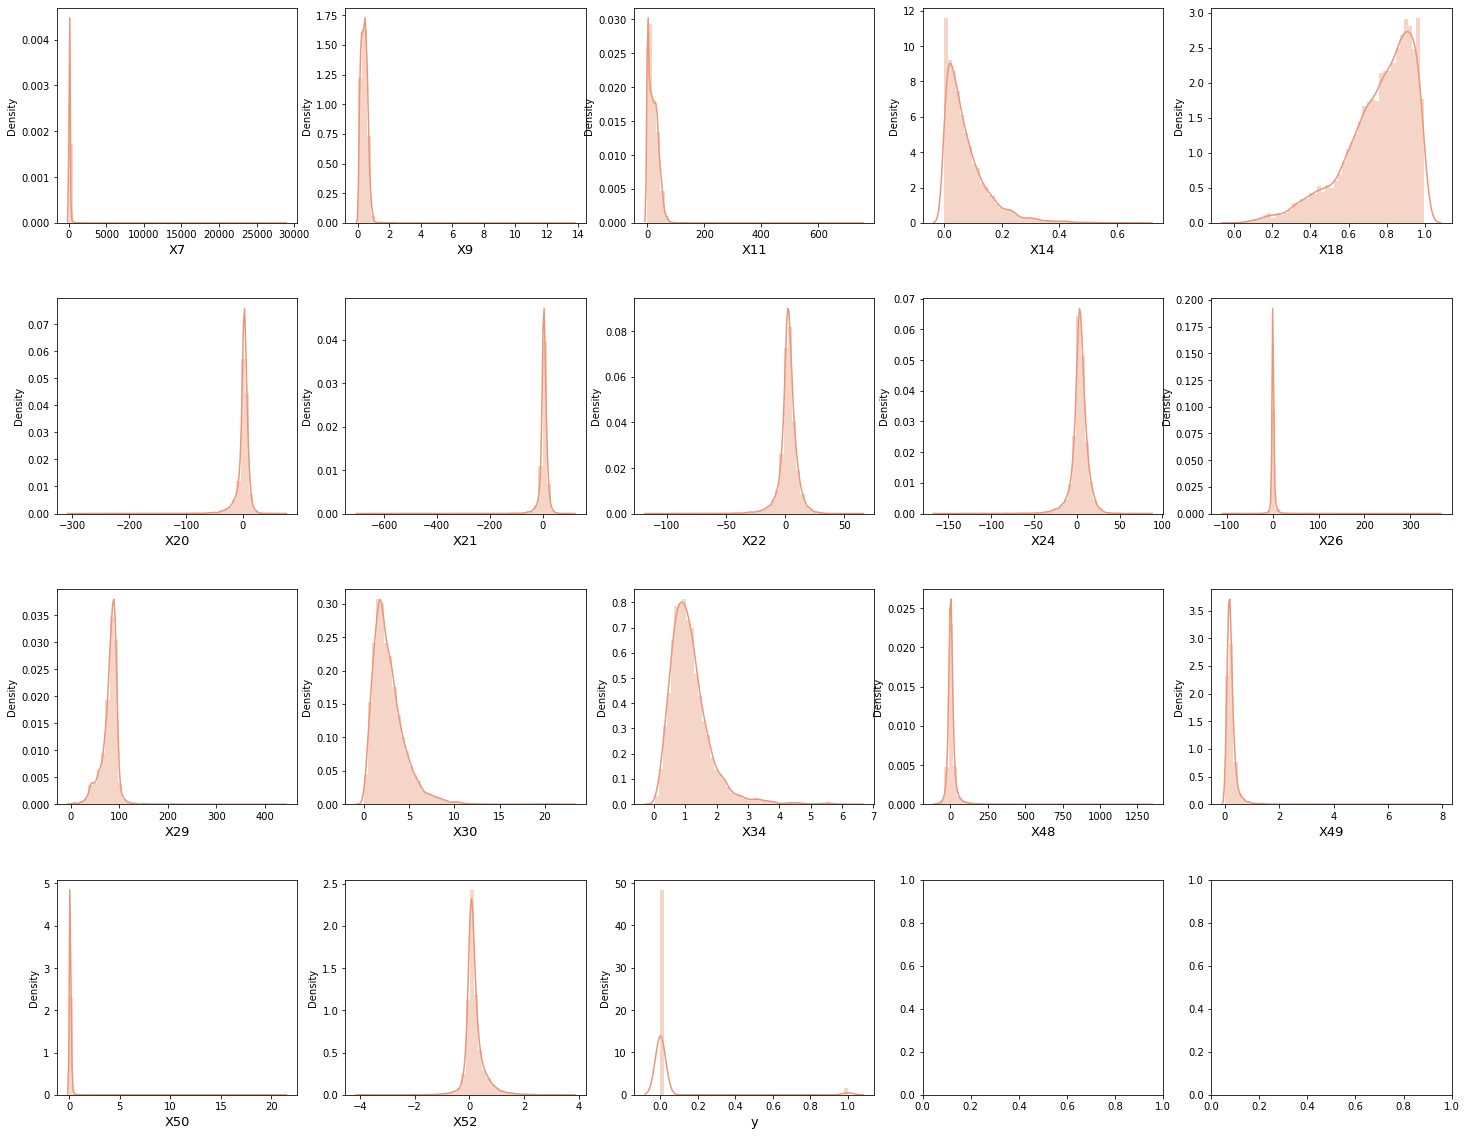

In [291]:
# 스케일링 적용 후 분포도
col_num = selected_data.select_dtypes(include = ["int64","float64"]).columns.tolist()

fig = figsize = (14, 10)

fig, axs = plt.subplots(4, 5, figsize = (25, 20))
for col, ax in zip(col_num, axs.flatten()):
  b = sns.distplot(x = selected_data[col], ax = ax, color = 'darksalmon')
  b.set_xlabel(col, fontsize = 13)
  plt.subplots_adjust(hspace = .35)

In [322]:
# robust scaler 적용(이상치가 크게 나타나는 변수에만 적용)
caler = RobustScaler()

selected_data['scaled_X7'] = scaler.fit_transform(selected_data['X7'].values.reshape(-1, 1))
selected_data['scaled_X11'] = scaler.fit_transform(selected_data['X11'].values.reshape(-1, 1))
selected_data['scaled_X24'] = scaler.fit_transform(selected_data['X24'].values.reshape(-1, 1))
selected_data['scaled_X26'] = scaler.fit_transform(selected_data['X26'].values.reshape(-1, 1))
selected_data['scaled_X29'] = scaler.fit_transform(selected_data['X29'].values.reshape(-1, 1))
selected_data['scaled_X48'] = scaler.fit_transform(selected_data['X48'].values.reshape(-1, 1))

scaled_X7 = selected_data["scaled_X7"]
scaled_X11 = selected_data["scaled_X11"]
scaled_X24 = selected_data["scaled_X24"]
scaled_X26 = selected_data["scaled_X26"]
scaled_X29 = selected_data["scaled_X29"]
scaled_X48 = selected_data["scaled_X48"]

selected_data.drop(["X7", "X11", "X24", "X26", "X29", "X48", "scaled_X7", "scaled_X11", "scaled_X24", "scaled_X26", "scaled_X29", "scaled_X48"], axis = 1, inplace = True)
selected_data.insert(0, "scaled_X7", scaled_X7)
selected_data.insert(2, "scaled_X11", scaled_X11)
selected_data.insert(8, "scaled_X24", scaled_X24)
selected_data.insert(9, "scaled_X26", scaled_X26)
selected_data.insert(10, "scaled_X29", scaled_X29)
selected_data.insert(13, "scaled_X48", scaled_X48)
selected_data

,scaled_X7,X9,scaled_X11,X14,X18,X20,X21,X22,scaled_X24,scaled_X26,scaled_X29,X30,X34,scaled_X48,X49,X50,X52,y
0,0.093202,0.506387,0.753524,0.010949,0.560903,-1.980,3.310,1.760,-0.069293,4.557441,-1.006722,0.880,0.680,1.822504,1.154737,0.445531,-0.171011,1
1,0.045241,0.508907,0.857459,0.060278,0.574994,-9.670,16.780,8.260,1.176759,5.199739,-1.768486,0.810,0.610,0.301253,0.844486,0.170245,-0.113390,1
2,0.639622,0.624708,1.155257,0.000288,0.807996,-11.700,-23.490,-8.070,-1.761766,1.659269,0.134446,1.930,0.950,0.363261,0.164789,0.099346,-0.073284,1
3,0.144228,0.659069,1.296047,0.203341,0.773539,-30.080,-27.650,-9.910,-2.011958,2.750653,0.107853,1.210,0.750,1.071179,0.068368,0.046222,-0.189775,1
4,-1.383784,1.680622,3.221413,0.025410,0.888816,-57.300,0.000,-10.930,-1.896673,13.178851,2.429785,3.280,0.390,-3.445033,0.047558,0.312093,-0.018790,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,-0.044475,0.291878,0.031881,0.086167,0.744862,-3.680,3.075,2.235,-0.091982,0.126632,-0.125286,1.570,0.655,0.957241,0.305225,0.117222,0.143648,0
1866,0.074891,0.361082,0.082926,0.082305,0.753778,-5.515,4.115,2.755,-0.026981,0.022193,-0.138879,1.535,0.690,-0.039271,0.339708,0.115153,0.128926,0
1867,0.210500,0.437173,0.204736,0.104944,0.759772,-2.705,6.180,3.660,0.112832,0.173629,-0.135333,1.555,0.725,0.180855,0.326595,0.113569,0.159354,0
1868,0.244364,0.468419,0.413895,0.128593,0.770408,2.660,6.790,3.730,0.121417,0.513055,-0.141833,1.440,0.695,0.302287,0.335828,0.099861,0.080062,0


In [323]:
train_scaled_data = selected_data.iloc[:-1870, :]
test_scaled_data = selected_data.iloc[-1870:, :]

train_scaled_data.to_csv("/content/drive/Shareddrives/F4/data/train_scaled_data.csv")
test_scaled_data.to_csv("/content/drive/Shareddrives/F4/data/test_scaled_data.csv")

# 모델링(Undersampling) - raw data

In [176]:
company = pd.read_csv("/content/drive/Shareddrives/F4/data/scaled_17_raw_data.csv")
company.drop("Unnamed: 0", axis = 1, inplace = True)
company

,scaled_X7,X9,scaled_X11,X14,X18,X20,X21,X22,scaled_X24,scaled_X26,scaled_X29,X30,X34,scaled_X48,X49,X50,X52,y
0,0.090706,0.506387,0.713105,0.010949,0.560903,-1.98,3.31,1.76,-0.070991,4.323383,-0.977517,0.88,0.68,1.405141,1.154737,0.445531,-0.171011,1
1,0.044049,0.508907,0.813327,0.060278,0.574994,-9.67,16.78,8.26,1.172583,4.935323,-1.715881,0.81,0.61,0.275657,0.844486,0.170245,-0.113390,1
2,0.622270,0.624708,1.100489,0.000288,0.807996,-11.70,-23.49,-8.07,-1.760098,1.562189,0.128598,1.93,0.95,0.321696,0.164789,0.099346,-0.073284,1
3,0.140344,0.659069,1.236251,0.203341,0.773539,-30.08,-27.65,-9.91,-2.009792,2.601990,0.102821,1.21,0.75,0.847305,0.068368,0.046222,-0.189775,1
4,45.856376,0.974537,1.781430,0.046446,0.919282,-9.00,-69.29,-4.43,-1.070991,6.636816,1.375627,2.82,0.39,-0.284097,0.106794,0.283911,0.033944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,5.559440,0.804974,0.309018,0.002530,0.806260,-1.88,0.67,0.13,-0.455324,1.313433,0.752399,8.39,1.13,-1.119317,0.039572,0.061924,-0.006228,0
11682,8.741820,0.870982,0.483163,0.012445,0.796467,-7.65,-12.80,-2.10,-0.791922,1.552239,0.900759,9.83,1.08,0.539613,0.047676,0.074507,-0.007362,0
11683,16.510770,0.927526,0.487428,0.012213,0.759045,-11.99,-49.41,-5.02,-1.244798,1.875622,1.080052,8.28,1.09,-0.182045,0.056971,0.094384,-0.041959,0
11684,26.160766,0.954386,2.205775,0.019556,0.774129,-8.99,-39.69,-2.52,-0.873929,12.825871,1.002148,1.41,0.21,-1.647995,0.027454,0.180785,-0.045929,0


In [177]:
classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "K Nearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}

precision_dataframe = pd.DataFrame()
recall_dataframe = pd.DataFrame()
f1_dataframe = pd.DataFrame()
auc_dataframe = pd.DataFrame()

for i in range(0, 10):

  X = company.drop('y', axis=1)
  y = company['y']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

  df = pd.concat([X_train, y_train], axis = 1)

  delisted_company = df[df['y'] == 1]
  nondelisted_company = df[df['y'] == 0].sample(257)

  df = pd.concat([delisted_company, nondelisted_company]).sample(frac = 1)
  df.reset_index(drop = True, inplace = True)
  X_train = df.drop('y', axis=1)
  y_train = df['y']

  X_train = X_train.values
  X_test = X_test.values
  y_train = y_train.values
  y_test = y_test.values

  for key, classifier in classifiers.items():
      classifier.fit(X_train, y_train)
      training_score = cross_val_score(classifier, X_train, y_train, cv = 5)

  precision_list = []
  recall_list = []
  f1_list = []
  auc_list = []

  for key, classifier in classifiers.items():
    
    y_pred = classifier.predict(X_test)
    results = classification_report(y_test, y_pred)

    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    auc = round(roc_auc_score(y_test, y_pred), 3)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc)
  
  precision_dataframe = pd.concat([precision_dataframe, pd.Series(precision_list)], axis = 1)
  recall_dataframe = pd.concat([recall_dataframe, pd.Series(recall_list)], axis = 1)
  f1_dataframe = pd.concat([f1_dataframe, pd.Series(f1_list)], axis = 1)
  auc_dataframe = pd.concat([auc_dataframe, pd.Series(auc_list)], axis = 1)

evaluation = pd.concat([precision_dataframe.mean(axis = 1), recall_dataframe.mean(axis = 1), f1_dataframe.mean(axis = 1), auc_dataframe.mean(axis = 1)], axis = 1)
evaluation.index = list(classifiers.keys())
evaluation.columns = ["precision", "recall", "f1", "auc"]
evaluation

,precision,recall,f1,auc
Logisitic Regression,0.1715,0.8582,0.2854,0.8655
K Nearest,0.1452,0.8640,0.2486,0.8544
Support Vector Classifier,0.1648,0.8727,0.2770,0.8689
Decision Tree Classifier,0.1203,0.8075,0.2092,0.8132
Random Forest Classifier,0.1465,0.9088,0.2524,0.8734
Gradient Boosting Classifier,0.1587,0.9073,0.2700,0.8802
LightGBM Classifier,0.1595,0.9016,0.2710,0.8781


In [188]:
evaluation.to_excel("/content/drive/Shareddrives/F4/result_tables/scaled_17_raw_data_evaluation.xlsx")

# 모델링(Undersampling) - corrected data

In [3]:
train_selected_data = pd.read_csv("/content/drive/Shareddrives/F4/data/train_selected_data.csv")
train_selected_data.drop("Unnamed: 0", axis = 1, inplace = True)

test_selected_data = pd.read_csv("/content/drive/Shareddrives/F4/data/test_selected_data.csv")
test_selected_data.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
train_selected_data['y'].value_counts()

0    8088
1     256
Name: y, dtype: int64

In [501]:
classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "K Nearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}

precision_dataframe = pd.DataFrame()
recall_dataframe = pd.DataFrame()
f1_dataframe = pd.DataFrame()
auc_dataframe = pd.DataFrame()

for i in range(0, 100):

  delisted_company = train_selected_data[train_selected_data['y'] == 1]
  nondelisted_company = train_selected_data[train_selected_data['y'] == 0].sample(256)

  df = pd.concat([delisted_company, nondelisted_company]).sample(frac = 1)
  df.reset_index(drop = True, inplace = True)

  X = company.drop('y', axis=1)
  y = company['y']

  X_train = df.drop('y', axis=1)
  y_train = df['y']

  test_data = pd.concat([test_nondelisted_company, test_delisted_company])

  X_test = test_data.iloc[:, :-1]
  y_test = test_data.iloc[:, -1]

  X_train = X_train.values
  X_test = X_test.values
  y_train = y_train.values
  y_test = y_test.values

  for key, classifier in classifiers.items():
      classifier.fit(X_train, y_train)
      training_score = cross_val_score(classifier, X_train, y_train, cv = 5)

  precision_list = []
  recall_list = []
  f1_list = []
  auc_list = []

  for key, classifier in classifiers.items():
    
    y_pred = classifier.predict(X_test)
    results = classification_report(y_test, y_pred)

    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    auc = round(roc_auc_score(y_test, y_pred), 3)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc)
  
  precision_dataframe = pd.concat([precision_dataframe, pd.Series(precision_list)], axis = 1)
  recall_dataframe = pd.concat([recall_dataframe, pd.Series(recall_list)], axis = 1)
  f1_dataframe = pd.concat([f1_dataframe, pd.Series(f1_list)], axis = 1)
  auc_dataframe = pd.concat([auc_dataframe, pd.Series(auc_list)], axis = 1)

evaluation = pd.concat([precision_dataframe.mean(axis = 1), recall_dataframe.mean(axis = 1), f1_dataframe.mean(axis = 1), auc_dataframe.mean(axis = 1)], axis = 1)
evaluation.index = list(classifiers.keys())
evaluation.columns = ["precision", "recall", "f1", "auc"]
evaluation

,precision,recall,f1,auc
Logisitic Regression,0.18243,0.89133,0.30268,0.86772
K Nearest,0.20003,0.86589,0.32489,0.86546
Support Vector Classifier,0.28071,0.49854,0.35898,0.72433
Decision Tree Classifier,0.14967,0.87386,0.25537,0.83970
Random Forest Classifier,0.18041,0.94902,0.30296,0.89026
Gradient Boosting Classifier,0.19293,0.93428,0.31951,0.89061
LightGBM Classifier,0.19629,0.92855,0.32380,0.88986


In [363]:
evaluation.to_excel("/content/drive/Shareddrives/F4/result_tables/scaled_17_corrected_data_evaluation.xlsx")

# 포트폴리오 기업 선정(Logistic Regression)

In [383]:
# 2011년 데이터 가져오기
good_company = pd.read_csv("/content/drive/Shareddrives/F4/data/good_company.csv")
good_company.drop("Unnamed: 0", axis = 1, inplace = True)
company_list = good_company["회사명"].drop_duplicates()
good_company.query("회계년도 in [2010, 2011]", inplace = True)

# 총부채증가율, 부가가치증가율, 고용인증가율 변수 생성
a = []
b = []
c = []
for i in tqdm(company_list):
  comp = good_company[good_company["회사명"] == i]
  fiscal_year = comp["회계년도"][1:]
  for j in fiscal_year:

    current_period = comp[comp["회계년도"] == j]
    k = j - 1
    previous_period = comp[comp["회계년도"] == k]

    x1 = current_period['부채'].values[0]
    x2 = previous_period['부채'].values[0]
    aa = (x1 - x2) / x2
    a.append(aa)

    x3 = current_period['부가가치'].values[0]
    x4 = previous_period['부가가치'].values[0]
    bb = (x3 - x4) / x4
    b.append(bb)

    x5 = current_period['고용인'].values[0]
    x6 = previous_period['고용인'].values[0]
    cc = (x5 - x6) / x6
    c.append(cc)

values1 = pd.DataFrame([a, b, c])
values1 = values1.transpose()
values1 = values1.rename(columns={0:'총부채증가율', 1:'부가가치증가율', 2:'고용인증가율'})

good_company2 = good_company.query("회계년도 == 2011")
values1.index = good_company2.index
backtest_data = pd.concat([values1, good_company2.iloc[:, 3:56]], axis = 1)
backtest_data["y"] = 0

var = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
             'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
             'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
             'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
             'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
             'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'y']

selected_variables = ['X7', 'X9', 'X11', 'X14', 'X18', 'X20', 'X21', 'X22', 'X24', 'X26', 'X29', 'X30', 'X34', 'X48', 'X49', 'X50', 'X52', 'y']

backtest_data.columns = var
backtest_data = backtest_data[selected_variables]
backtest_data

100%|██████████| 1136/1136 [00:03<00:00, 347.10it/s]


,X7,X9,X11,X14,X18,X20,X21,X22,X24,X26,X29,X30,X34,X48,X49,X50,X52,y
1,67.16,0.336048,16.74,0.041835,0.955427,-4.66,3.90,2.63,2.75,0.81,58.17,1.56,0.68,17.05,0.622488,0.143474,-0.268780,0
12,314.69,0.753615,59.75,0.029168,0.925330,-7.31,-11.96,-3.14,-3.65,9.71,82.94,2.62,0.49,-10.98,0.132996,0.051900,0.069086,0
23,67.56,0.134613,0.00,0.033329,0.721315,-6.30,-5.12,-4.47,-5.78,-1.04,69.79,1.90,1.16,-28.54,0.050412,0.081972,0.266922,0
34,84.87,0.370027,28.43,0.035066,0.794794,3.21,7.91,5.07,6.50,0.41,92.95,4.87,2.25,17.75,0.164796,0.005857,0.184650,0
45,93.52,0.475226,14.67,0.210850,0.724028,7.61,18.76,9.83,13.81,-0.65,79.35,1.81,1.08,14.45,0.285700,0.223048,0.128791,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12442,171.52,0.650883,22.47,0.003711,0.612049,6.67,22.38,7.73,10.86,0.48,92.38,10.24,4.50,23.54,0.101526,0.001472,0.201877,0
12453,48.67,0.186575,9.08,0.225179,0.960440,13.23,20.65,15.74,16.51,-0.29,55.68,1.08,0.60,2.14,0.332660,0.031294,0.914772,0
12464,69.49,0.454601,26.36,0.063902,0.947682,3.11,8.19,4.10,4.43,0.88,75.88,2.14,1.07,12.01,0.346190,0.188526,-0.232356,0
12475,88.06,0.364510,23.34,0.043761,0.793665,8.39,12.93,8.80,11.55,-1.00,84.16,1.84,1.17,-12.69,0.131326,0.113472,0.294044,0


In [382]:
backtest_data.to_csv("/content/drive/Shareddrives/F4/data/backtest_data.csv")

In [454]:
train_selected_data = pd.read_csv("/content/drive/Shareddrives/F4/data/train_selected_data.csv")
train_selected_data.drop("Unnamed: 0", axis = 1, inplace = True)

backtest_data = pd.read_csv("/content/drive/Shareddrives/F4/data/backtest_data.csv")
backtest_data.drop("Unnamed: 0", axis = 1, inplace = True)

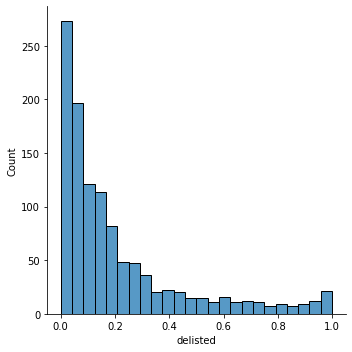

In [427]:
# 분류 예측 확률 산포도 확인
delisted_company = train_selected_data[train_selected_data['y'] == 1]
nondelisted_company = train_selected_data[train_selected_data['y'] == 0].sample(256)

df = pd.concat([delisted_company, nondelisted_company]).sample(frac = 1)
df.reset_index(drop = True, inplace = True)

X = company.drop('y', axis=1)
y = company['y']

X_train = df.drop('y', axis=1)
y_train = df['y']

X_test = backtest_data.iloc[:, :-1]
y_test = backtest_data.iloc[:, -1]

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

LR = LogisticRegression().fit(X_train, y_train)

LR_proba = LR.predict_proba(X_test)
LR_proba = pd.DataFrame(LR_proba)
LR_proba.columns = ["nondelisted", "delisted"]
sns.displot(LR_proba["delisted"])

In [479]:
LR_proba.to_csv("/content/drive/Shareddrives/F4/data/LR_proba.csv")

In [494]:
backtest_100 = list(LR_proba.sort_values("nondelisted").head(20).index)
backtest_over_50 = list(LR_proba.query("delisted > 0.5").sort_values("nondelisted").index)
backtest_50 = list(LR_proba.query("delisted <= 0.5").sort_values("nondelisted").head(20).index)
backtest_0 = list(LR_proba.sort_values("nondelisted").tail(100).index)

In [495]:
backtest_100 = backtest_data.iloc[backtest_100, :]
backtest_over_50 = backtest_data.iloc[backtest_over_50, :]
backtest_50 = backtest_data.iloc[backtest_50, :]
backtest_0 = backtest_data.iloc[backtest_0, :]

In [496]:
search_company = pd.read_csv("/content/drive/Shareddrives/F4/data/backtest_data.csv")
search_company.set_index("Unnamed: 0", inplace = True)

In [489]:
search_over_50 = []
for i in backtest_over_50.index:
  for j in search_company.index:
    if list(backtest_over_50.loc[i, :]) == list(search_company.loc[j, :]):
      search_over_50.append(j)

search_over_50

[8152,
 8757,
 8493,
 364,
 3884,
 4016,
 6238,
 4731,
 8911,
 9813,
 11540,
 10638,
 4918,
 7393,
 12266,
 11155,
 10077,
 320,
 2949,
 7921,
 3510,
 3862,
 4555,
 760,
 6172,
 10473,
 2113,
 2102,
 3356,
 1376,
 2410,
 1123,
 5952,
 5798,
 386,
 6700,
 2421,
 12145,
 11276,
 7734,
 5204,
 5116,
 3213,
 8702,
 10352,
 5556,
 9736,
 10033,
 1013,
 10451,
 4401,
 11551,
 6557,
 3521,
 353,
 2762,
 12387,
 2443,
 10319,
 8801,
 8251,
 12,
 8735,
 5160,
 6876,
 6359,
 10297,
 9351,
 3554,
 10044,
 6854,
 6458,
 11177,
 716,
 1585,
 5886,
 8449,
 4610,
 7635,
 2058,
 4632,
 9868,
 10550,
 4236,
 4907,
 8108,
 5787,
 9439,
 7415,
 11573,
 2773,
 5578,
 12288,
 2476,
 408,
 2993,
 2740,
 6733,
 10176,
 8515,
 5281,
 3400,
 9626,
 837,
 10858,
 1761,
 12090,
 6117,
 9395,
 628,
 11144,
 1926,
 10066,
 10990,
 1607,
 2784,
 10902,
 925,
 7162,
 9197,
 7360,
 7987,
 11067,
 3906,
 9461,
 11056,
 9670,
 2586,
 1442,
 5600,
 573,
 1156,
 8768,
 4984,
 7778,
 5908,
 6920,
 8658,
 7305,
 10572,
 88

In [497]:
search_100 = []
for i in backtest_100.index:
  for j in search_company.index:
    if list(backtest_100.loc[i, :]) == list(search_company.loc[j, :]):
      search_100.append(j)

search_50 = []
for i in backtest_50.index:
  for j in search_company.index:
    if list(backtest_50.loc[i, :]) == list(search_company.loc[j, :]):
      search_50.append(j)

search_0 = []
for i in backtest_0.index:
  for j in search_company.index:
    if list(backtest_0.loc[i, :]) == list(search_company.loc[j, :]):
      search_0.append(j)

In [470]:
# 상위 20개
good_company2.query("index in @search_100")["회사명"]

320             (주)금빛
364          (주)까뮤이앤씨
2949          (주)아이에이
3884        (주)오리엔트정공
4016          (주)와이오엠
4731          (주)인스코비
4918         (주)자연과환경
6238            (주)파루
7393      갤럭시아머니트리(주)
7921        대우전자부품(주)
8152          대한해운(주)
8493         라온시큐어(주)
8757          범양건영(주)
8911          삼부토건(주)
9813           얍엑스(주)
10077     에코바이오홀딩스(주)
10638          이트론(주)
11155         진흥기업(주)
11540          파미셀(주)
12266    현대바이오사이언스(주)
Name: 회사명, dtype: object

In [471]:
# 중위 20개
good_company2.query("index in @search_50")["회사명"]

562         (주)누리플렉스
1222         (주)디엠에스
1794      (주)비보존헬스케어
2146        (주)서부티엔디
2432       (주)셀트리온제약
2465     (주)솔고바이오메디칼
2861          (주)아모텍
3125       (주)에스디시스템
4291          (주)위지트
4621        (주)이엠따블유
5644       (주)케이피엠테크
5897          (주)큐로컴
6029       (주)테라젠이텍스
6260        (주)파워로직스
7536          광전자(주)
8064         대한뉴팜(주)
10968     제이준코스메틱(주)
11309      코오롱글로벌(주)
11342        코웰패션(주)
12134        한일철강(주)
Name: 회사명, dtype: object

In [498]:
# 하위 100개
list(good_company2.query("index in @search_0")["회사명"])

['(주)강원랜드',
 '(주)강원에너지',
 '(주)고영테크놀러지',
 '(주)광주신세계',
 '(주)금화피에스시',
 '(주)대웅제약',
 '(주)동원에프앤비',
 '(주)마이크로컨텍솔루션',
 '(주)모다이노칩',
 '(주)무학',
 '(주)뷰웍스',
 '(주)빅솔론',
 '(주)성도이엔지',
 '(주)세아베스틸',
 '(주)수산중공업',
 '(주)신세계푸드',
 '(주)쎌바이오텍',
 '(주)아나패스',
 '(주)아모레퍼시픽',
 '(주)아이씨케이',
 '(주)아이앤씨테크놀로지',
 '(주)아이즈비전',
 '(주)에스비에스콘텐츠허브',
 '(주)에스에이엠티',
 '(주)에스원',
 '(주)에스티아이',
 '(주)에스티오',
 '(주)에스피씨삼립',
 '(주)에이텍',
 '(주)에프앤에프홀딩스',
 '(주)엘디티',
 '(주)엘에프',
 '(주)엘지화학',
 '(주)영원무역',
 '(주)오뚜기',
 '(주)온코퀘스트파마슈티컬',
 '(주)유아이디',
 '(주)유진테크',
 '(주)이노와이어리스',
 '(주)이라이콤',
 '(주)이브이첨단소재',
 '(주)이수화학',
 '(주)이엔에프테크놀로지',
 '(주)이원',
 '(주)인터로조',
 '(주)정상제이엘에스',
 '(주)제주반도체',
 '(주)중앙에너비스',
 '(주)지에스글로벌',
 '(주)카프로',
 '(주)코세스',
 '(주)코엔텍',
 '(주)토비스',
 '(주)티씨케이',
 '(주)티에스이',
 '(주)티피씨메카트로닉스',
 '(주)파트론',
 '(주)프로텍',
 '(주)피씨디렉트',
 '(주)한글과컴퓨터',
 '(주)한샘',
 '(주)한섬',
 '(주)화신',
 'OCI(주)',
 '경남스틸(주)',
 '고려아연(주)',
 '금강철강(주)',
 '대신정보통신(주)',
 '대원산업(주)',
 '대창단조(주)',
 '덕산하이메탈(주)',
 '덕양산업(주)',
 '도이치모터스(주)',
 '동양이엔피(주)',
 '동일금속(주)',
 '롯데케미칼(주)',
 '리노공업(주)',
 '메가스터디(주)',
 '

In [493]:
# 부실 확률 50% 초과
len(list(good_company2.query("index in @search_over_50")["회사명"]))

141

# 포트폴리오 기업 선정(Gradient Boosting) - 대기

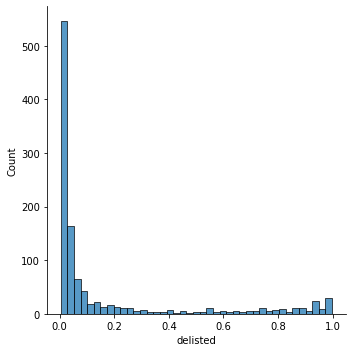

In [465]:
# 분류 예측 확률 산포도 확인
delisted_company = train_selected_data[train_selected_data['y'] == 1]
nondelisted_company = train_selected_data[train_selected_data['y'] == 0].sample(256)

df = pd.concat([delisted_company, nondelisted_company]).sample(frac = 1)
df.reset_index(drop = True, inplace = True)

X = company.drop('y', axis=1)
y = company['y']

X_train = df.drop('y', axis=1)
y_train = df['y']

X_test = backtest_data.iloc[:, :-1]
y_test = backtest_data.iloc[:, -1]

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

GB = GradientBoostingClassifier().fit(X_train, y_train)

GB_proba = GB.predict_proba(X_test)
GB_proba = pd.DataFrame(GB_proba)
GB_proba.columns = ["nondelisted", "delisted"]
sns.displot(GB_proba["delisted"])

In [ ]:
backtest_100 = list(LR_proba.sort_values("nondelisted").head(20).index)
backtest_50 = list(LR_proba.query("delisted <= 0.5").sort_values("nondelisted").head(20).index)
backtest_0 = list(LR_proba.sort_values("nondelisted").tail(20).index)

In [ ]:
backtest_100 = backtest_data.iloc[backtest_100, :]
backtest_50 = backtest_data.iloc[backtest_50, :]
backtest_0 = backtest_data.iloc[backtest_0, :]

# 임시 코딩

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

df = pd.concat([X_train, y_train], axis = 1)

delisted_company = df[df['y'] == 1]
nondelisted_company = df[df['y'] == 0].sample(257)

df = pd.concat([delisted_company, nondelisted_company]).sample(frac = 1)

X_train = df.drop('y', axis=1)
y_train = df['y']

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

LR = LogisticRegression().fit(X_train, y_train)

proba = LR.predict_proba(X_test)
proba = pd.DataFrame(proba)
proba.columns = ["nondelisted", "delisted"]
proba

,nondelisted,delisted
0,0.936366,0.063634
1,0.985048,0.014952
2,0.941377,0.058623
3,0.569084,0.430916
4,0.910163,0.089837
...,...,...
2333,0.007146,0.992854
2334,0.847747,0.152253
2335,0.664608,0.335392
2336,0.730540,0.269460


In [246]:
third = np.percentile(proba["delisted"], 33.3)
third

0.09002578819643461

In [247]:
second = np.percentile(proba["delisted"], 66.6)
second

0.2334387682414883

In [249]:
np.percentile(proba["delisted"], 90)

0.741655063274487

In [250]:
np.percentile(proba["delisted"], 10)

0.02946876653725259

In [232]:
proba.sort_values("nondelisted").head(10)

,nondelisted,delisted
442,3.973488e-12,1.000000
992,1.031242e-11,1.000000
447,2.397365e-08,1.000000
2294,8.519149e-08,1.000000
1817,1.989704e-07,1.000000
854,7.345530e-07,0.999999
1403,1.443040e-06,0.999999
1609,2.587265e-06,0.999997
784,6.452752e-06,0.999994
274,2.024159e-05,0.999980


In [223]:
list(proba.sort_values("0").head(10).index)

[274, 992, 1403, 2234, 442, 447, 1817, 1343, 370, 338]

In [236]:
proba.query("delisted < @second").sort_values("nondelisted").head(10)

,nondelisted,delisted
1935,0.746033,0.253967
831,0.746142,0.253858
104,0.747038,0.252962
1436,0.747237,0.252763
978,0.747627,0.252373
1521,0.747775,0.252225
1795,0.748073,0.251927
1331,0.748436,0.251564
315,0.748810,0.251190
1838,0.749071,0.250929


In [237]:
proba.query("delisted < @third").sort_values("nondelisted").head(10)

,nondelisted,delisted
597,0.898034,0.101966
677,0.898274,0.101726
2087,0.898528,0.101472
1531,0.898641,0.101359
1281,0.898752,0.101248
29,0.898798,0.101202
2264,0.899596,0.100404
555,0.899775,0.100225
2024,0.899835,0.100165
554,0.899872,0.100128


In [251]:
proba

,nondelisted,delisted
0,0.936366,0.063634
1,0.985048,0.014952
2,0.941377,0.058623
3,0.569084,0.430916
4,0.910163,0.089837
...,...,...
2333,0.007146,0.992854
2334,0.847747,0.152253
2335,0.664608,0.335392
2336,0.730540,0.269460


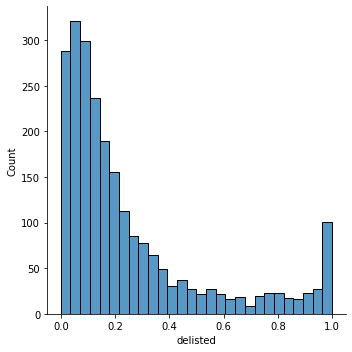

In [253]:
# 스케일링 적용 전 분산도

# col_num = company.select_dtypes(include = ["int64","float64"]).columns.tolist()

fig = figsize = (14, 10)

sns.displot(proba["delisted"])
# fig, axs = plt.subplots(4, 5, figsize = (25, 20))
# for col, ax in zip(col_num, axs.flatten()):
#   b = sns.distplot(x = company[col], ax = ax, color = 'darksalmon')
#   b.set_xlabel(col, fontsize = 13)
#   plt.subplots_adjust(hspace = .35)

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

df = pd.concat([X_train, y_train], axis = 1)

delisted_company = df[df['y'] == 1]
nondelisted_company = df[df['y'] == 0].sample(257)

df = pd.concat([delisted_company, nondelisted_company]).sample(frac = 1)

X_train = df.drop('y', axis=1)
y_train = df['y']

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

GB = GradientBoostingClassifier().fit(X_train, y_train)

proba = GB.predict_proba(X_test)
proba = pd.DataFrame(proba)
proba.columns = ["nondelisted", "delisted"]
proba

,nondelisted,delisted
0,0.946801,0.053199
1,0.989384,0.010616
2,0.989711,0.010289
3,0.256882,0.743118
4,0.989711,0.010289
...,...,...
2333,0.023384,0.976616
2334,0.761475,0.238525
2335,0.960574,0.039426
2336,0.874477,0.125523


In [239]:
third = np.percentile(proba["delisted"], 33.3)
third

0.017950115591978042

In [240]:
second = np.percentile(proba["delisted"], 66.6)
second

0.07029759739706273

In [242]:
proba.sort_values("nondelisted").head(10)

,nondelisted,delisted
111,0.003865,0.996135
2337,0.003954,0.996046
442,0.005628,0.994372
1609,0.007133,0.992867
1814,0.007703,0.992297
274,0.008248,0.991752
593,0.008656,0.991344
1400,0.009500,0.990500
617,0.012623,0.987377
1908,0.013307,0.986693


In [243]:
proba.query("delisted < @second").sort_values("nondelisted").head(10)

,nondelisted,delisted
1633,0.929854,0.070146
321,0.929999,0.070001
2211,0.930189,0.069811
1380,0.930767,0.069233
2192,0.931158,0.068842
640,0.931222,0.068778
1784,0.931273,0.068727
166,0.931508,0.068492
209,0.931820,0.068180
1872,0.931860,0.068140


In [244]:
proba.query("delisted < @third").sort_values("nondelisted").head(10)

,nondelisted,delisted
626,0.982050,0.017950
736,0.982057,0.017943
9,0.982073,0.017927
405,0.982078,0.017922
568,0.982130,0.017870
1809,0.982186,0.017814
2156,0.982226,0.017774
189,0.982244,0.017756
1489,0.982245,0.017755
1177,0.982265,0.017735


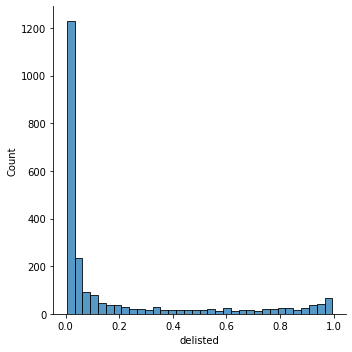

In [255]:
# 스케일링 적용 전 분산도

# col_num = company.select_dtypes(include = ["int64","float64"]).columns.tolist()

fig = figsize = (14, 10)

sns.displot(proba["delisted"])
# fig, axs = plt.subplots(4, 5, figsize = (25, 20))
# for col, ax in zip(col_num, axs.flatten()):
#   b = sns.distplot(x = company[col], ax = ax, color = 'darksalmon')
#   b.set_xlabel(col, fontsize = 13)
#   plt.subplots_adjust(hspace = .35)